### Correlations between cost of removal in FBA models and evolutionary rate

In [4]:
import os
import sys
from warnings import filterwarnings
sys.path.append('../flux_balance_analysis')
import cPickle as pickle
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from scipy.stats import wilcoxon
import cobra
from cobra.flux_analysis import single_gene_deletion, single_reaction_deletion
from enzyme import enzyme
from fba_utils import *
from single_knockouts import single_knockout_loss_costs


plt.style.use('../flux_balance_analysis/paper.mplstyle')
modelPath = '../data/external/yeast_7.6/yeast_7.6.xml'
modelName = modelPath.split('/')[-1][:-4]
modelDir = '../models/' + modelName
figDir = '../figures/' + modelName
if not os.path.exists(figDir):
    os.makedirs(figDir)
filterwarnings('ignore', 'charge of s_[0-9][0-9][0-9][0-9] is not a number ()')
filterwarnings('ignore', 'uppercase AND/OR found in rule ')
model = cobra.io.read_sbml_model(modelPath)

In [13]:
genes = [enzyme(g.id) for g in model.genes]
rules = [r.gene_reaction_rule for r in model.reactions if r.gene_reaction_rule != '']
geneMap = {gene.name: gene for gene in genes}
for rule in rules:
    genesInRule = set(rule.replace('and', '').replace('or', '').replace('(', '').replace(')', '').split())
    for geneName in genesInRule:
        geneMap[geneName].reactionRules.append(rule)
with open('../data/processed/dnds_rank_scerevisiae.tsv', 'r') as f:
    dndsRank = {l.split()[0]: int(float(l.split()[1])) for l in f.readlines()}
for gene in genes:
    if gene.name in dndsRank:
        gene.dndsRank = dndsRank[gene.name]
    else:
        gene.dndsRank = np.nan
print len([g for g in genes if np.isnan(g.dndsRank)]),
print 'enzymes with no orthologs in other yeast species used.'

13 enzymes with no orthologs in other yeast species used.


In [14]:
with open(os.path.join(modelDir, 'blocked_genes.txt'), 'r') as f:
    blockedGeneNames = [l.strip() for l in f.readlines()]
for blockedGene in blockedGeneNames:
    geneMap[blockedGene].blocked = True

In [15]:
with open(os.path.join(modelDir, 'gene_loss_costs.tsv'), 'r') as f:
    lines = f.readlines()
    minimalMedia = [tuple(m.split(' AND ')) for m in lines[0].strip().split('\t')[1:]]
    for line in lines[1:]:
        geneMap[line.split('\t')[0]].geneLossCosts = np.array([float(i.strip()) for i in line.split('\t')[1:]])
with open(os.path.join(modelDir, 'function_loss_costs.tsv'), 'r') as f:
    for line in f.readlines()[1:]:
        geneMap[line.split('\t')[0]].functionLossCosts = np.array([float(i.strip()) for i in line.split('\t')[1:]])
nMediaWithGrowth = genes[0].geneLossCosts.shape[0]
print nMediaWithGrowth, 'minimal media with loss costs'
if not all([g.functionLossCosts.shape[0] == nMediaWithGrowth 
            and g.geneLossCosts.shape[0] == nMediaWithGrowth
            for g in genes]):
    raise UserWarning('Should be function and gene loss costs for the same number of media for all genes')

1479 minimal media with loss costs


### Sanity check

In the simplest case, where a gene is only present in one rule and that rule only contains that gene, check that the two methods give the same answer.

In [16]:
genesShouldAgreeButDont = [g for g in genes if g.is_simple_single_function() 
                           and not g.old_and_new_costs_identical()]
if len(genesShouldAgreeButDont) == 0:
    print 'passed sanity check'
else:
    print 'ERROR: failed sanity check that genes with single, simple rules have same cost values'

passed sanity check


In [17]:
# inspect the genes and rules data
print len(model.genes), 'total genes'
print len(genes), 'total genes'
print len(model.reactions), 'reations in model'
print len(genes[0].geneLossCosts), 'conditions'
print 'there are', len(rules), 'gene to reaction rules'
print len([i for i in rules if 'or' in i]), 'rules containing an or'
print len([i for i in rules if 'and' in i]), 'rules containing an and'
maxGeneNameLength = max([len(i.name) for i in genes])
print len([i for i in rules if len(i) <= maxGeneNameLength]),
print 'rules that are just one gene'
print len([gene for gene in genes if gene.number_reactions()==0]), 'genes in 0 rules'
print len([gene for gene in genes if gene.number_reactions()==1]), 'genes in only 1 rule'
print len([gene for gene in genes if gene.is_multifunctional()]), 'genes in multiple rules'
print max([gene.number_reactions() for gene in genes]), 'is highest number of rules a single gene is involved in'
print len([gene for gene in genes if gene.is_simple_single_function()]),
print 'genes involved in only one simple rule'
print len([gene for gene in genes if gene.is_multifunctional() 
                                      and all([rule == gene.name for rule in gene.reactionRules])]),
print 'genes involved in only multiple simple rules'
print len([gene for gene in genes if gene.is_isoenzyme()]),
print 'isoenzymes'
print len([gene for gene in genes if gene.is_isoenzyme() and gene.is_multifunctional()]),
print 'multifunctional isoenzymes'
print len([gene for gene in genes if (not gene.is_isoenzyme()) and gene.is_multifunctional()]),
print 'multifunctional non-isoenzymes'
print len([gene for gene in genes if gene.old_and_new_costs_identical()]),
print 'genes have identical costs in old and new model'

909 total genes
909 total genes
1479 conditions
there are 2302 gene to reaction rules
445 rules containing an or
198 rules containing an and
1701 rules that are just one gene
0 genes in 0 rules
542 genes in only 1 rule
367 genes in multiple rules
192 is highest number of rules a single gene is involved in
285 genes involved in only one simple rule
144 genes involved in only multiple simple rules
407 isoenzymes
178 multifunctional isoenzymes
189 multifunctional non-isoenzymes
654 genes have identical costs in old and new model


In [18]:
# sanity check: rules are just made of gene names, and/or/()
allRules = ''.join(rules)
allRules = allRules.replace(' ', '')
allRules = allRules.replace('and', '')
allRules = allRules.replace('or', '')
allRules = allRules.replace('(', '')
allRules = allRules.replace(')', '')
for geneName in sorted([g.name for g in genes], key=len, reverse=True):
    allRules = allRules.replace(geneName, '')
if allRules != '':
    print 'FAILED check that rules contain only gene names / and / or / ()'
else:
    print 'passed check that rules contain only gene names / and / or / ()'

passed check that rules contain only gene names / and / or / ()


In [19]:
# sanity check: isoenzymes can't be simple single function
if len([gene for gene in genes if gene.is_isoenzyme() and gene.is_simple_single_function()]) != 0:
    print 'FAILED check that isoenzymes cant be simple functioned'
else:
    print 'passed check'

passed check


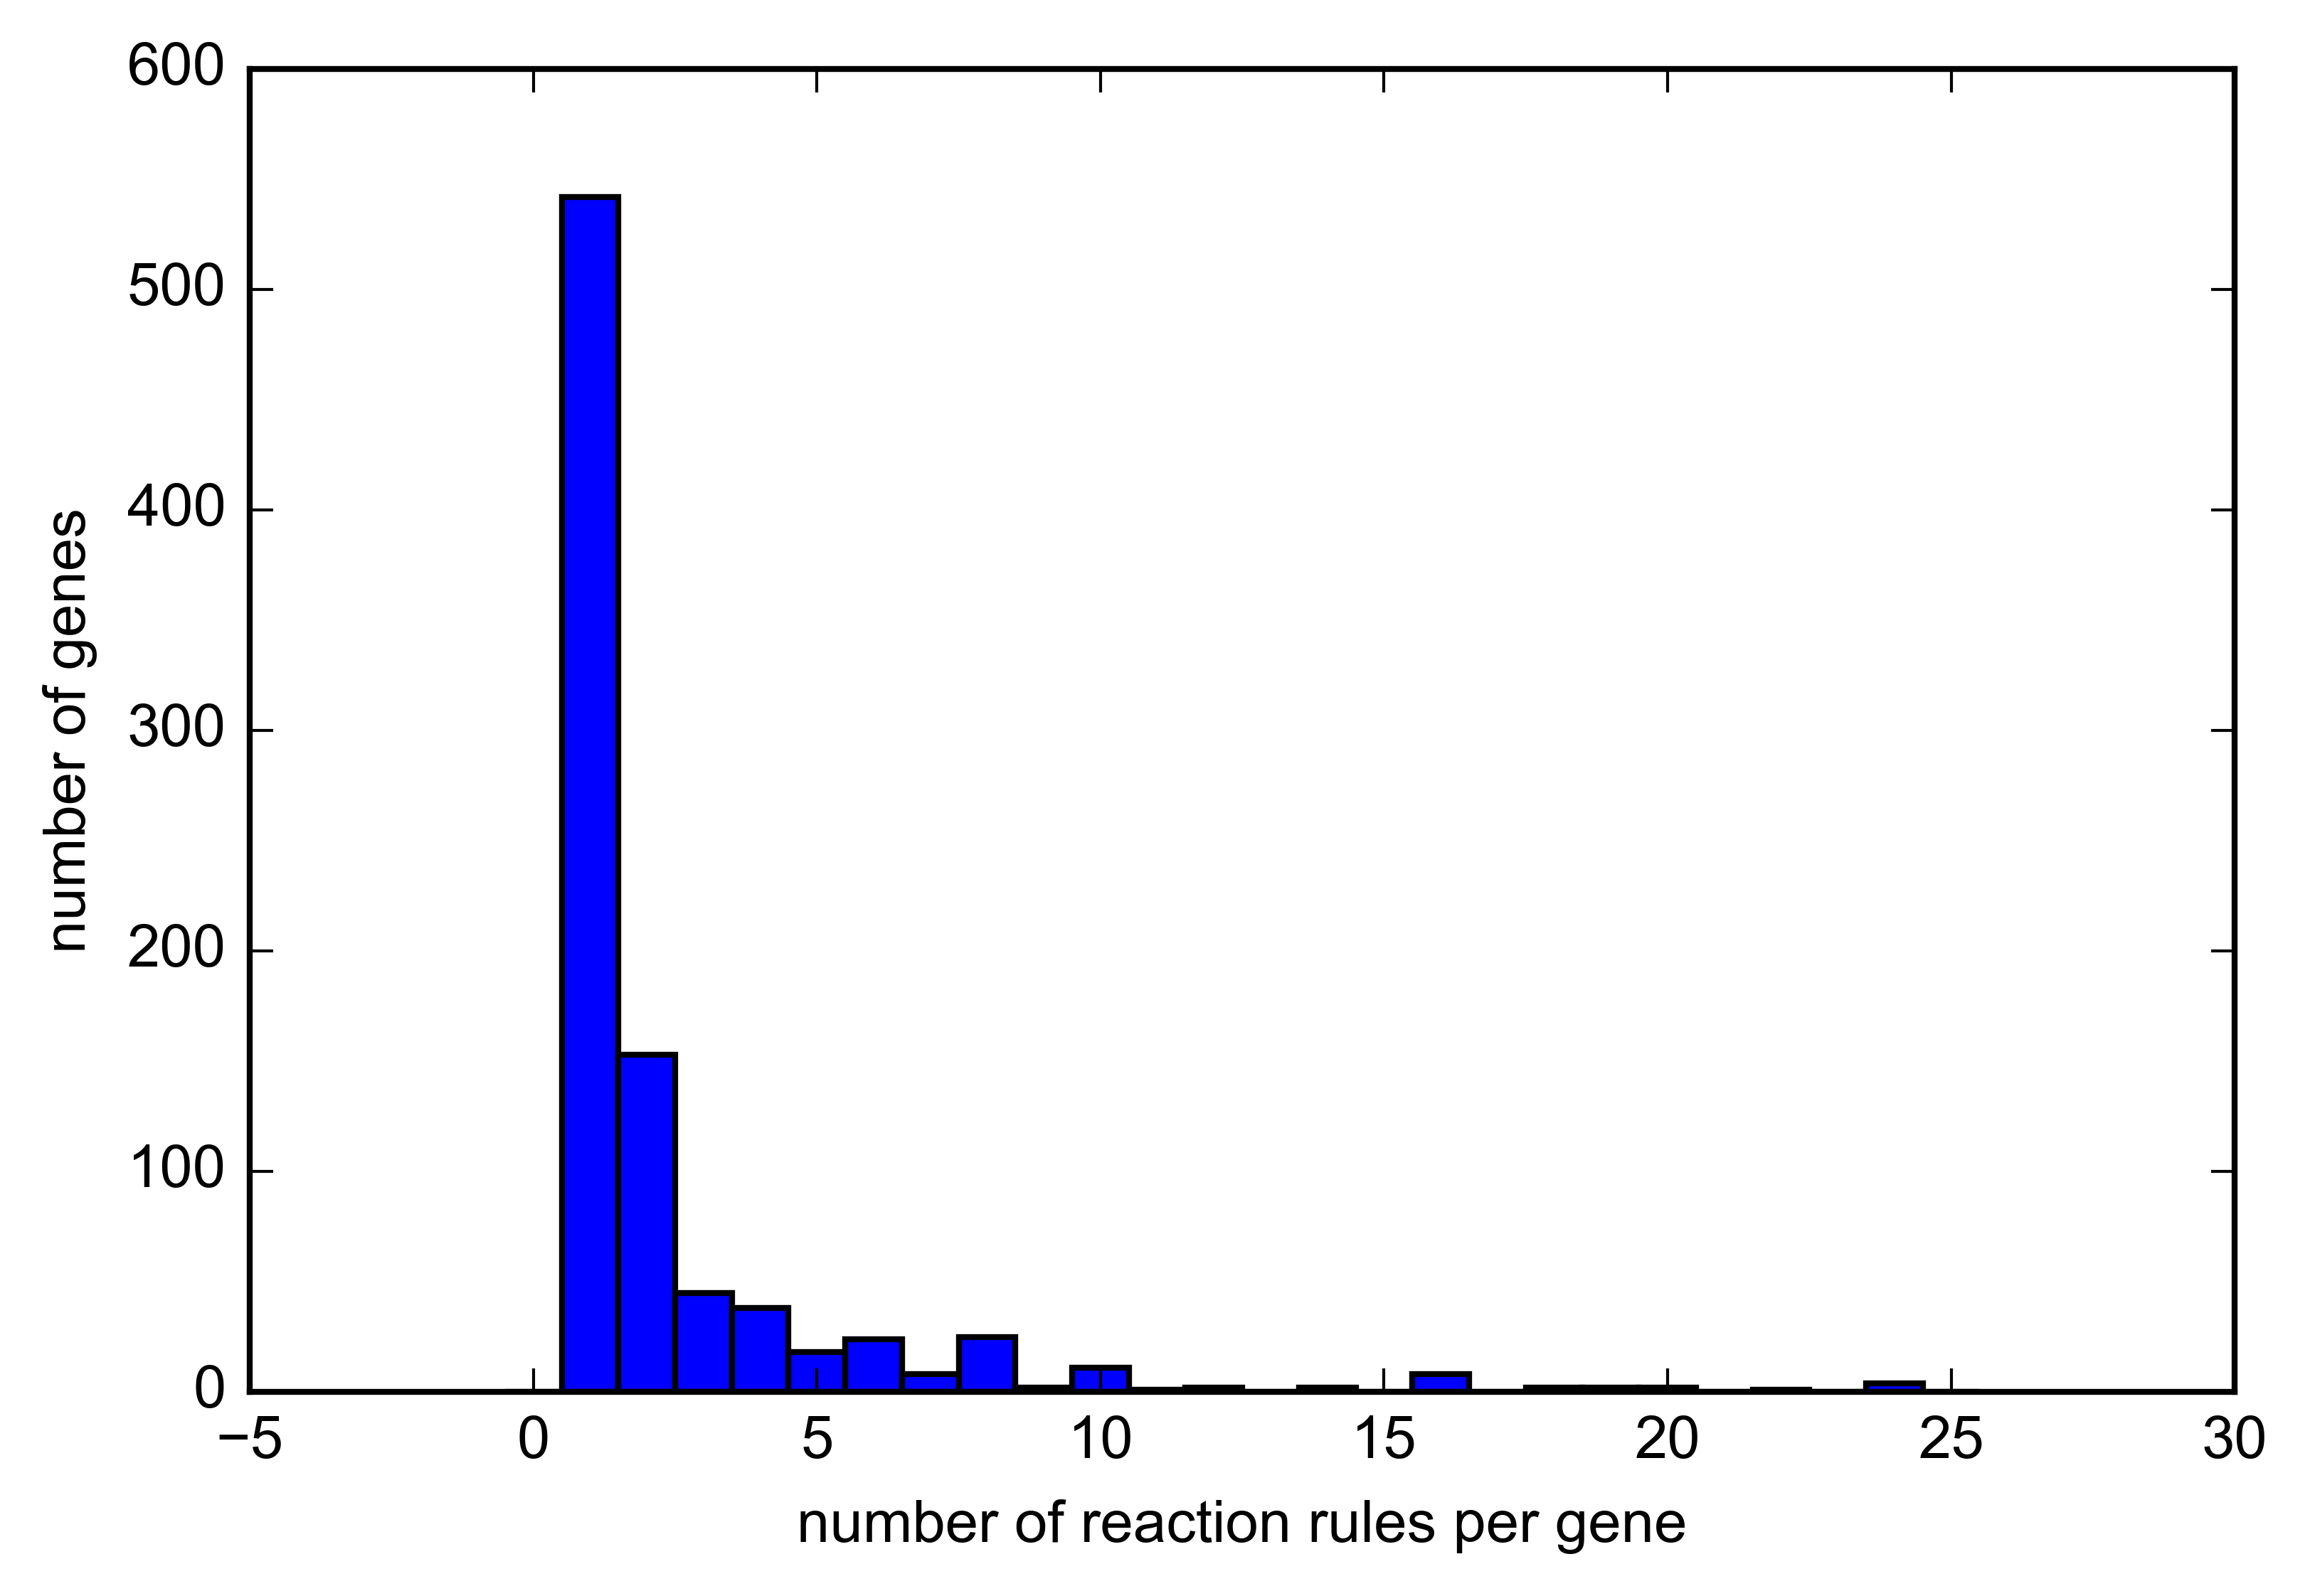

In [20]:
plt.hist([gene.number_reactions() for gene in genes], bins=26, range=(-0.5, 25.5))
plt.xlabel('number of reaction rules per gene')
plt.ylabel('number of genes')
plt.show()

### Sanity check

For isoenzymes present in only one rule, they should have the same costs as their partners

In [21]:
def genes_in_rule(rule):
    """Given a reaction rule, return a list of genes.
    
    Args:
        rule (str): the reaction rule.
        
    Returns:
        list(str): the genes.
    
    """
    genes = set(rule.replace('and', '').replace('or', '').replace('(', '').replace(')', '').split())
    if len(genes) == 0:
        raise UserWarning('ERROR: no genes found in reaction rule.')
    return genes

In [22]:
isoenzymesInOneReaction = [gene for gene in genes if gene.is_isoenzyme()
                                                     and gene.number_reactions()==1]
isoSimplePairs = set([tuple(genes_in_rule(i.reactionRules[0])) for i in isoenzymesInOneReaction 
                      if len(genes_in_rule(i.reactionRules[0])) == 2])
nIsoSimplePairs = len(isoSimplePairs)
print nIsoSimplePairs,
print 'isoenzymes pairs where both are involved in just this one reaction',
print 'and the reaction is just a simple OR of the pair'
countOldEqual, countNewEqual, countOldZero = 0, 0, 0
for i, j in isoSimplePairs:
    if np.array_equal(geneMap[i].geneLossCosts, geneMap[j].geneLossCosts):
        countOldEqual += 1
    if np.array_equal(geneMap[i].functionLossCosts, geneMap[j].functionLossCosts):
        countNewEqual += 1
    if np.array_equal(geneMap[i].geneLossCosts, np.zeros(geneMap[i].geneLossCosts.shape)):
        countOldZero += 1
    if np.array_equal(geneMap[j].geneLossCosts, np.zeros(geneMap[j].geneLossCosts.shape)):
        countOldZero += 1

        
print countOldEqual, 'out of', nIsoSimplePairs,
print 'passed check that old costs are equal'
print countNewEqual, 'out of', nIsoSimplePairs,
print 'passed check that new costs are equal'
print countOldZero, 'out of', 2*nIsoSimplePairs,
print 'passed check that old cost is zero'

43 isoenzymes pairs where both are involved in just this one reaction and the reaction is just a simple OR of the pair
32 out of 43 passed check that old costs are equal
31 out of 43 passed check that new costs are equal
0 out of 86 passed check that old cost is zero


In [23]:
print len(genes), 'genes'
print len([g for g in genes if g.is_simple_single_function()]), 'simple one reaction - one enzyme genes'
print len([g for g in genes if g.is_isoenzyme()]), 'isoenzymes'
print len([g for g in genes if g.is_multifunctional()]), 'multi-functional enzymes'
print len([g for g in genes if g.is_multifunctional() and g.is_isoenzyme()]), 'multi-functional isoenzymes'

909 genes
285 simple one reaction - one enzyme genes
407 isoenzymes
367 multi-functional enzymes
178 multi-functional isoenzymes


In [24]:
from scipy.stats import spearmanr


nConditions = len(genes[0].geneLossCosts)
print 'there are', nConditions, 'conditions'
rhosGLCWithBlocked = [spearmanr([gene.geneLossCosts[i] for gene in genes], 
                     [gene.dndsRank for gene in genes])[0] 
           for i in range(nConditions)]
rhosFLCWithBlocked = [spearmanr([gene.functionLossCosts[i] for gene in genes], 
                     [gene.dndsRank for gene in genes])[0] 
           for i in range(nConditions)]
# removed blocked genes
genes = [g for g in genes if not g.blocked]
rhosOld = [spearmanr([gene.geneLossCosts[i] for gene in genes], 
                     [gene.dndsRank for gene in genes])[0] 
           for i in range(nConditions)]
rhosNew = [spearmanr([gene.functionLossCosts[i] for gene in genes], 
                     [gene.dndsRank for gene in genes])[0] 
           for i in range(nConditions)]
rhosHybrid1 = [spearmanr([gene.hybrid_cost_1()[i] for gene in genes], 
                     [gene.dndsRank for gene in genes])[0] 
               for i in range(nConditions)]
rhosHybrid2 = [spearmanr([gene.hybrid_cost_2()[i] for gene in genes], 
                     [gene.dndsRank for gene in genes])[0] 
               for i in range(nConditions)]
rhosGLCNoIso = [spearmanr([gene.geneLossCosts[i] for gene in genes if not gene.is_isoenzyme()], 
                     [gene.dndsRank for gene in genes if not gene.is_isoenzyme()])[0] 
                for i in range(nConditions)]
rhosFLCNoIso = [spearmanr([gene.functionLossCosts[i] for gene in genes if not gene.is_isoenzyme()], 
                     [gene.dndsRank for gene in genes if not gene.is_isoenzyme()])[0] 
                for i in range(nConditions)]
rhosGLCNoMulti = [spearmanr([gene.geneLossCosts[i] for gene in genes if not gene.is_multifunctional()], 
                     [gene.dndsRank for gene in genes if not gene.is_multifunctional()])[0] 
                for i in range(nConditions)]
rhosFLCNoMulti = [spearmanr([gene.functionLossCosts[i] for gene in genes if not gene.is_multifunctional()], 
                     [gene.dndsRank for gene in genes if not gene.is_multifunctional()])[0] 
                for i in range(nConditions)]
rhosGLCIso = [spearmanr([gene.geneLossCosts[i] for gene in genes if gene.is_isoenzyme()], 
                     [gene.dndsRank for gene in genes if gene.is_isoenzyme()])[0] 
                for i in range(nConditions)]
rhosFLCIso = [spearmanr([gene.functionLossCosts[i] for gene in genes if gene.is_isoenzyme()], 
                     [gene.dndsRank for gene in genes if gene.is_isoenzyme()])[0] 
                for i in range(nConditions)]
rhosGLCMulti = [spearmanr([gene.geneLossCosts[i] for gene in genes if gene.is_multifunctional()], 
                     [gene.dndsRank for gene in genes if gene.is_multifunctional()])[0] 
                for i in range(nConditions)]
rhosFLCMulti = [spearmanr([gene.functionLossCosts[i] for gene in genes if gene.is_multifunctional()], 
                     [gene.dndsRank for gene in genes if gene.is_multifunctional()])[0] 
                for i in range(nConditions)]

rhosGLCMultiNonIso = [spearmanr([gene.geneLossCosts[i] for gene in genes 
                                 if gene.is_multifunctional() and not gene.is_isoenzyme()], 
                     [gene.dndsRank for gene in genes 
                      if gene.is_multifunctional() and not gene.is_isoenzyme()])[0] 
                for i in range(nConditions)]
rhosFLCMultiNonIso = [spearmanr([gene.functionLossCosts[i] for gene in genes
                      if gene.is_multifunctional() and not gene.is_isoenzyme()], 
                     [gene.dndsRank for gene in genes 
                      if gene.is_multifunctional() and not gene.is_isoenzyme()])[0] 
                for i in range(nConditions)]

there are 1479 conditions


In [25]:
print 'Using gene-loss cost, Spearmans correlation with dN/dS between:',
print min(rhosOld), 'and', max(rhosOld)
print 'Using function-loss cost, Spearmans correlation with dN/dS between:',
print min(rhosNew), 'and', max(rhosNew)

Using gene-loss cost, Spearmans correlation with dN/dS between: -0.284423647812 and -0.0307599456973
Using function-loss cost, Spearmans correlation with dN/dS between: -0.361728408221 and -0.086640358063


In [26]:
slowEvolvingIsozymes = []
fastEvolvingIsozymes = []
for r in model.reactions:
    if 'or' in r.gene_reaction_rule and not 'and' in r.gene_name_reaction_rule:
        fastEvolvingIsozymes.append(max(r.genes, key=lambda x: geneMap[x.id].dndsRank).id)
        slowEvolvingIsozymes.append(min(r.genes, key=lambda x: geneMap[x.id].dndsRank).id)
rhosGLCFastIso = [spearmanr([gene.geneLossCosts[i] for gene in genes if gene.name in fastEvolvingIsozymes], 
                     [gene.dndsRank for gene in genes if gene.name in fastEvolvingIsozymes])[0] 
           for i in range(nConditions)]
rhosFLCFastIso = [spearmanr([gene.functionLossCosts[i] for gene in genes if gene.name in fastEvolvingIsozymes], 
                     [gene.dndsRank for gene in genes if gene.name in fastEvolvingIsozymes])[0] 
                     for i in range(nConditions)]
rhosGLCSlowIso = [spearmanr([gene.geneLossCosts[i] for gene in genes if gene.name in slowEvolvingIsozymes], 
                     [gene.dndsRank for gene in genes if gene.name in slowEvolvingIsozymes])[0] 
           for i in range(nConditions)]
rhosFLCSlowIso = [spearmanr([gene.functionLossCosts[i] for gene in genes if gene.name in slowEvolvingIsozymes], 
                     [gene.dndsRank for gene in genes if gene.name in slowEvolvingIsozymes])[0] 
                     for i in range(nConditions)]

In [27]:
def correlation_histograms(ax, rhosGLC, rhosFLC, text=None, drawLegend=False,
                           drawXlabel=True, drawYlabel=True, colorA='#d95f02', 
                           colorB='#66c2a5'): 
    nBins = 100
    rng = (-0.6, 0.4)
    weights = np.ones(len(rhosGLC)) / float(len(rhosGLC)) 
    ax.hist(rhosGLC, bins=nBins, range=rng, color=colorA, weights=weights,
             label='Gene-loss cost')
    if len(rhosFLC) > 0:
        ax.hist(rhosFLC, bins=nBins, range=rng, color=colorB, weights=weights,
             label='Function-loss cost')
    if drawYlabel:
        ax.set_ylabel('Relative frequency')
    ax.set_ylim((0.,0.16))
    ax.set_yticks([0.05,0.15])
    if drawXlabel:
        ax.set_xlabel(r"Spearman's correlation coefficient ($\rho$)", 
                      fontsize=12)
    if drawLegend:
        ax.legend()
    if text is not None:
        ax.text(-0.07, 0.10, text, fontweight='bold', fontsize=16)
    if len(rhosGLC) == len(rhosFLC):
        print 'p-value: %.2e' % wilcoxon(rhosGLC, rhosFLC)[1]

p-value: 1.86e-240


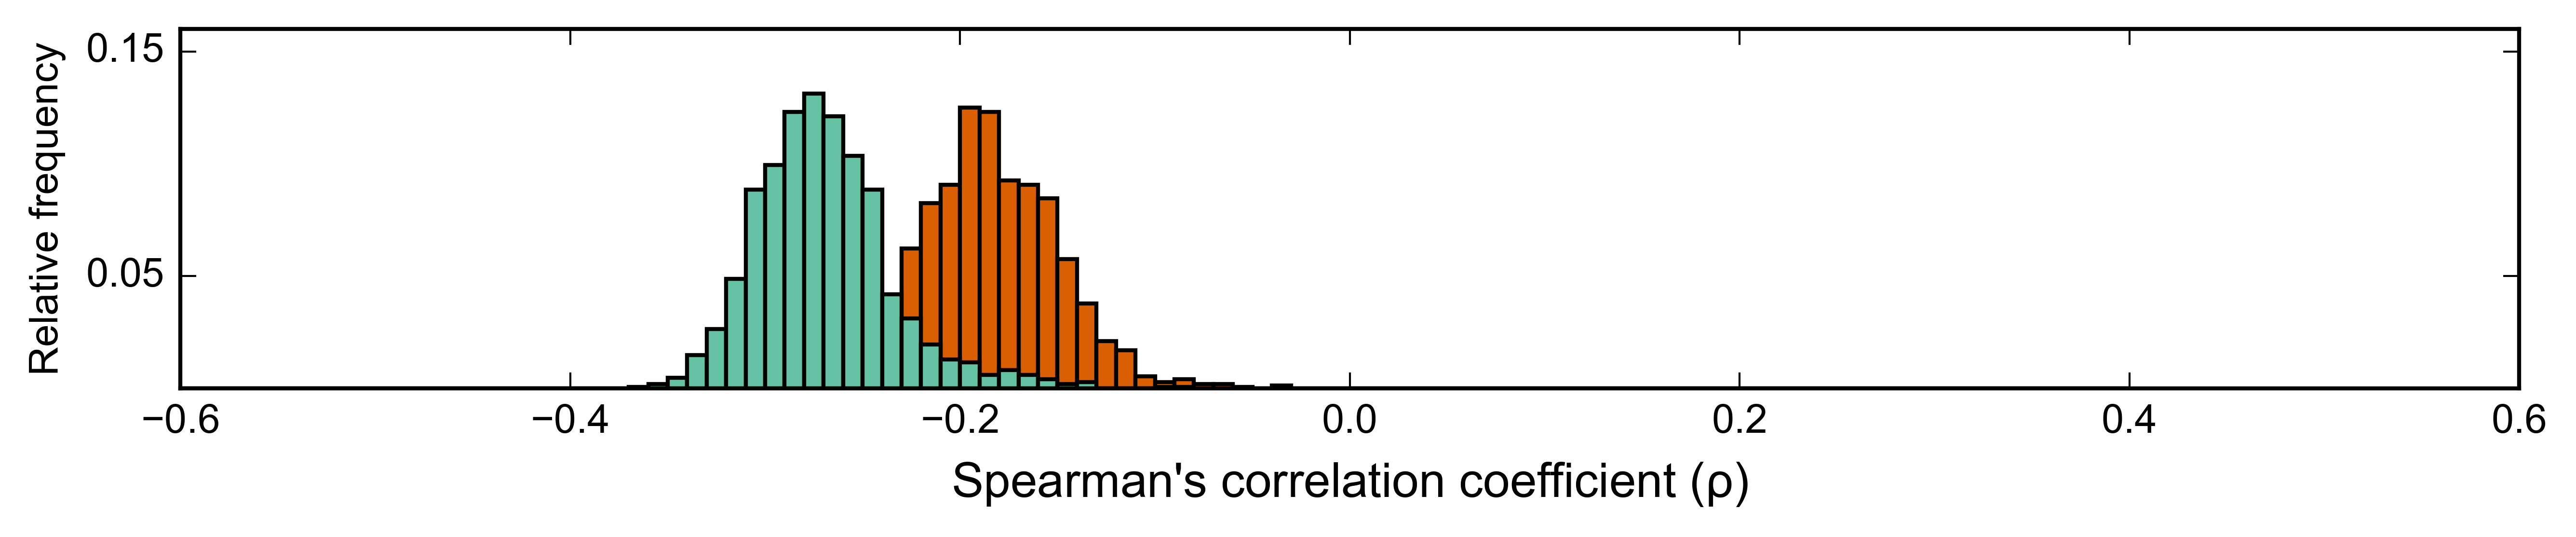

mean rho using gene-loss cost: -0.1853
mean rho using function-loss cost: -0.2700


In [28]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(9, 2)
correlation_histograms(ax, rhosOld, rhosNew)
plt.tight_layout()
plt.savefig(os.path.join(figDir, 'spearmans_correlation_distributions_GLC_vs_FLC.pdf'))
plt.show()
print 'mean rho using gene-loss cost: %.4f' % np.mean(rhosOld)
print 'mean rho using function-loss cost: %.4f' % np.mean(rhosNew)

p-value: 1.86e-240
p-value: 2.76e-242
p-value: 2.92e-243


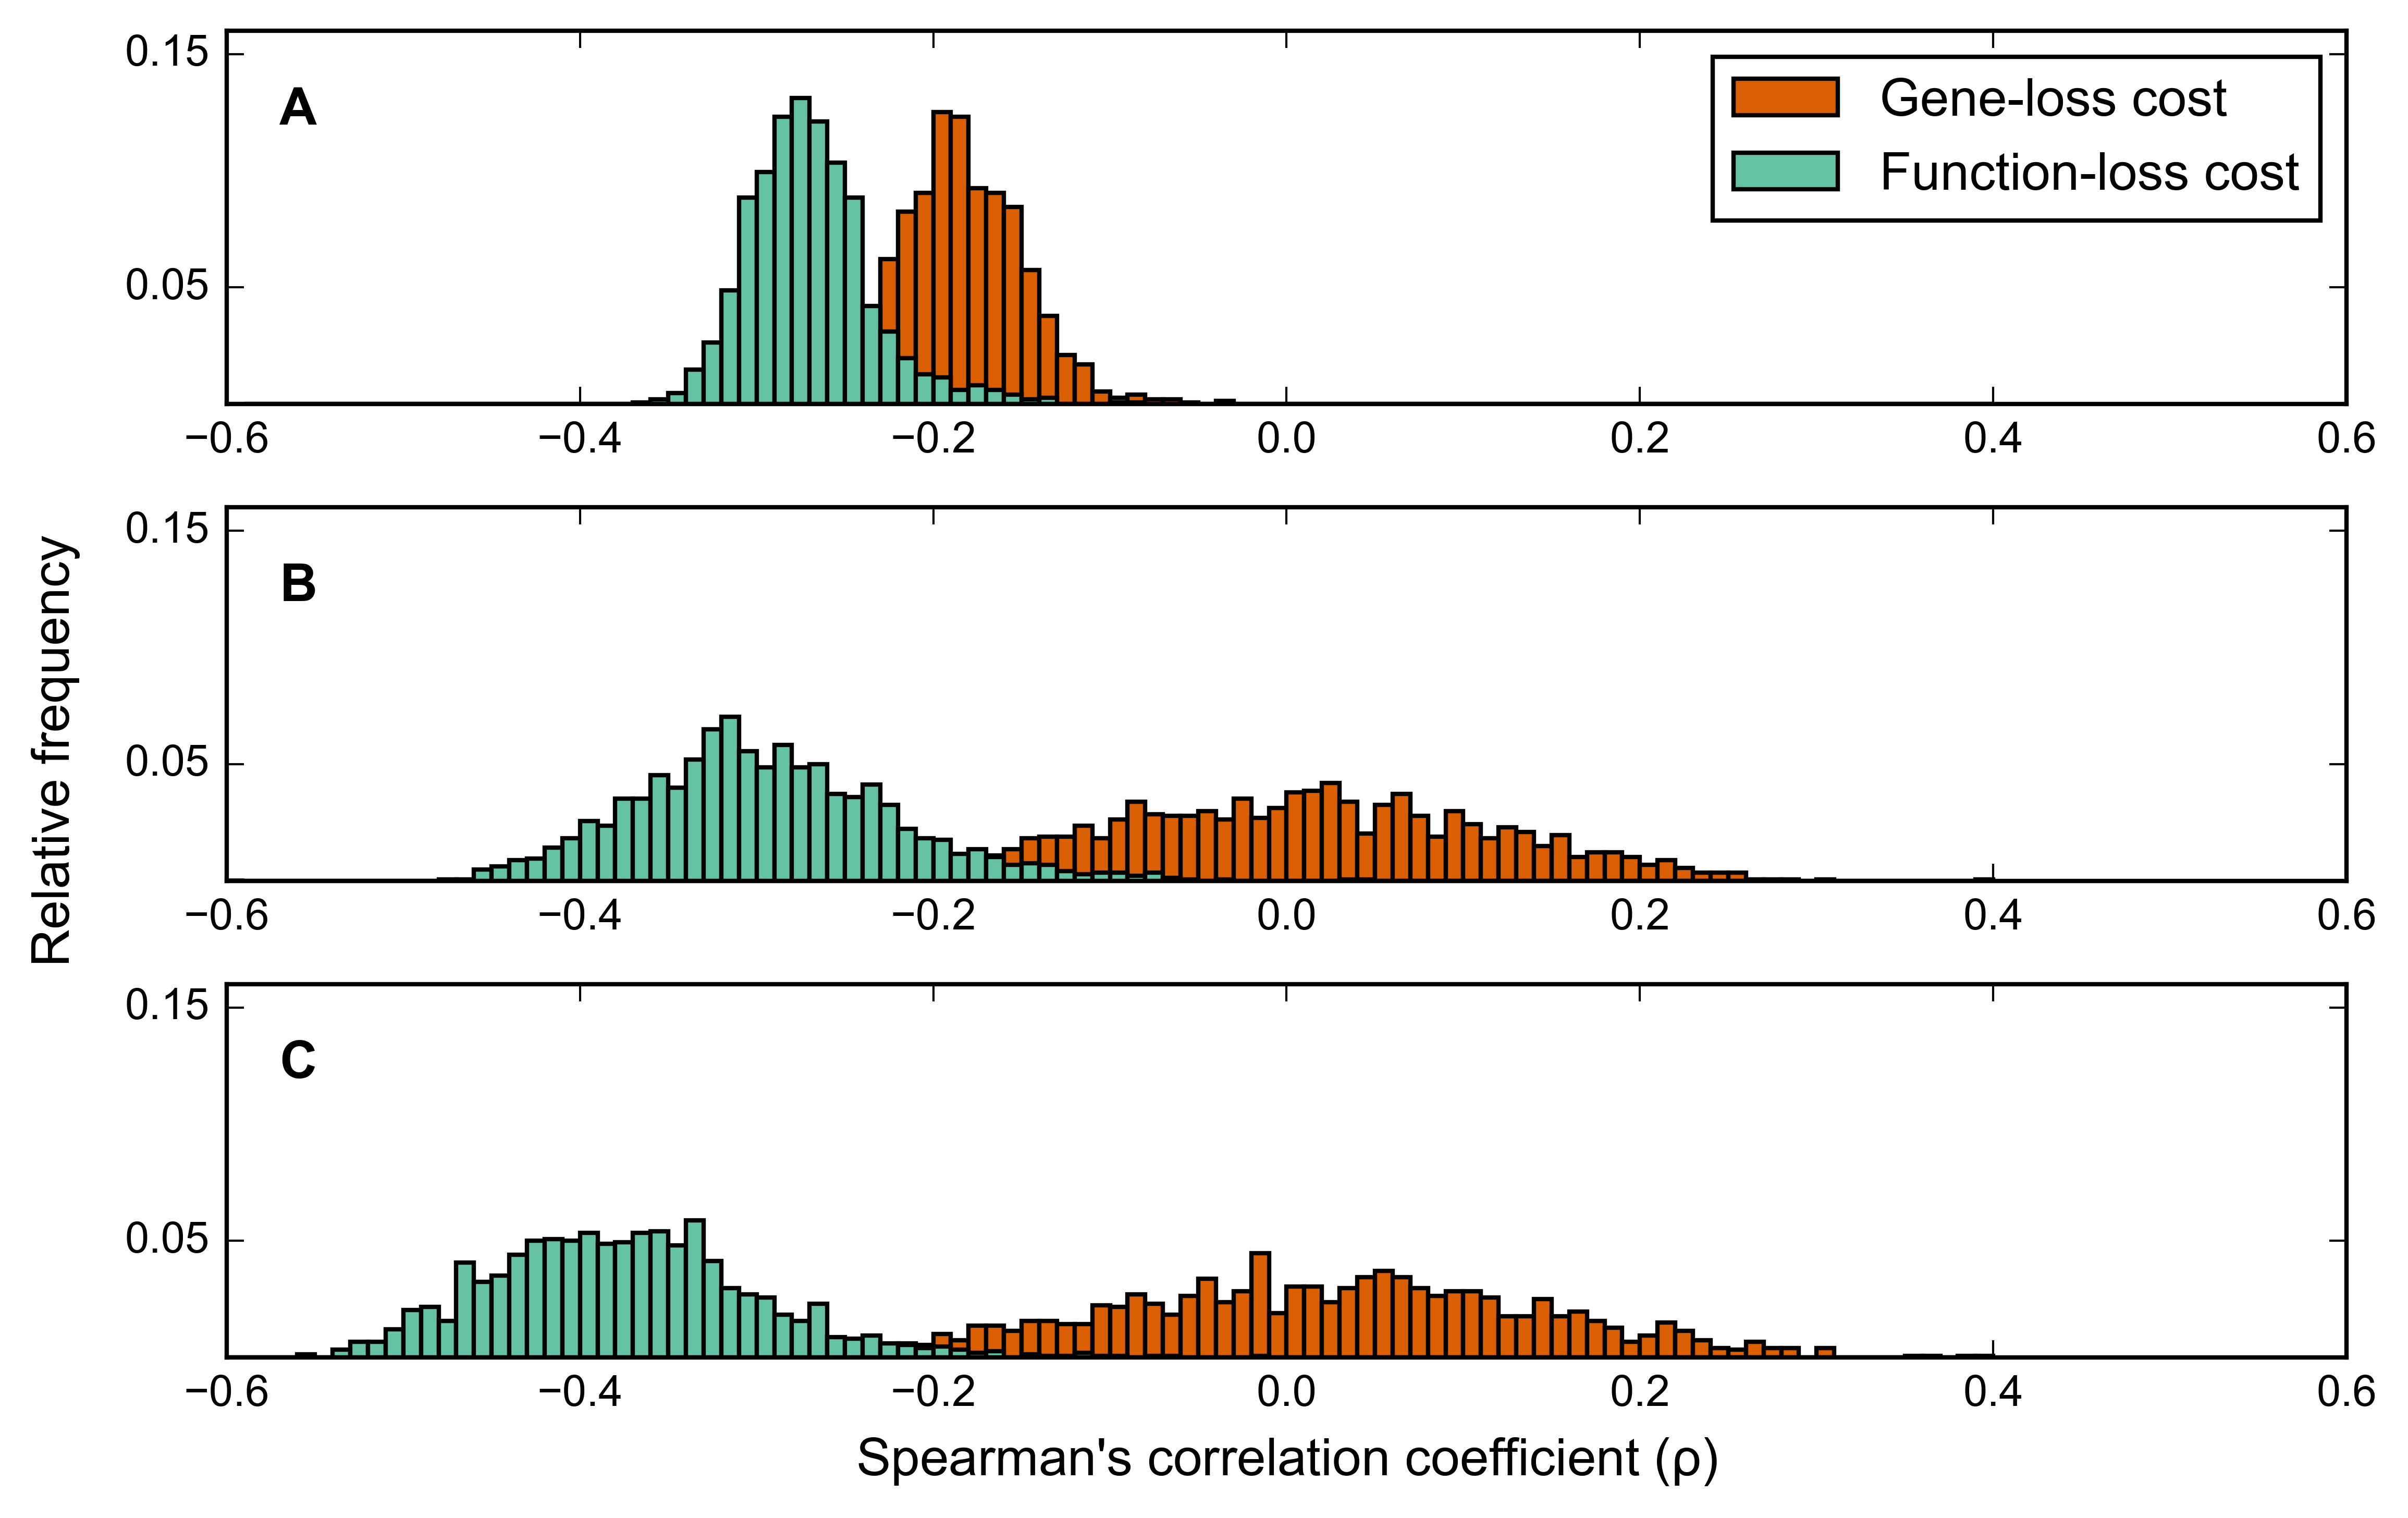

In [29]:
# Figure 2 in the original submission of the manuscript
fig, ax = plt.subplots(3, 1)
fig.set_size_inches(7.5, 5)
correlation_histograms(ax[0], rhosOld, rhosNew, drawLegend=True, 
                        drawXlabel=False, drawYlabel=False)
correlation_histograms(ax[1], rhosGLCFastIso, rhosFLCFastIso, drawXlabel=False, 
                       drawYlabel=False)
correlation_histograms(ax[2], rhosGLCSlowIso, rhosFLCSlowIso, drawYlabel=False)
ax[0].text(-0.57, 0.12, 'A', fontweight='bold', fontsize=12)
ax[1].text(-0.57, 0.12, 'B', fontweight='bold', fontsize=12)
ax[2].text(-0.57, 0.12, 'C', fontweight='bold', fontsize=12)
fig.text(-0.02, 0.51, 'Relative frequency', va='center', rotation='vertical', fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(figDir, 'paper_figure2.pdf'), bbox_inches='tight')
plt.show()

p-value: 1.86e-240
p-value: 6.78e-134
p-value: 2.70e-243
p-value: 1.59e-190


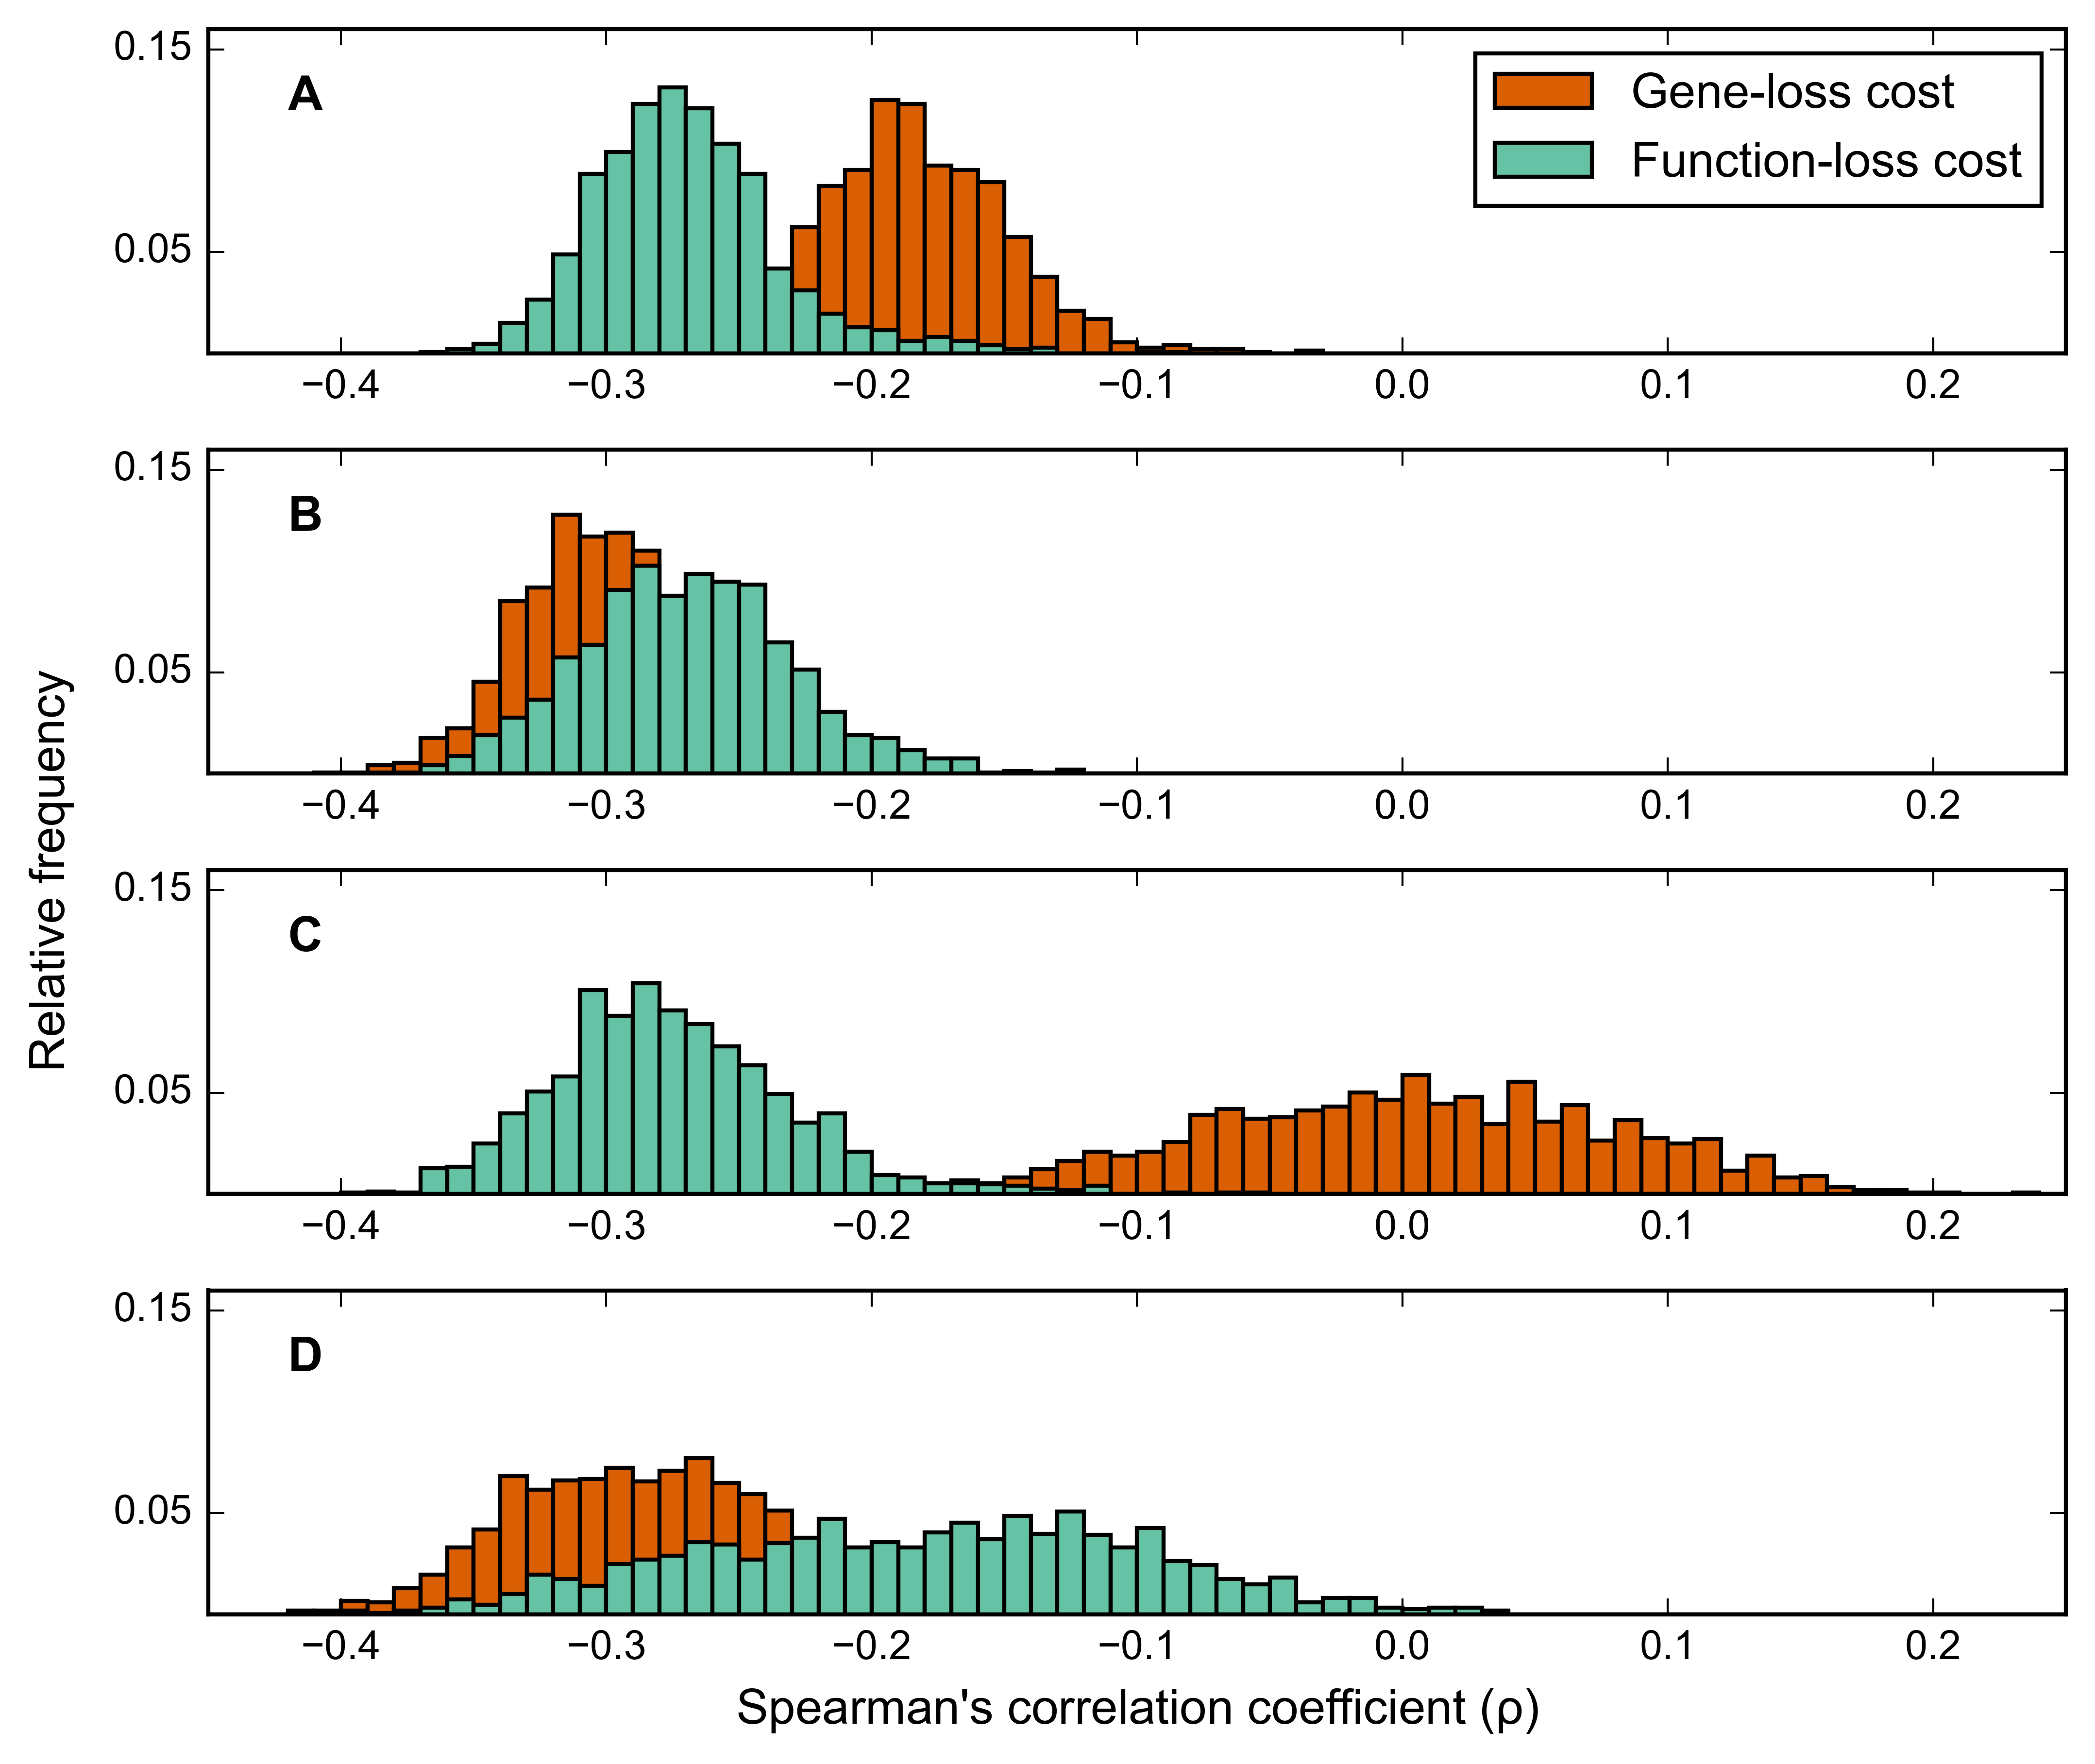

In [30]:
# New figure version of Figure 2
fig, ax = plt.subplots(4, 1)
fig.set_size_inches(7., 6.2)
correlation_histograms(ax[0], rhosOld, rhosNew, drawLegend=True, 
                        drawXlabel=False, drawYlabel=False)
correlation_histograms(ax[1], rhosGLCNoIso, rhosFLCNoIso, 
                        drawXlabel=False, drawYlabel=False)
correlation_histograms(ax[2], rhosGLCIso, rhosFLCIso, drawXlabel=False, 
                       drawYlabel=False)
correlation_histograms(ax[3], rhosGLCMultiNonIso, rhosFLCMultiNonIso, drawYlabel=False)
xmin = -0.45
ax[0].text(xmin + 0.03, 0.12, 'A', fontweight='bold', fontsize=12)
ax[1].text(xmin + 0.03, 0.12, 'B', fontweight='bold', fontsize=12)
ax[2].text(xmin + 0.03, 0.12, 'C', fontweight='bold', fontsize=12)
ax[3].text(xmin + 0.03, 0.12, 'D', fontweight='bold', fontsize=12)
for subAxes in ax:
    subAxes.set_xlim((xmin, 0.25))
fig.text(-0.02, 0.51, 'Relative frequency', va='center', rotation='vertical', fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(figDir, 'latest_revision_figure2.pdf'), bbox_inches='tight')
plt.savefig(os.path.join(figDir, 'latest_revision_figure2.svg'), bbox_inches='tight')
plt.savefig(os.path.join(figDir, 'latest_revision_figure2.eps'), bbox_inches='tight')
plt.show()

In [31]:
# a few tests for significance
print 'mean rho for GLC: %.4f' % np.mean(rhosOld)
print 'mean rho for FLC: %.4f' % np.mean(rhosOld)
print 'mean rho for GLC no isoenzymes: %.4f' % np.mean(rhosGLCNoIso)
print 'mean rho for FLC no isoenzymes: %.4f' % np.mean(rhosFLCNoIso)
print 'mean rho for GLC only isoenzymes: %.4f' % np.mean(rhosGLCIso)
print 'mean rho for FLC only isoenzymes: %.4f' % np.mean(rhosFLCIso)
print 'mean rho for GLC only multifunctional, non-isoenzymes: %.4f' % np.mean(rhosGLCMultiNonIso)
print 'mean rho for FLC only multifunctoinal, non-isoenzymes: %.4f' % np.mean(rhosFLCMultiNonIso)
print wilcoxon(rhosOld, rhosGLCNoIso)[1]
print wilcoxon(rhosNew, rhosFLCMultiNonIso)[1]

mean rho for GLC: -0.1853
mean rho for FLC: -0.1853
mean rho for GLC no isoenzymes: -0.2991
mean rho for FLC no isoenzymes: -0.2697
mean rho for GLC only isoenzymes: 0.0029
mean rho for FLC only isoenzymes: -0.2751
mean rho for GLC only multifunctional, non-isoenzymes: -0.2825
mean rho for FLC only multifunctoinal, non-isoenzymes: -0.1808
2.6783221821e-243
6.89663896597e-199


In [32]:
print 'mean rho for fast evolving isoenzymes: %.2f' % np.mean(rhosFLCFastIso)
print 'mean rho for slow evolving isoenzymes: %.2f' % np.mean(rhosFLCSlowIso)
print 'p-value: %.2e' % wilcoxon(rhosFLCSlowIso, rhosFLCFastIso)[1]

mean rho for fast evolving isoenzymes: -0.30
mean rho for slow evolving isoenzymes: -0.38
p-value: 3.52e-230


p-value: 2.76e-242
p-value: 2.92e-243


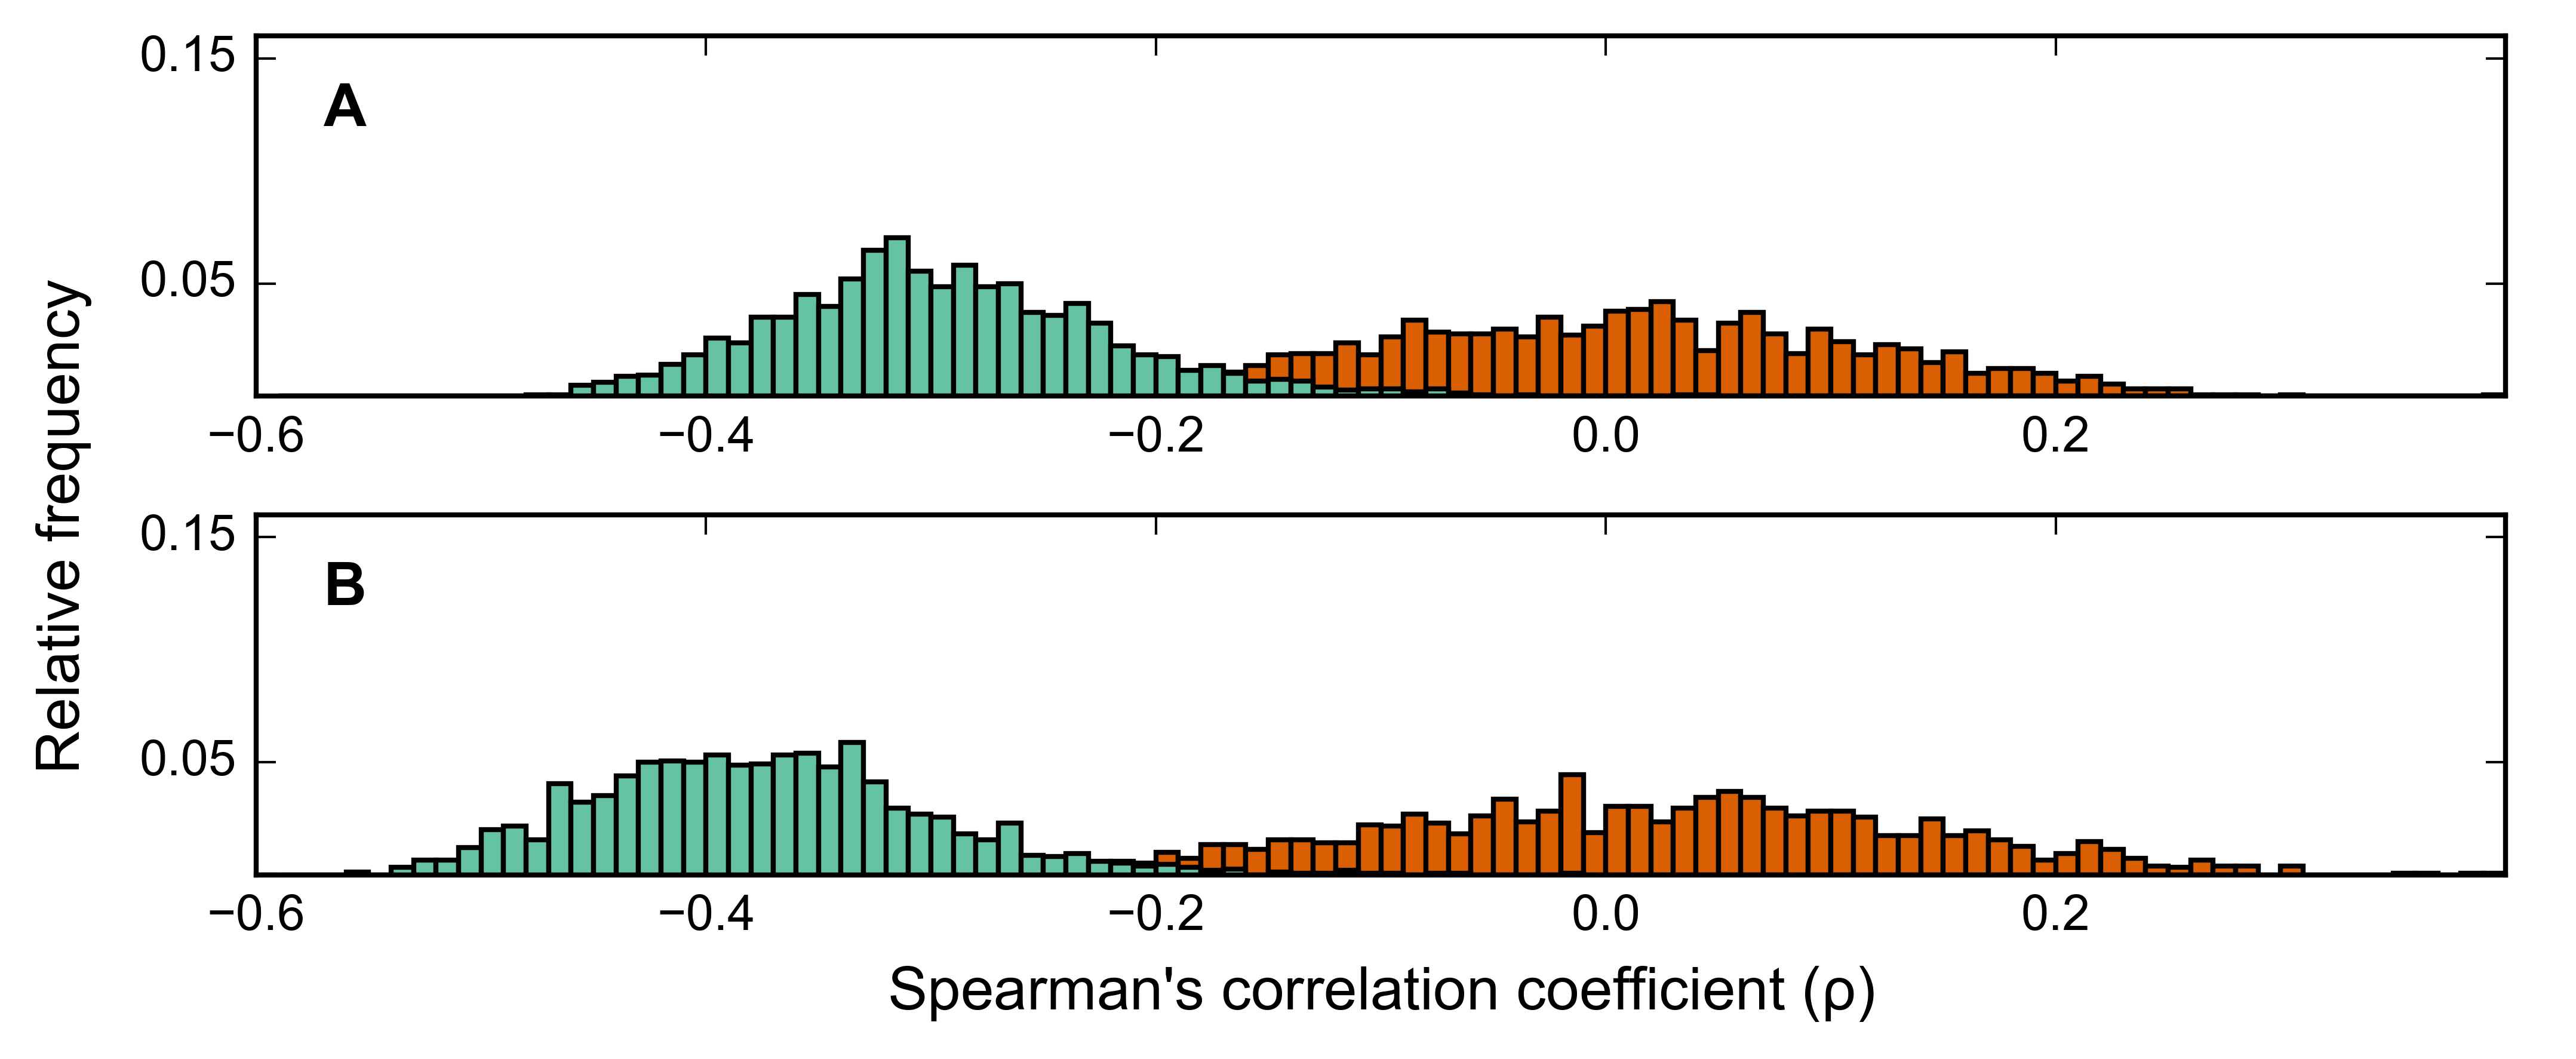

In [33]:
# New version of figure 3
fig, ax = plt.subplots(2, 1)
fig.set_size_inches(7., 3.1)
correlation_histograms(ax[0], rhosGLCFastIso, rhosFLCFastIso, drawXlabel=False, 
                       drawYlabel=False)
correlation_histograms(ax[1], rhosGLCSlowIso, rhosFLCSlowIso, drawYlabel=False)
ax[0].text(-0.57, 0.12, 'A', fontweight='bold', fontsize=12)
ax[1].text(-0.57, 0.12, 'B', fontweight='bold', fontsize=12)
for subAxes in ax:
    subAxes.set_xlim((-0.60001, 0.4))
fig.text(-0.02, 0.51, 'Relative frequency', va='center', rotation='vertical', fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(figDir, 'latest_revision_figure3.pdf'), bbox_inches='tight')
plt.savefig(os.path.join(figDir, 'latest_revision_figure3.eps'), bbox_inches='tight')
plt.savefig(os.path.join(figDir, 'latest_revision_figure3.svg'), bbox_inches='tight')
plt.show()

In [34]:
print np.mean(rhosGLCFastIso)
print np.mean(rhosFLCFastIso)
print np.mean(rhosGLCSlowIso)
print np.mean(rhosFLCSlowIso)
print wilcoxon(rhosNew, rhosFLCSlowIso)[1]
print wilcoxon(rhosFLCFastIso, rhosFLCSlowIso)[1]

0.00150108769839
-0.29535254266
0.0192825575906
-0.375136441931
1.63682757414e-236
3.5241855244e-230


p-value: 1.86e-240


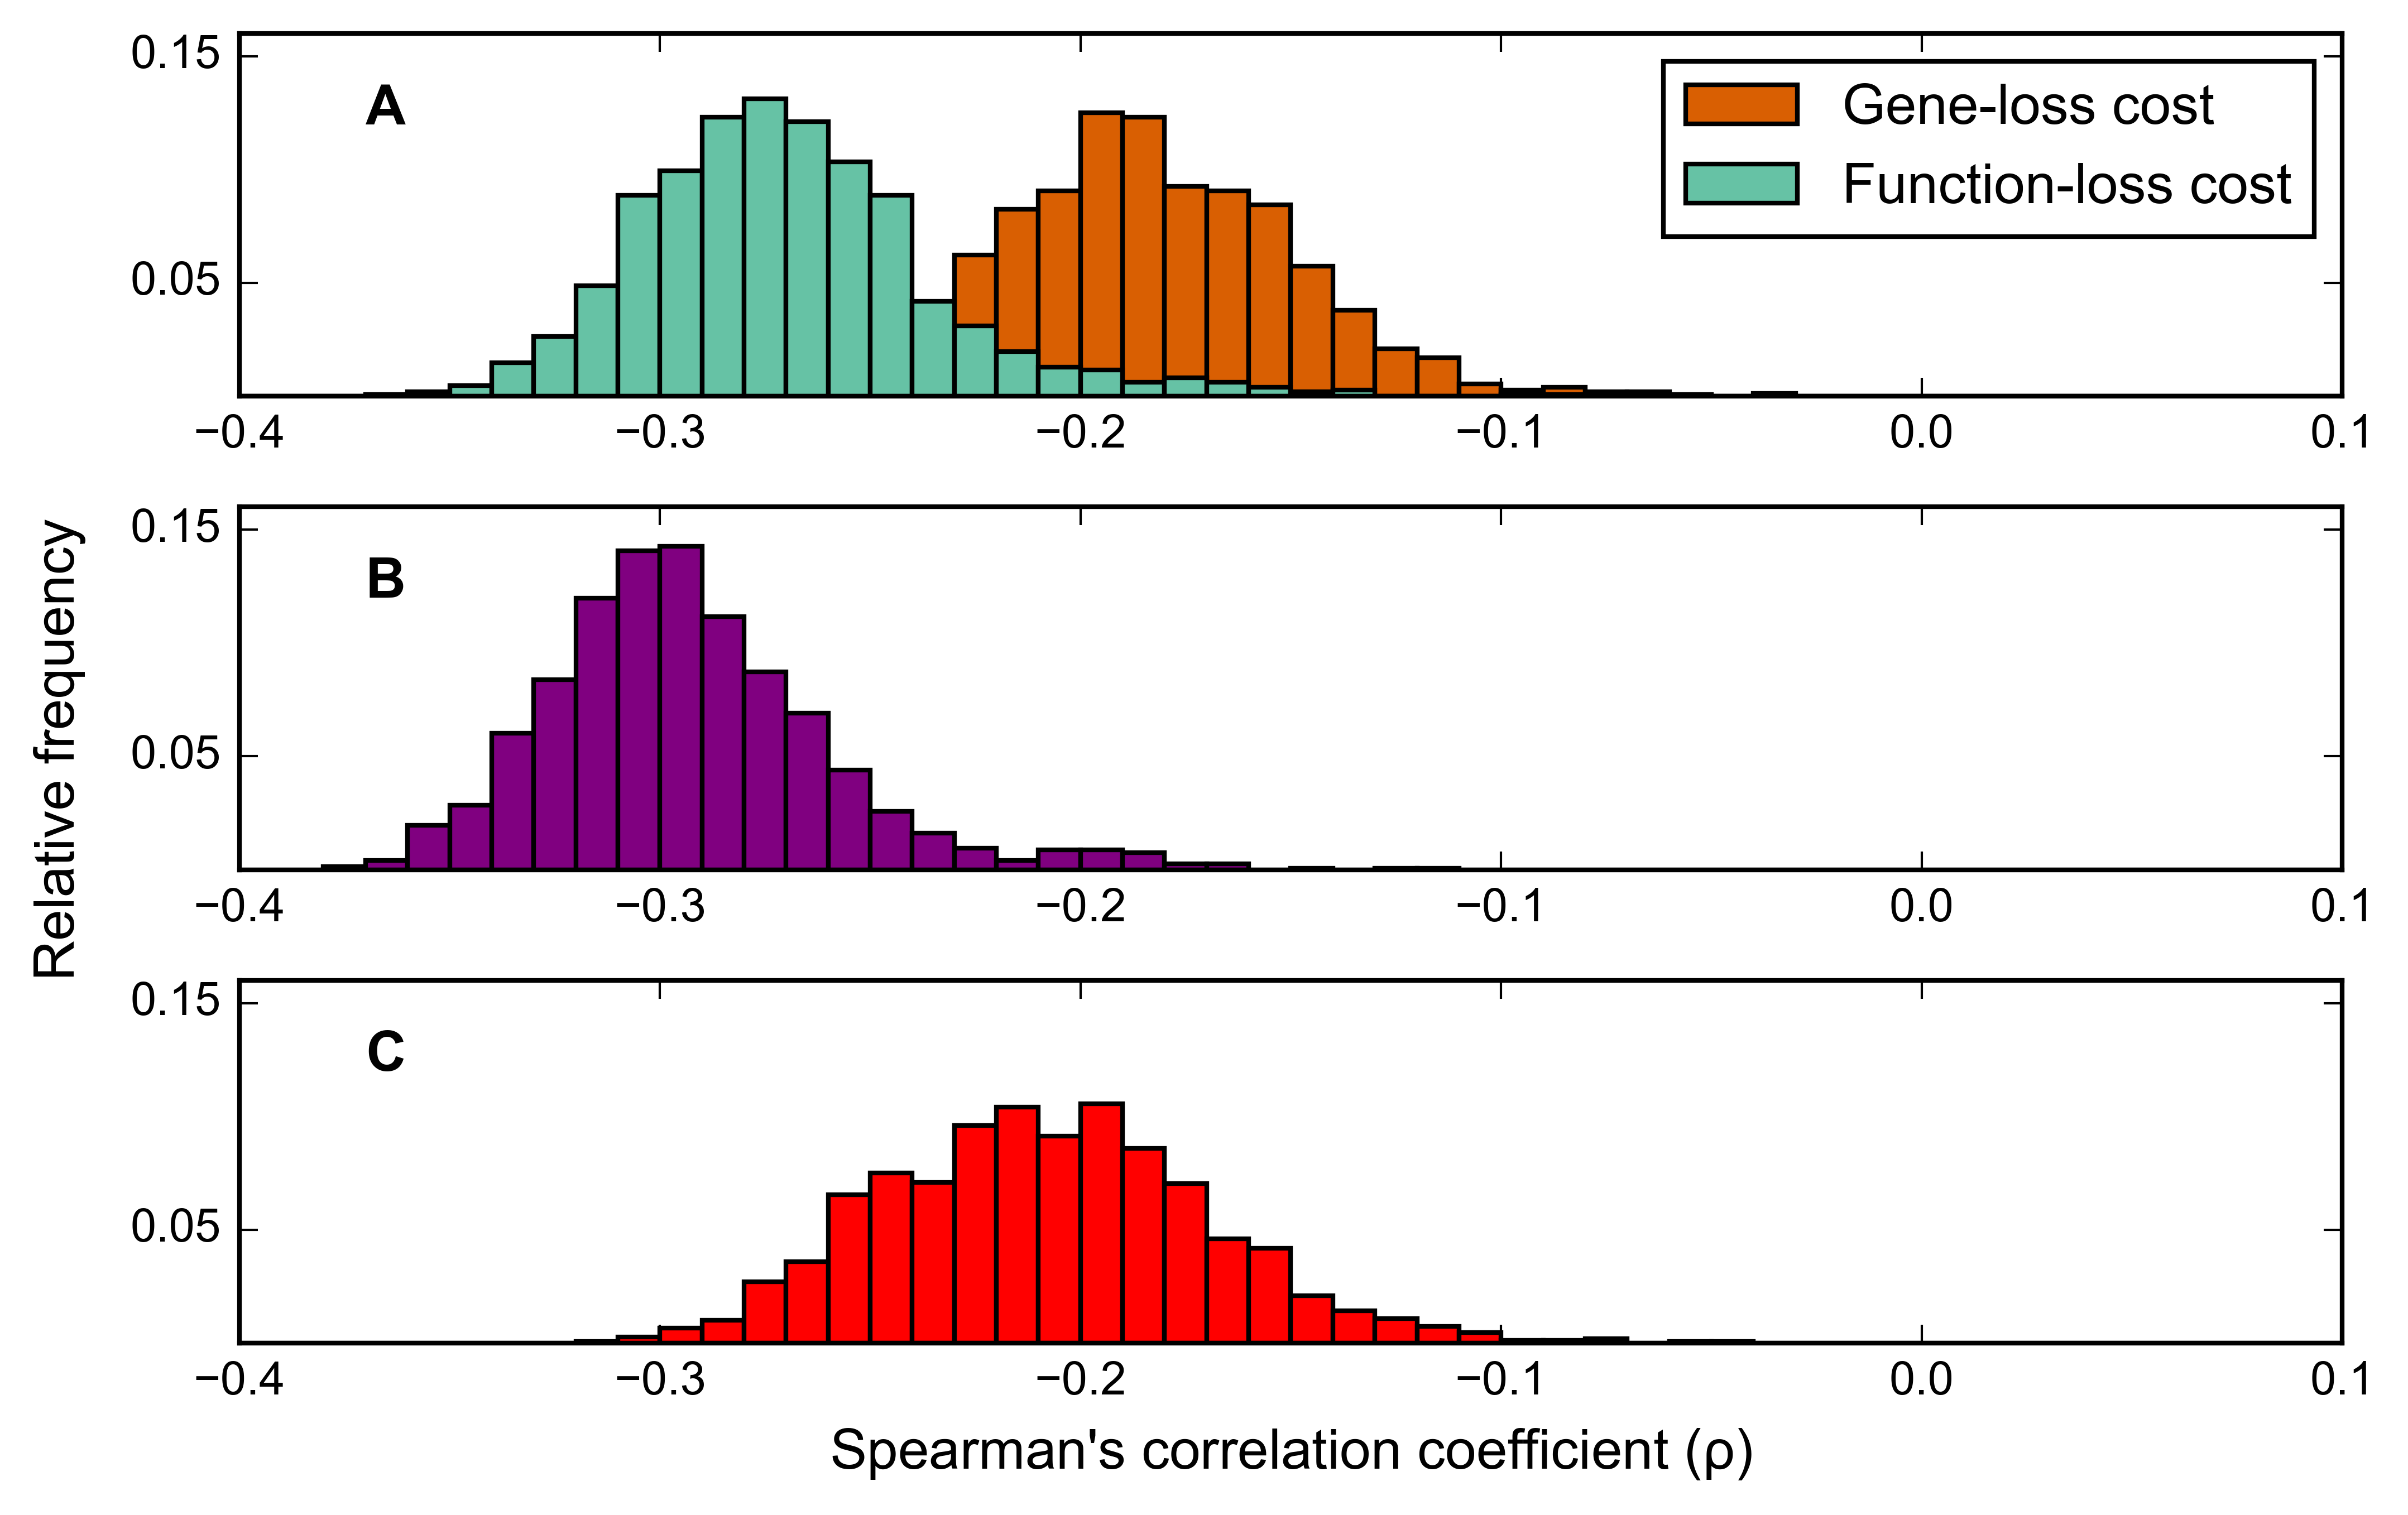

In [35]:
# Currently Figure S2 in the manuscript
fig, ax = plt.subplots(3, 1)
fig.set_size_inches(7., 4.67)
correlation_histograms(ax[0], rhosOld, rhosNew, drawLegend=True, 
                        drawXlabel=False, drawYlabel=False)
correlation_histograms(ax[1], rhosHybrid2, [], drawXlabel=False, 
                       drawYlabel=False, colorA='purple')
correlation_histograms(ax[2], rhosHybrid1, [], drawYlabel=False,
                       colorA='red')
ax[0].text(-0.37, 0.12, 'A', fontweight='bold', fontsize=12)
ax[1].text(-0.37, 0.12, 'B', fontweight='bold', fontsize=12)
ax[2].text(-0.37, 0.12, 'C', fontweight='bold', fontsize=12)
fig.text(-0.02, 0.51, 'Relative frequency', va='center', rotation='vertical', fontsize=12)
for subAxes in ax:
    subAxes.set_xlim((-0.4, 0.1))
plt.tight_layout()
plt.savefig(os.path.join(figDir, 'paper_figureS2.pdf'), bbox_inches='tight')
plt.savefig(os.path.join(figDir, 'paper_figureS2.eps'), bbox_inches='tight')
plt.savefig(os.path.join(figDir, 'paper_figureS2.svg'), bbox_inches='tight')
plt.show()

p-value: 1.86e-240
p-value: 5.43e-242


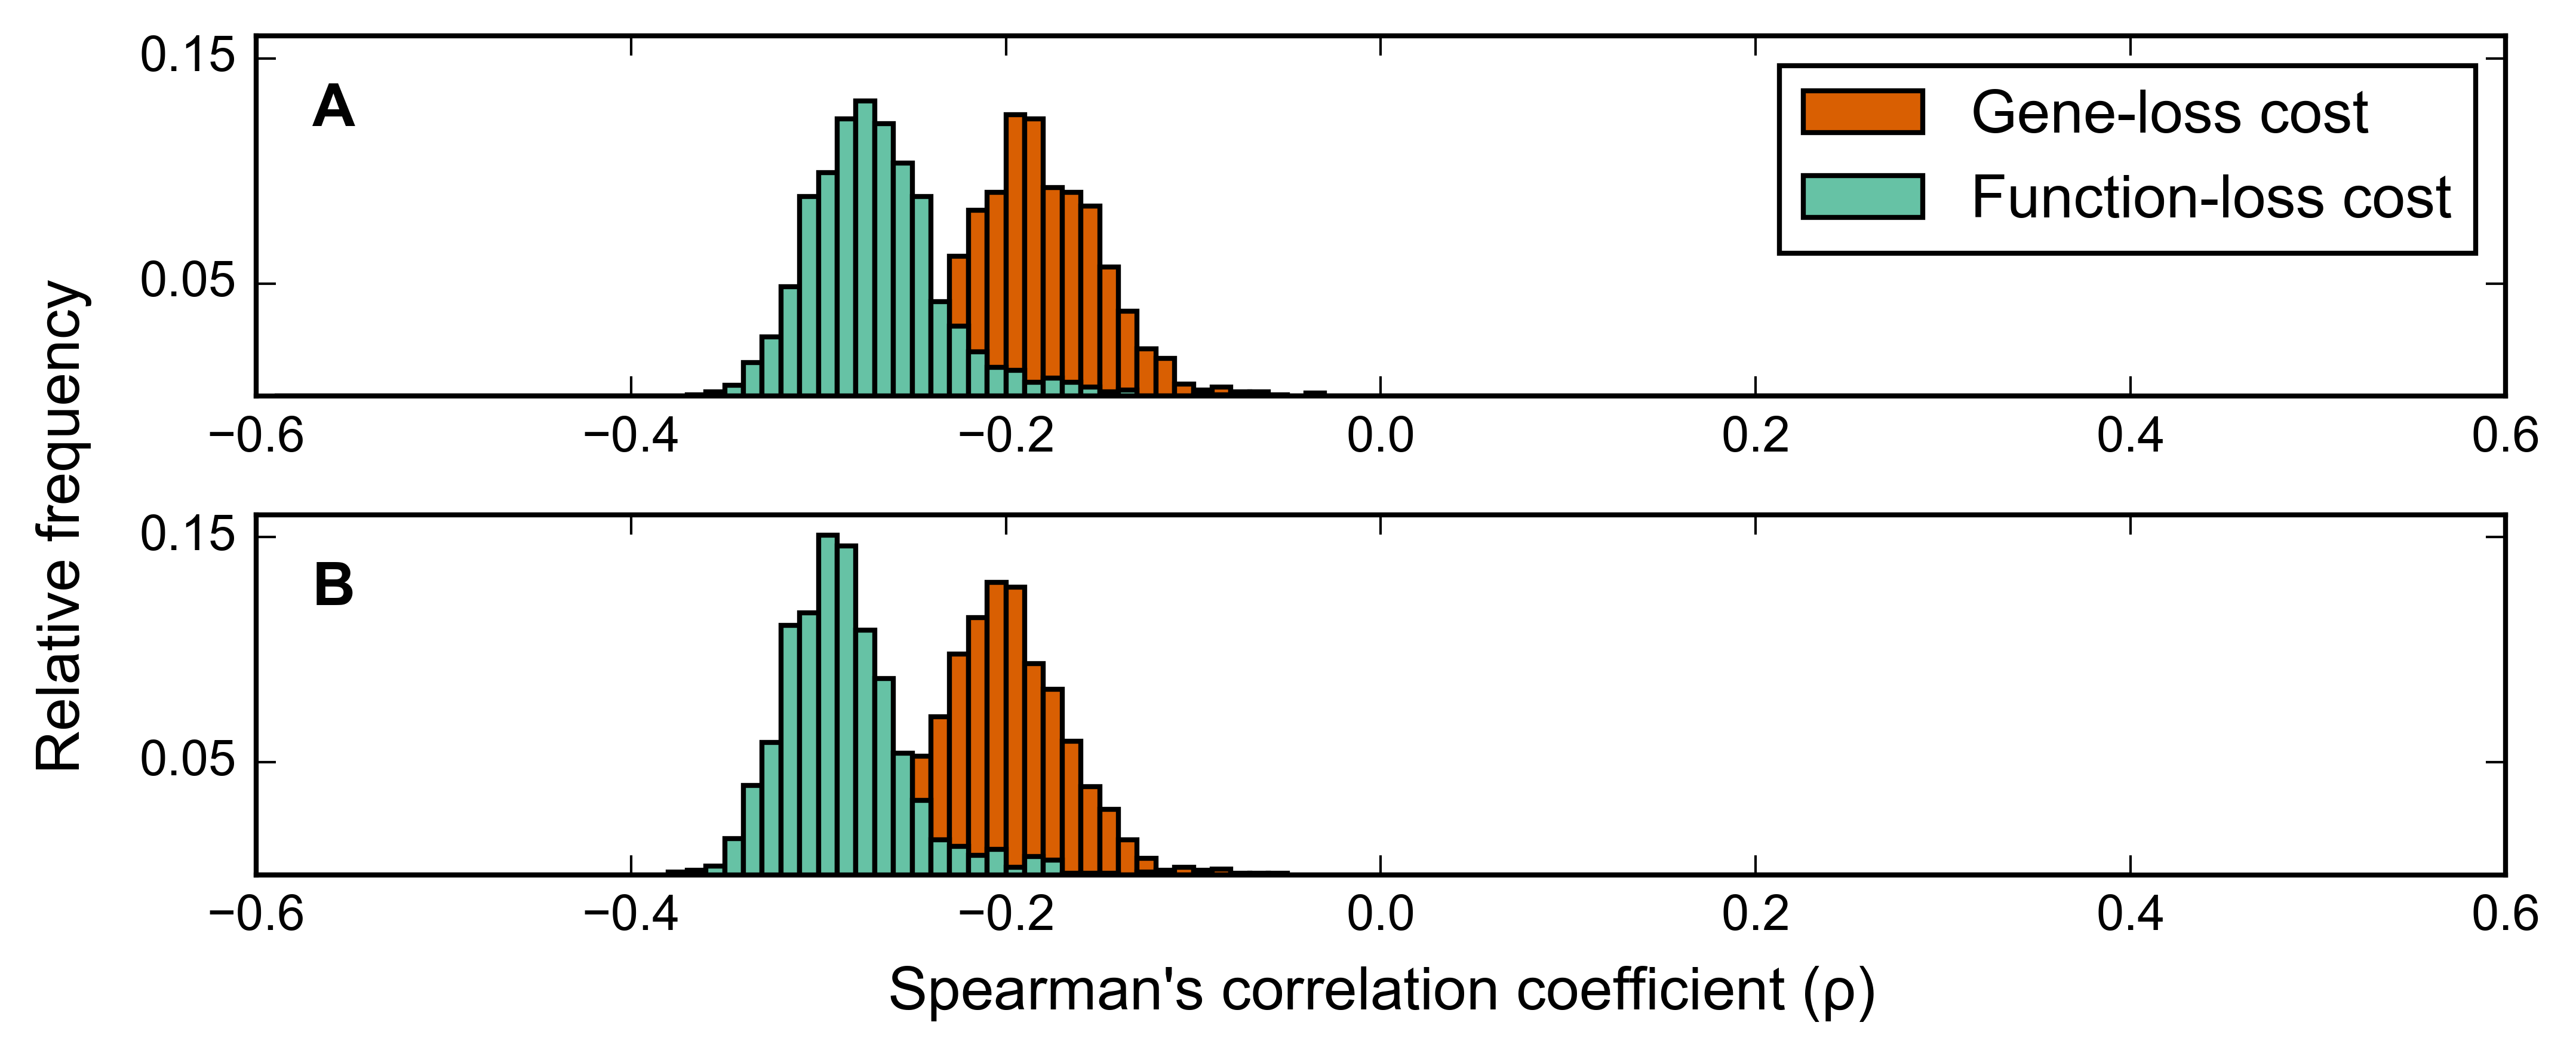

In [36]:
# Currently Figure S4 in the manuscript
fig, ax = plt.subplots(2, 1)
fig.set_size_inches(7, 3.1)
correlation_histograms(ax[0], rhosOld, rhosNew, drawLegend=True, 
                        drawXlabel=False, drawYlabel=False)
correlation_histograms(ax[1], rhosGLCWithBlocked, rhosFLCWithBlocked, drawYlabel=False)
ax[0].text(-0.57, 0.12, 'A', fontweight='bold', fontsize=12)
ax[1].text(-0.57, 0.12, 'B', fontweight='bold', fontsize=12)
fig.text(-0.02, 0.51, 'Relative frequency', va='center', rotation='vertical', fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(figDir, 'paper_figureS4.pdf'), bbox_inches='tight')
plt.savefig(os.path.join(figDir, 'paper_figureS4.eps'), bbox_inches='tight')
plt.savefig(os.path.join(figDir, 'paper_figureS4.svg'), bbox_inches='tight')
plt.show()

p-value: 2.22e-240


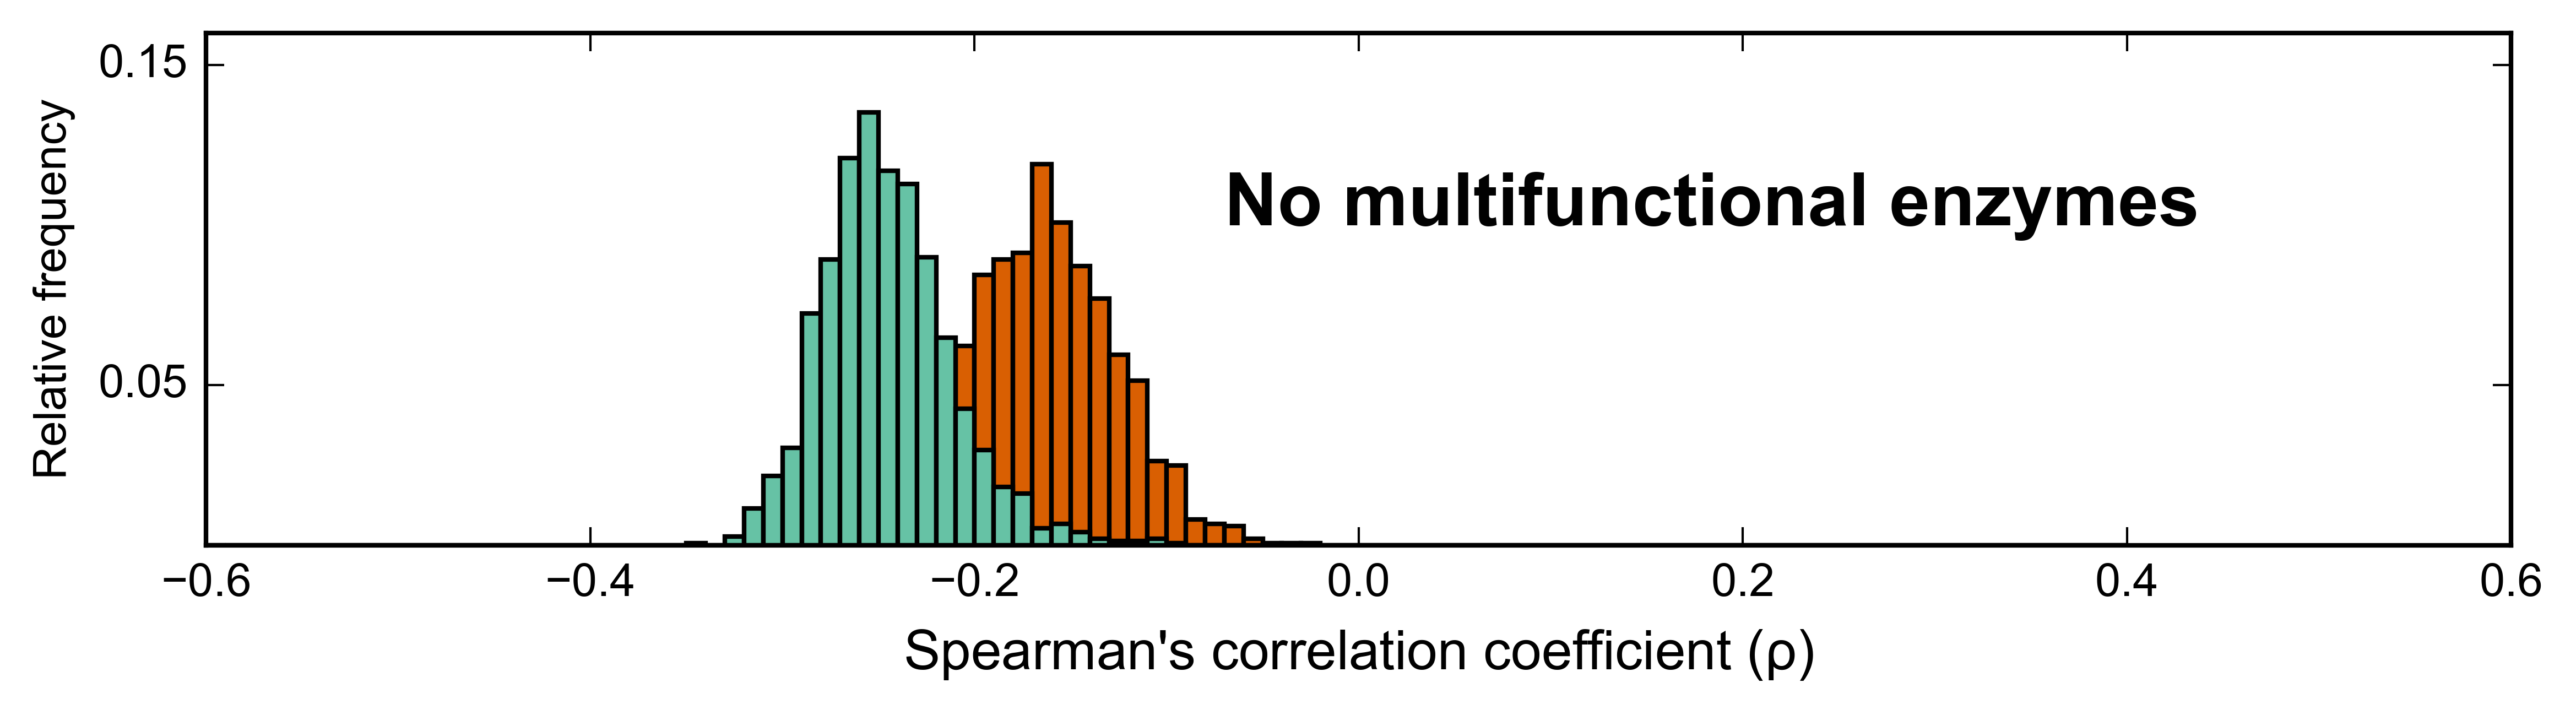

In [37]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(9, 2)
correlation_histograms(ax, rhosGLCNoMulti, rhosFLCNoMulti, 'No multifunctional enzymes')

p-value: 1.90e-102


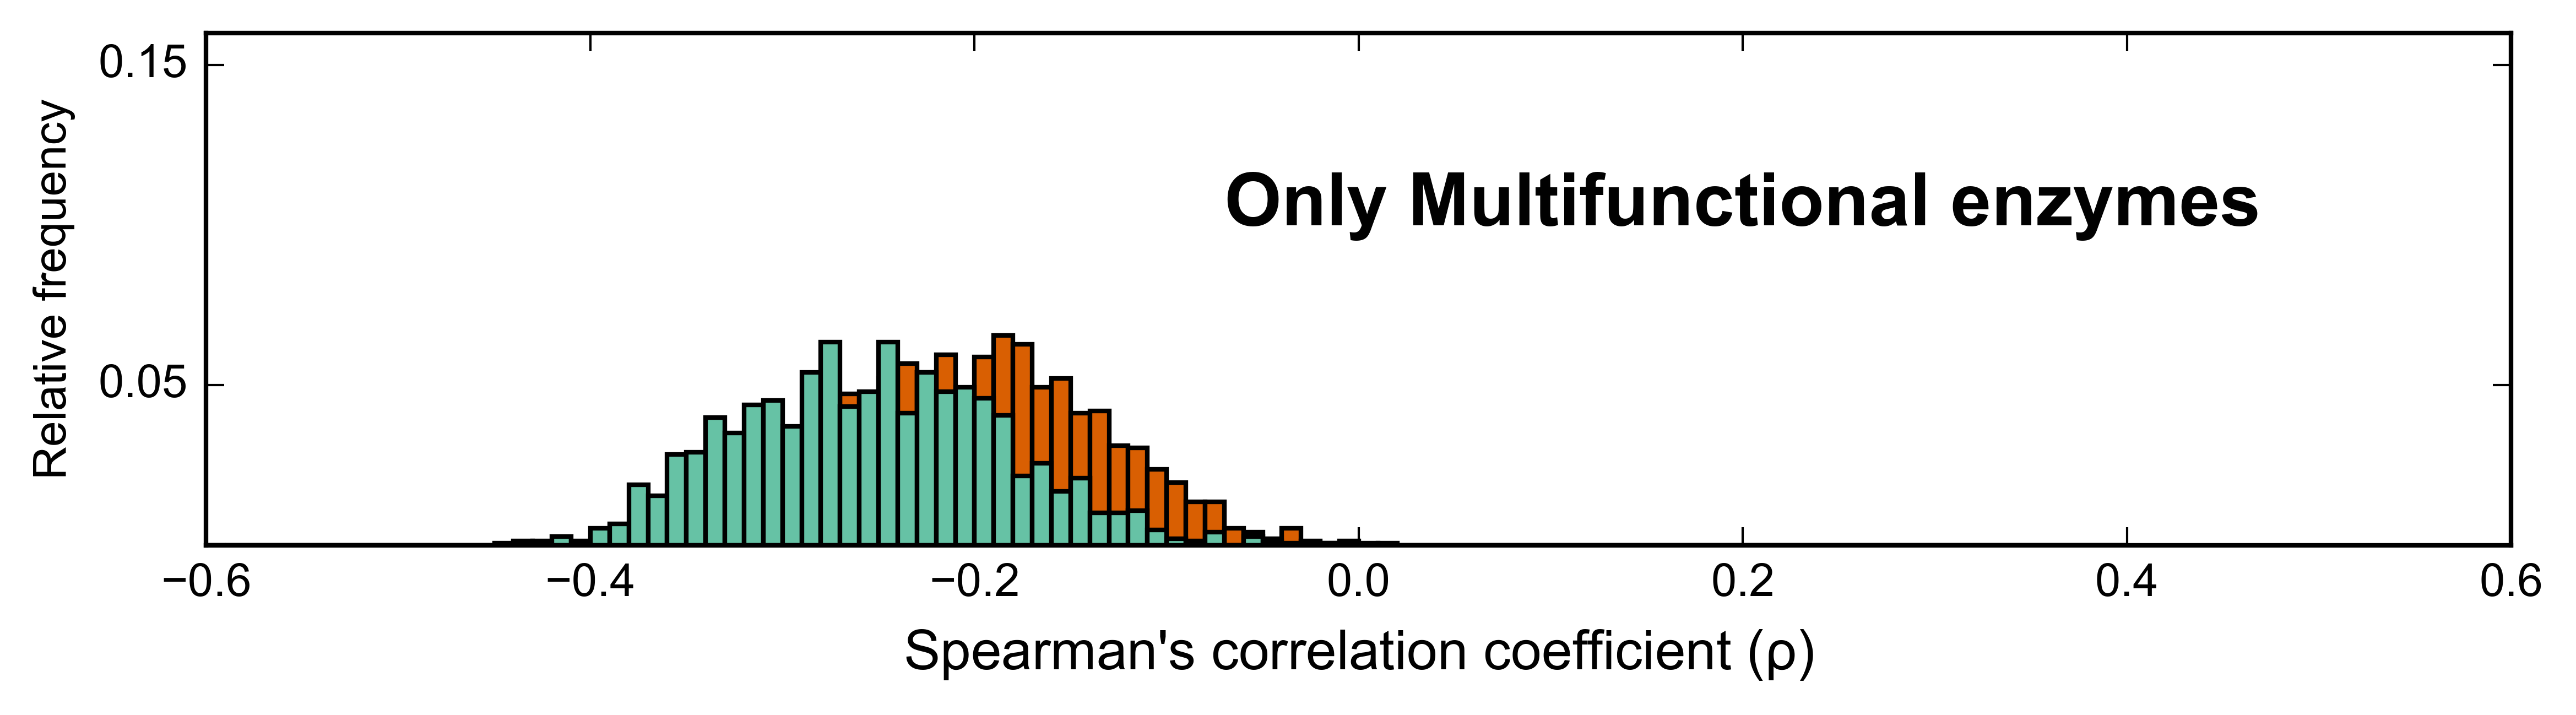

In [38]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(9, 2)
correlation_histograms(ax, rhosGLCMulti, rhosFLCMulti, 'Only Multifunctional enzymes')

p-value: 1.59e-190


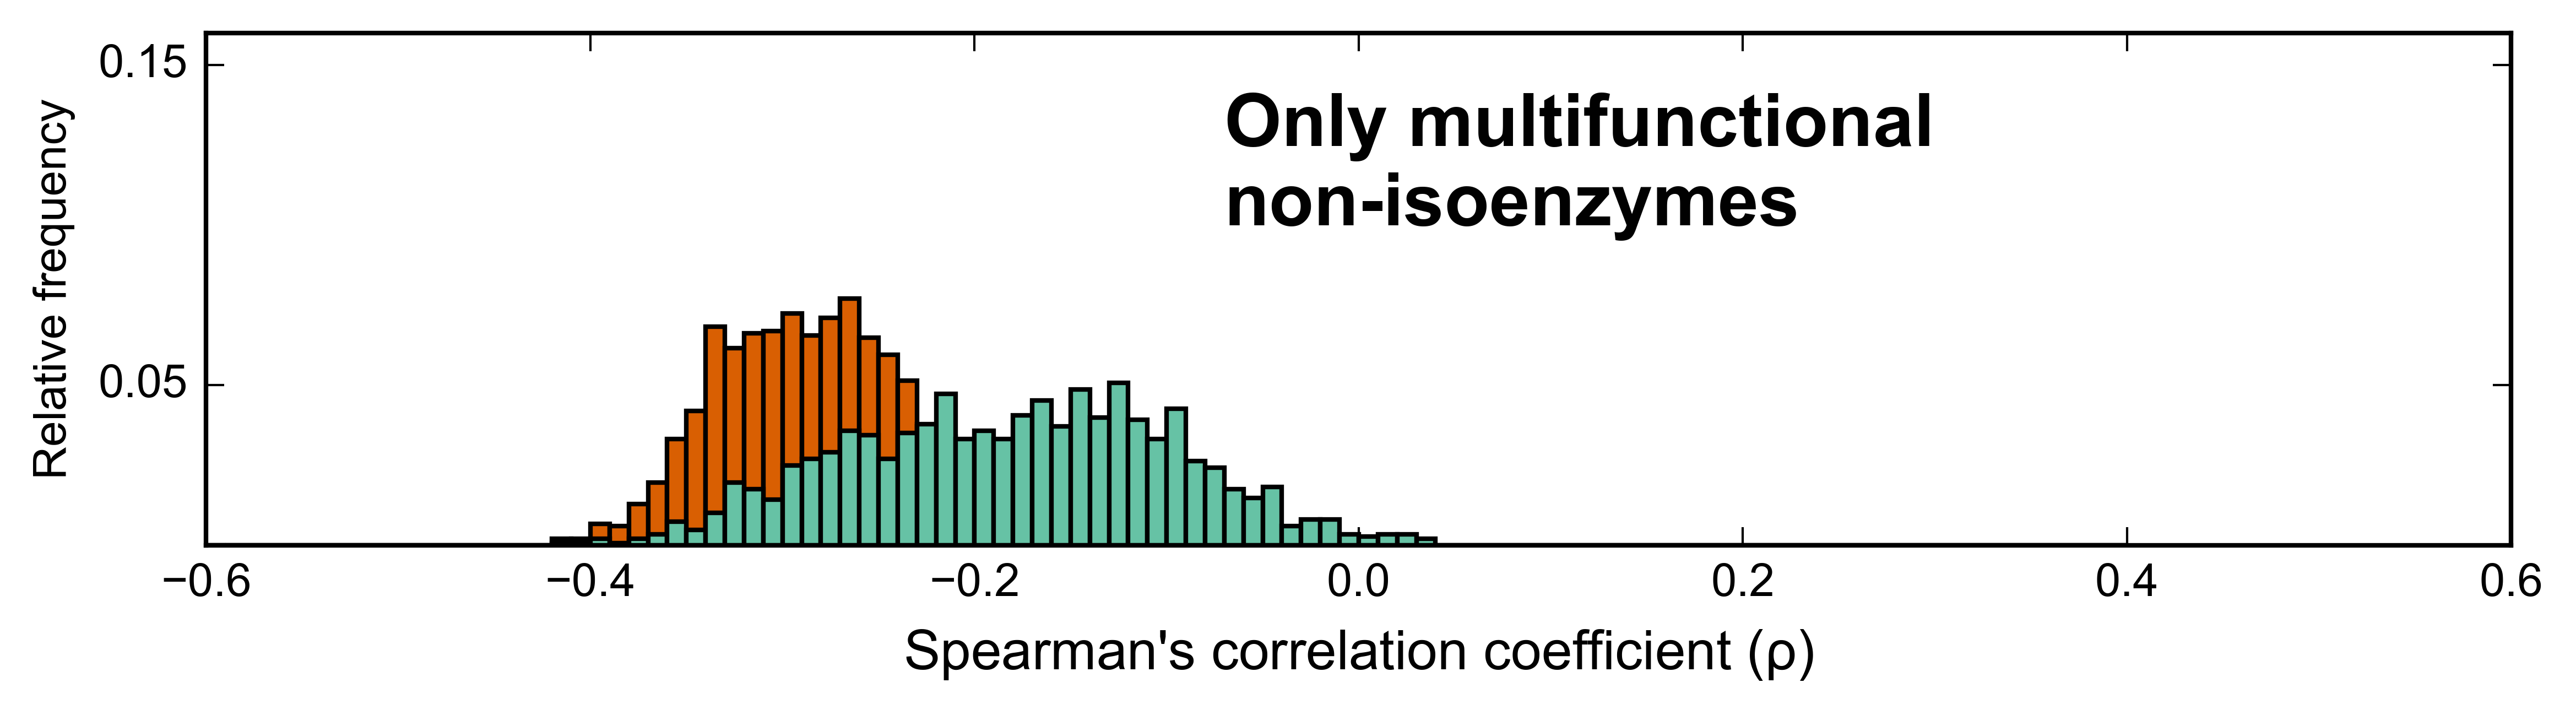

In [39]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(9, 2)
correlation_histograms(ax, rhosGLCMultiNonIso, rhosFLCMultiNonIso, 'Only multifunctional\nnon-isoenzymes')

p-value: 6.78e-134


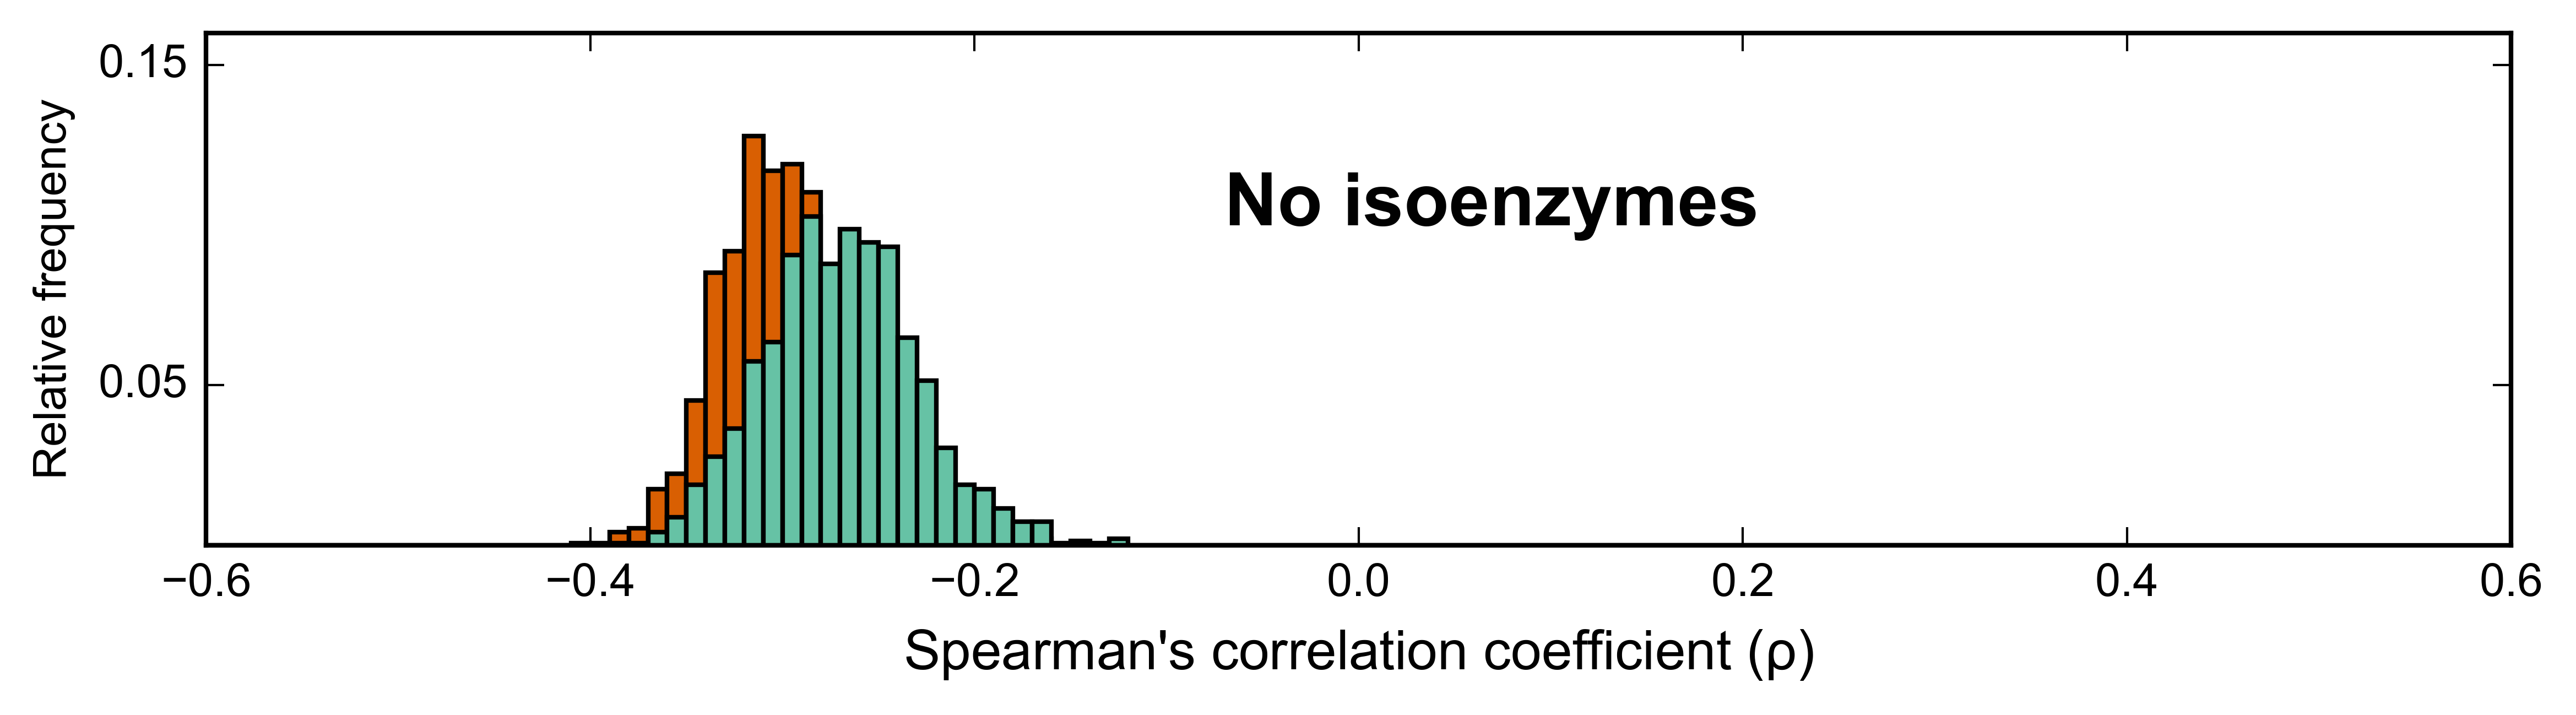

In [40]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(9, 2)
correlation_histograms(ax, rhosGLCNoIso, rhosFLCNoIso, 'No isoenzymes')

p-value: 2.70e-243


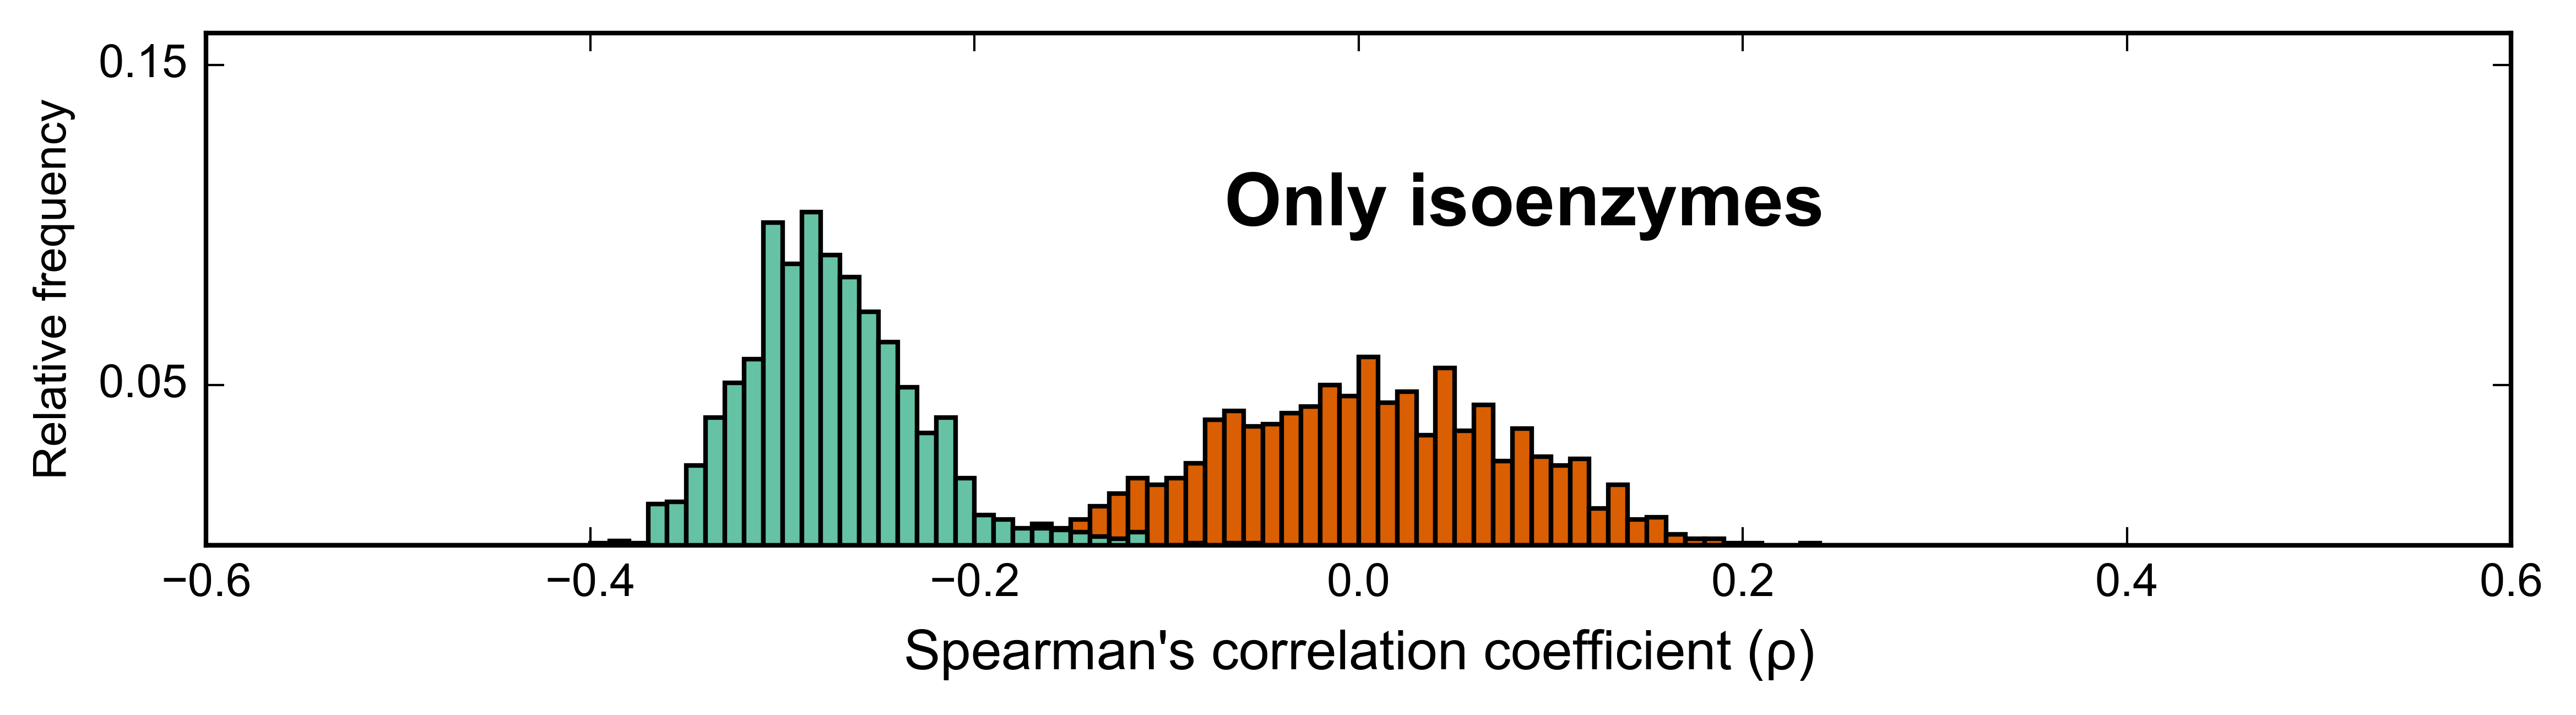

In [41]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(9, 2)
correlation_histograms(ax, rhosGLCIso, rhosFLCIso, 'Only isoenzymes')

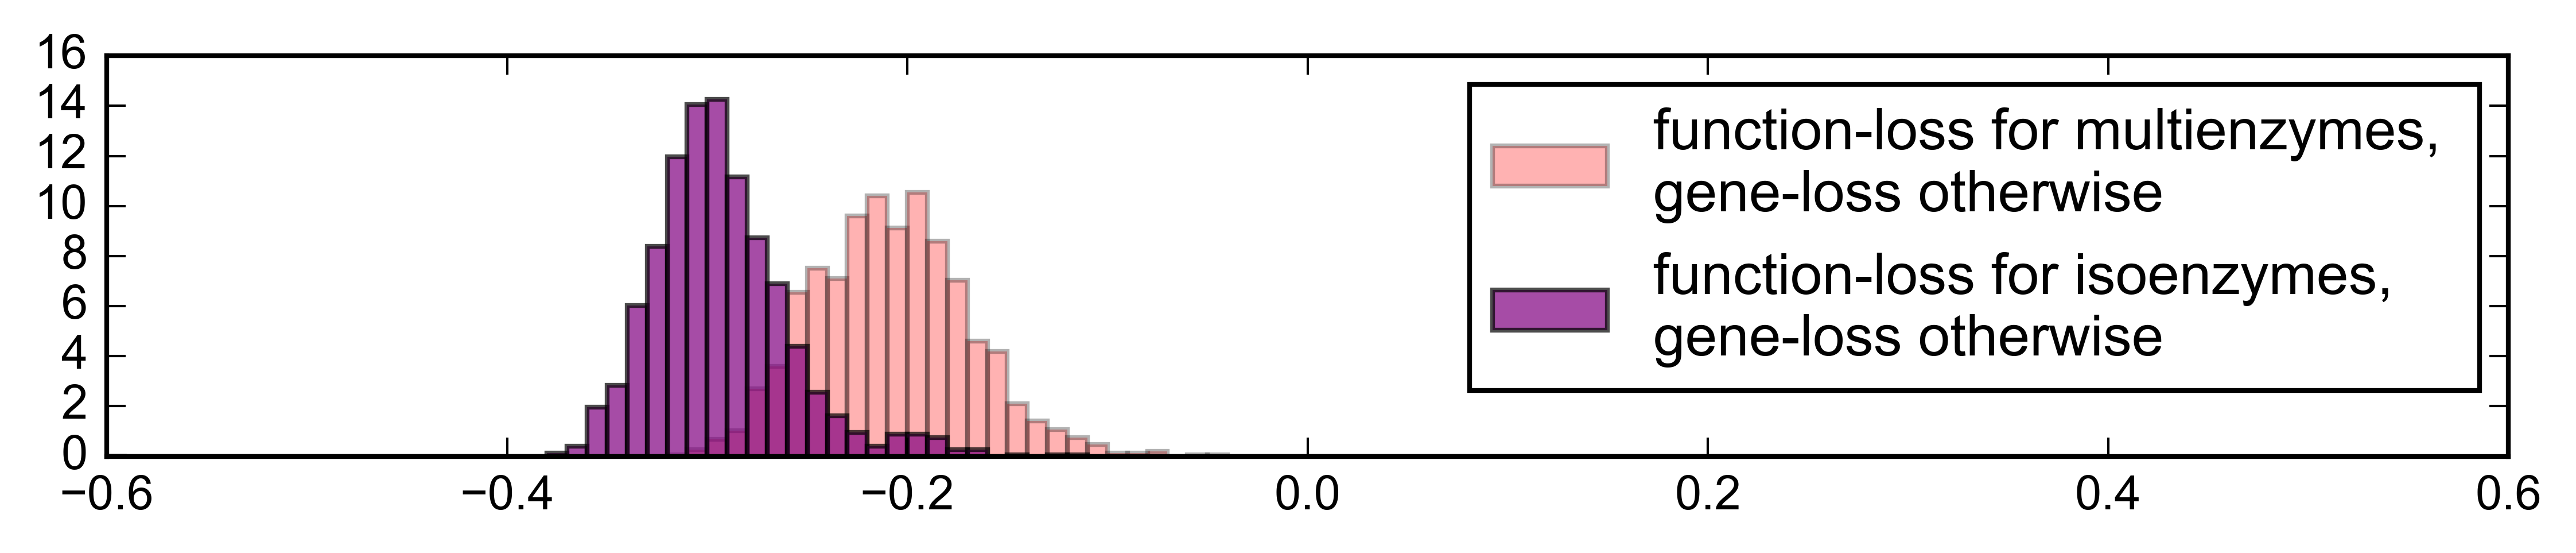

In [42]:
plt.figure(figsize=(9,1.5))
nBins = 100
rng = (-0.6, 0.4)
plt.hist(rhosHybrid1, bins=nBins, range=rng, color='red', normed=True, alpha=0.3,
         label='function-loss for multienzymes, \ngene-loss otherwise')
plt.hist(rhosHybrid2, bins=nBins, range=rng, color='purple', normed=True, alpha=0.7,
         label='function-loss for isoenzymes, \ngene-loss otherwise')
plt.legend()
plt.show()

In [43]:
from scipy.stats import pearsonr

genesOK = [g for g in genes if not np.isnan(g.dndsRank)]
rsOld = [pearsonr([gene.geneLossCosts[i] for gene in genesOK], 
                     [gene.dndsRank for gene in genesOK])[0] 
           for i in range(nConditions)]
rsNew = [pearsonr([gene.functionLossCosts[i] for gene in genesOK], 
                     [gene.dndsRank for gene in genesOK])[0] 
           for i in range(nConditions)]

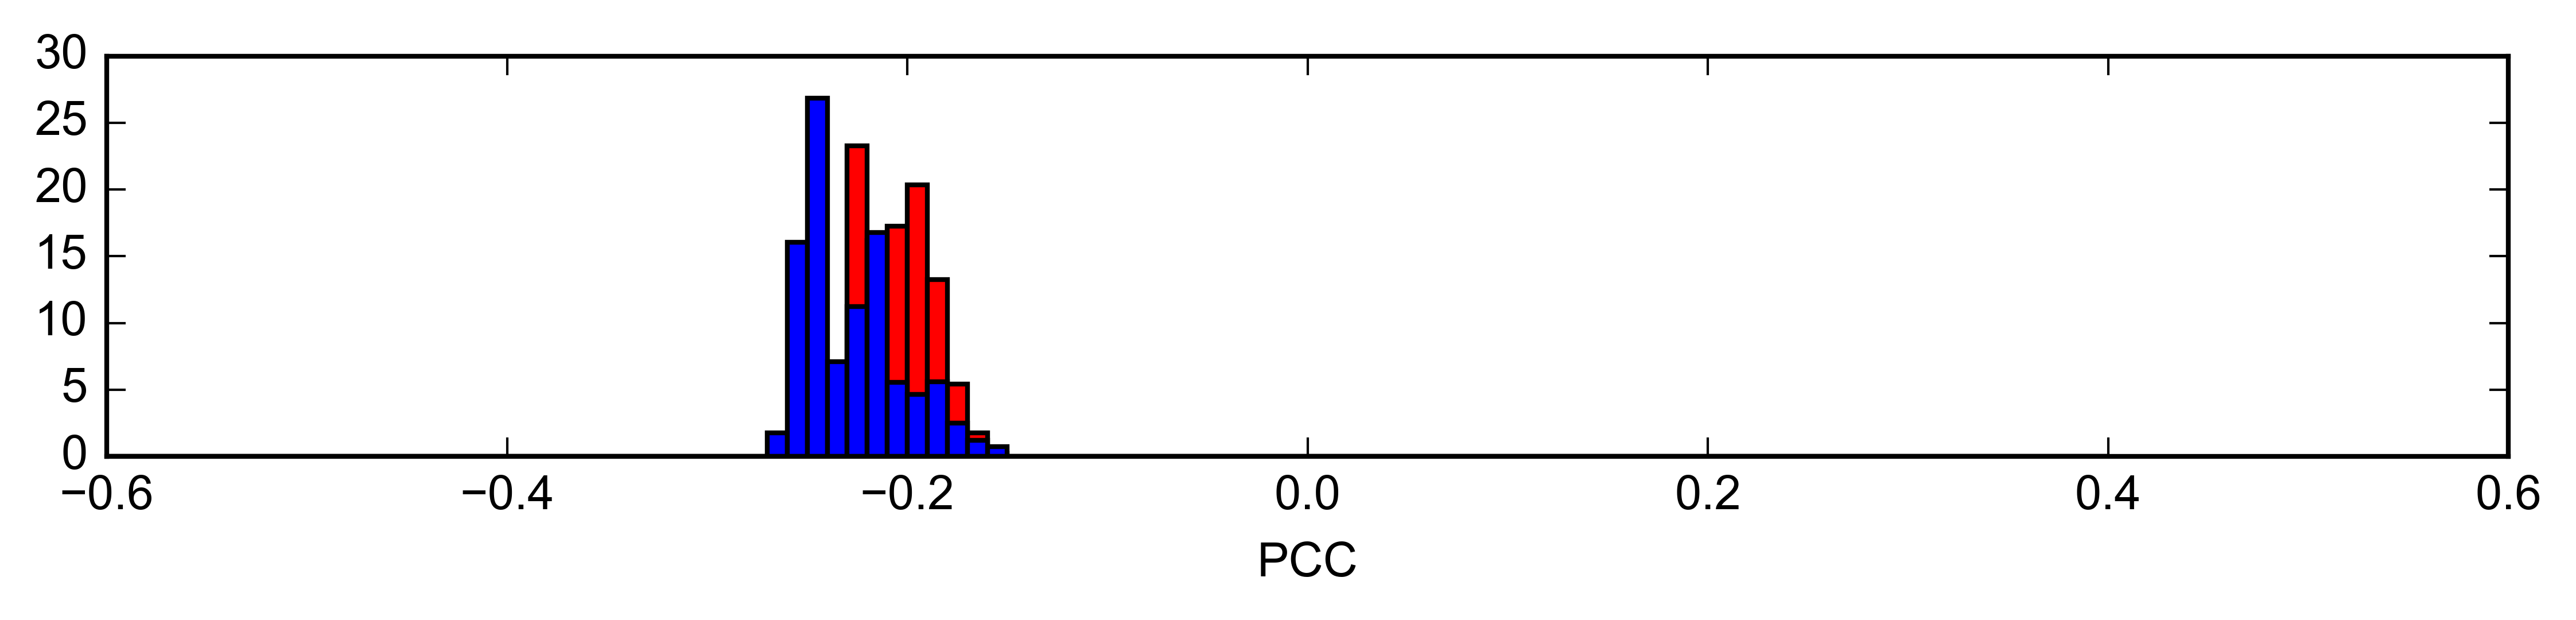

In [44]:
plt.figure(figsize=(9,1.5))
plt.hist(rsOld, bins=nBins, range=rng, color='red', normed=True)
plt.hist(rsNew, bins=nBins, range=rng, color='blue', normed=True)
plt.xlabel('PCC')
plt.show()

In [5]:
ypd = load_media(modelPath, 'ypd')

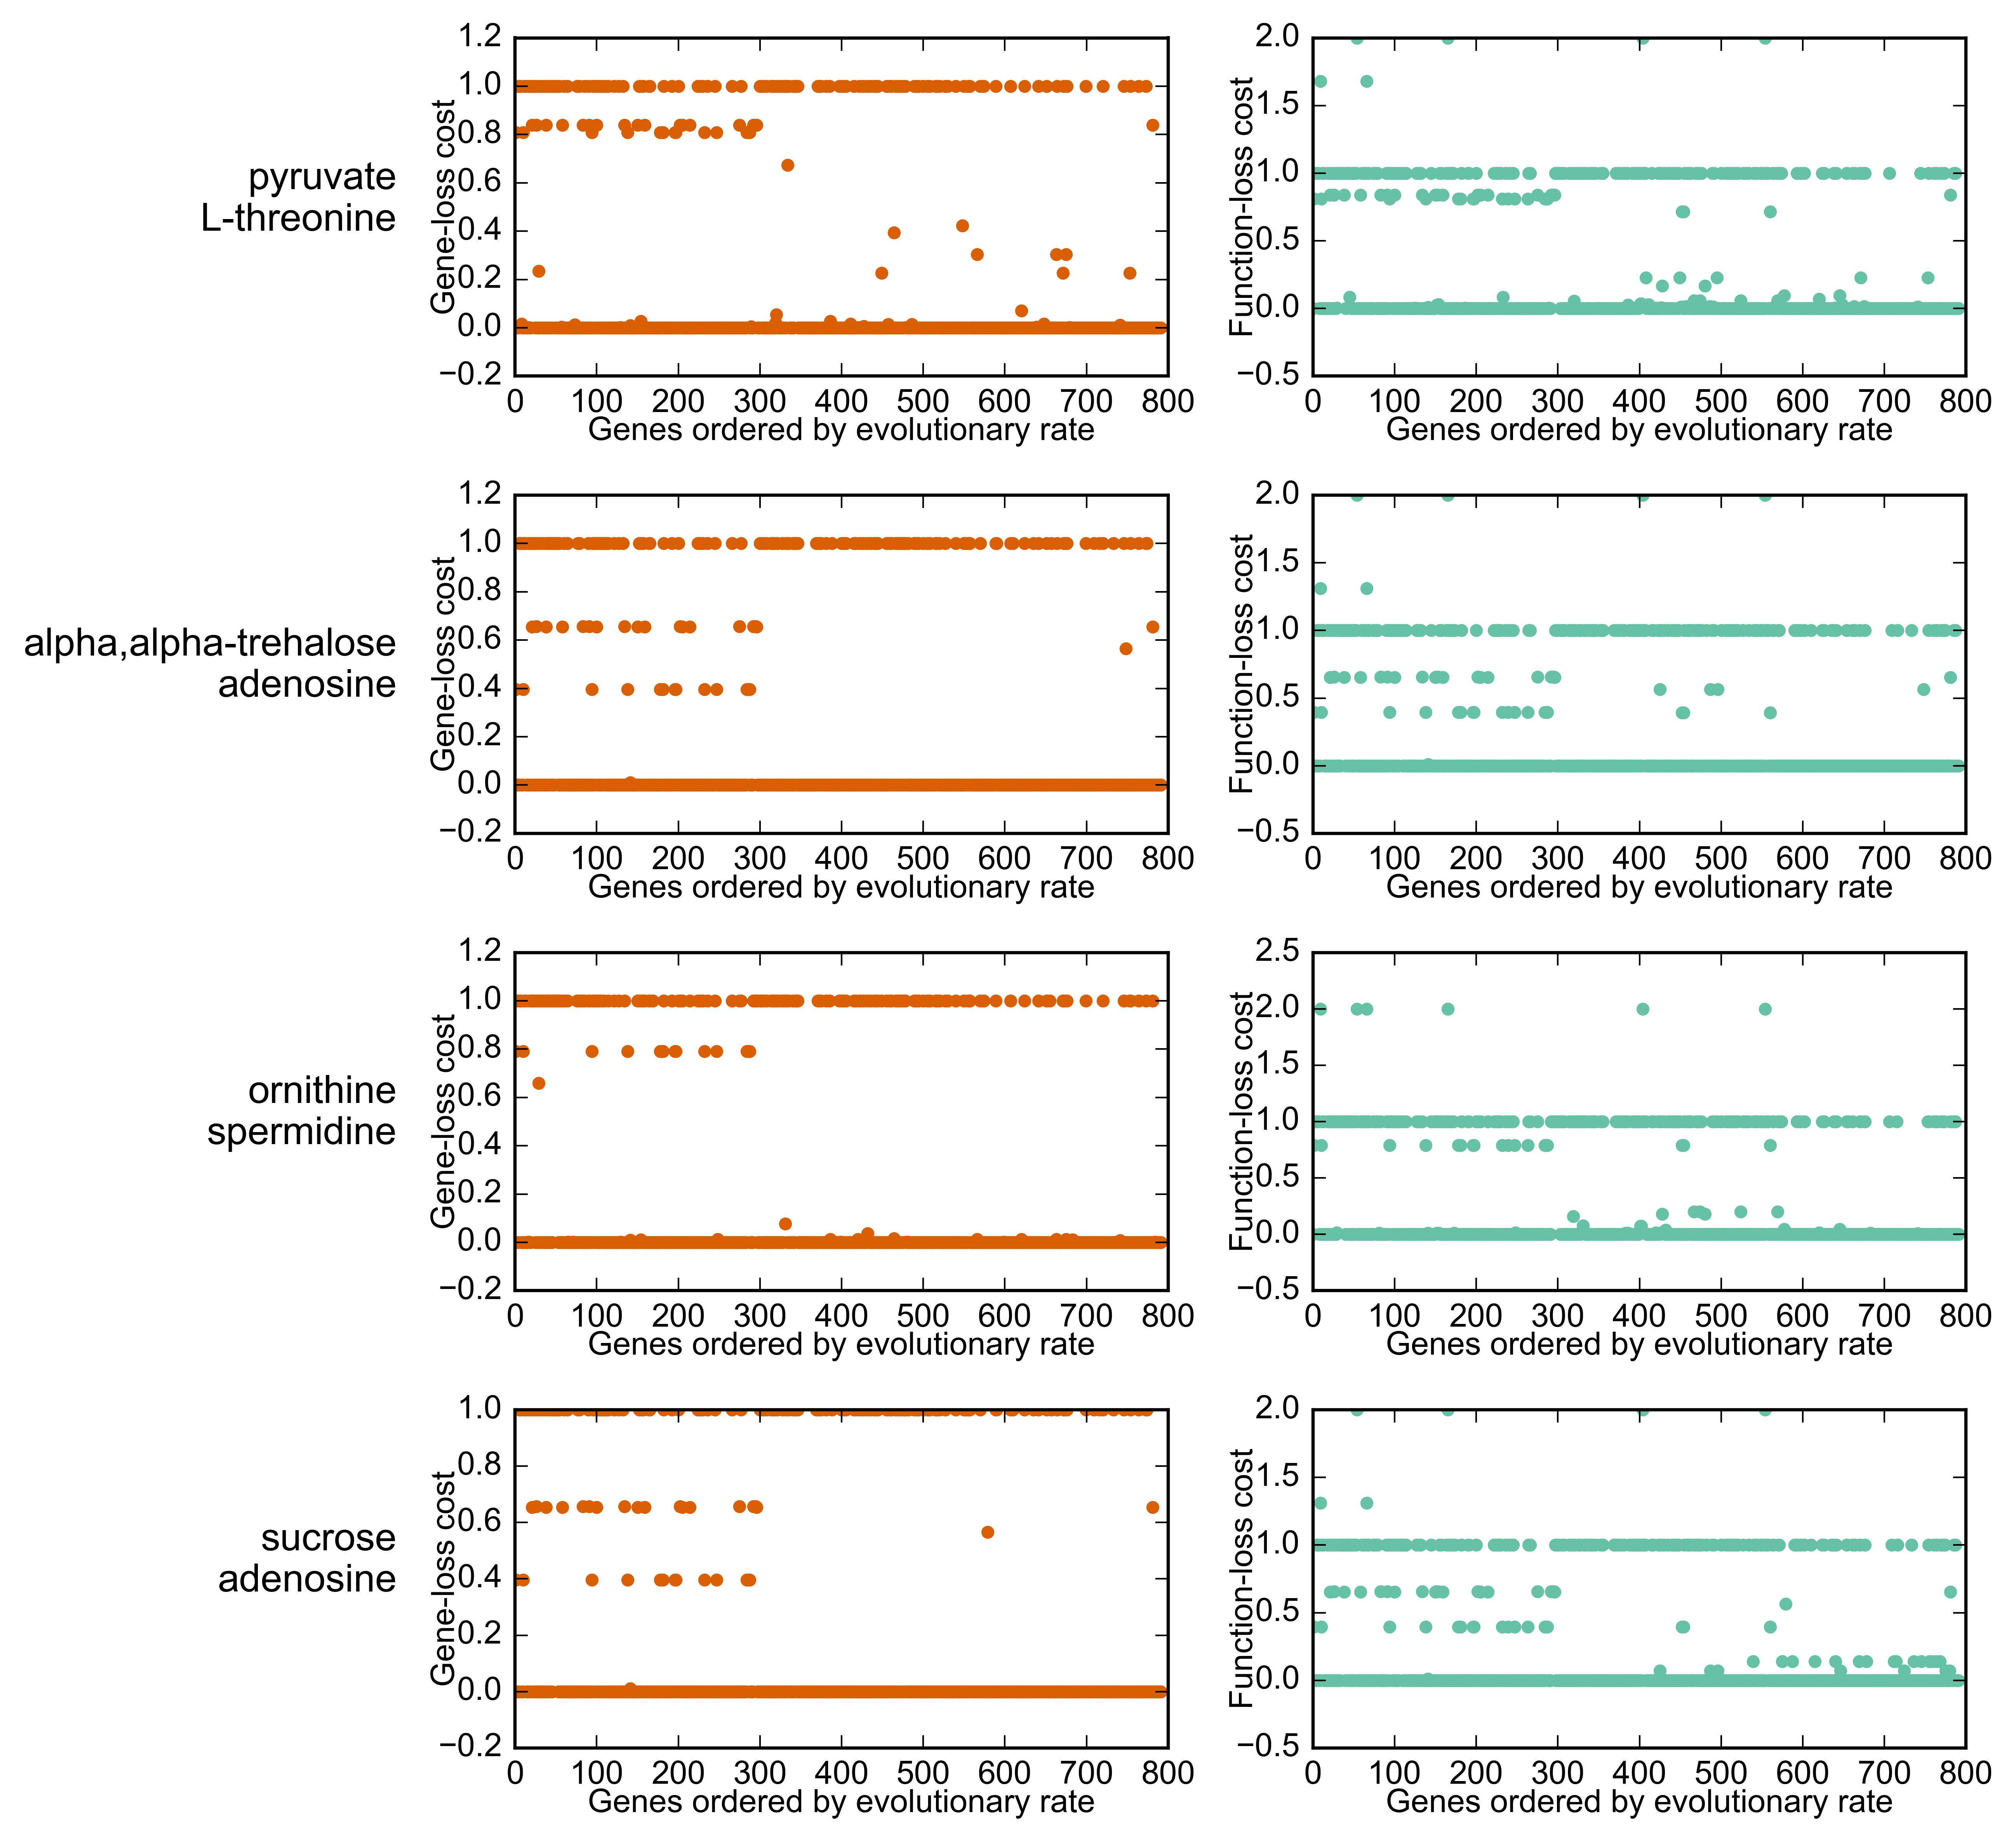

In [46]:
# figure S1 - part 1
# rank by dnds

def plot_ranked_gene_loss_costs(ax, mediaIndex):
    ax.plot([g.geneLossCosts[mediaIndex] for g in sorted(genes, key=lambda x: x.dndsRank)],
             'o', color='#d95f02', markersize=4, markeredgewidth=0.)
    ax.set_ylabel('Gene-loss cost', labelpad=-7.)
    ax.set_xlabel('Genes ordered by evolutionary rate', 
                  labelpad=-0.5)

    
def plot_ranked_function_loss_costs(ax, mediaIndex):
    ax.plot([g.functionLossCosts[mediaIndex] for g in sorted(genes, key=lambda x: x.dndsRank)],
             'o', color='#66c2a5', markersize=4, markeredgewidth=0.)
    ax.set_ylabel('Function-loss cost', labelpad=-7.)
    ax.set_xlabel('Genes ordered by evolutionary rate',
                  labelpad=-0.5)
    
    
a = np.argmin(rhosOld)
b = np.argmax(rhosOld)
c = np.argmin(rhosNew)
d = np.argmax(rhosNew)
fig, ax = plt.subplots(4, 2)
fig.set_size_inches(7, 8)
plot_ranked_gene_loss_costs(ax[0, 0], a)
plot_ranked_function_loss_costs(ax[0, 1], a)
plot_ranked_gene_loss_costs(ax[1, 0], b)
plot_ranked_function_loss_costs(ax[1, 1], b)
plot_ranked_gene_loss_costs(ax[2, 0], c)
plot_ranked_function_loss_costs(ax[2, 1], c)
plot_ranked_gene_loss_costs(ax[3, 0], d)
plot_ranked_function_loss_costs(ax[3, 1], d)
fig.text(0.0, 0.87, '\n'.join(minimalMedia[a]), fontsize=12, ha='right')
fig.text(0.0, 0.62, '\n'.join(minimalMedia[b]), fontsize=12, ha='right')
fig.text(0.0, 0.38, '\n'.join(minimalMedia[c]), fontsize=12, ha='right')
fig.text(0.0, 0.14, '\n'.join(minimalMedia[d]), fontsize=12, ha='right')
plt.tight_layout()
plt.savefig(os.path.join(figDir, 'latest_revision_figureS1A.pdf'), bbox_inches='tight')
plt.savefig(os.path.join(figDir, 'latest_revision_figureS1A.svg'), bbox_inches='tight')
plt.savefig(os.path.join(figDir, 'latest_revision_figureS1A.eps'), bbox_inches='tight')
plt.show()

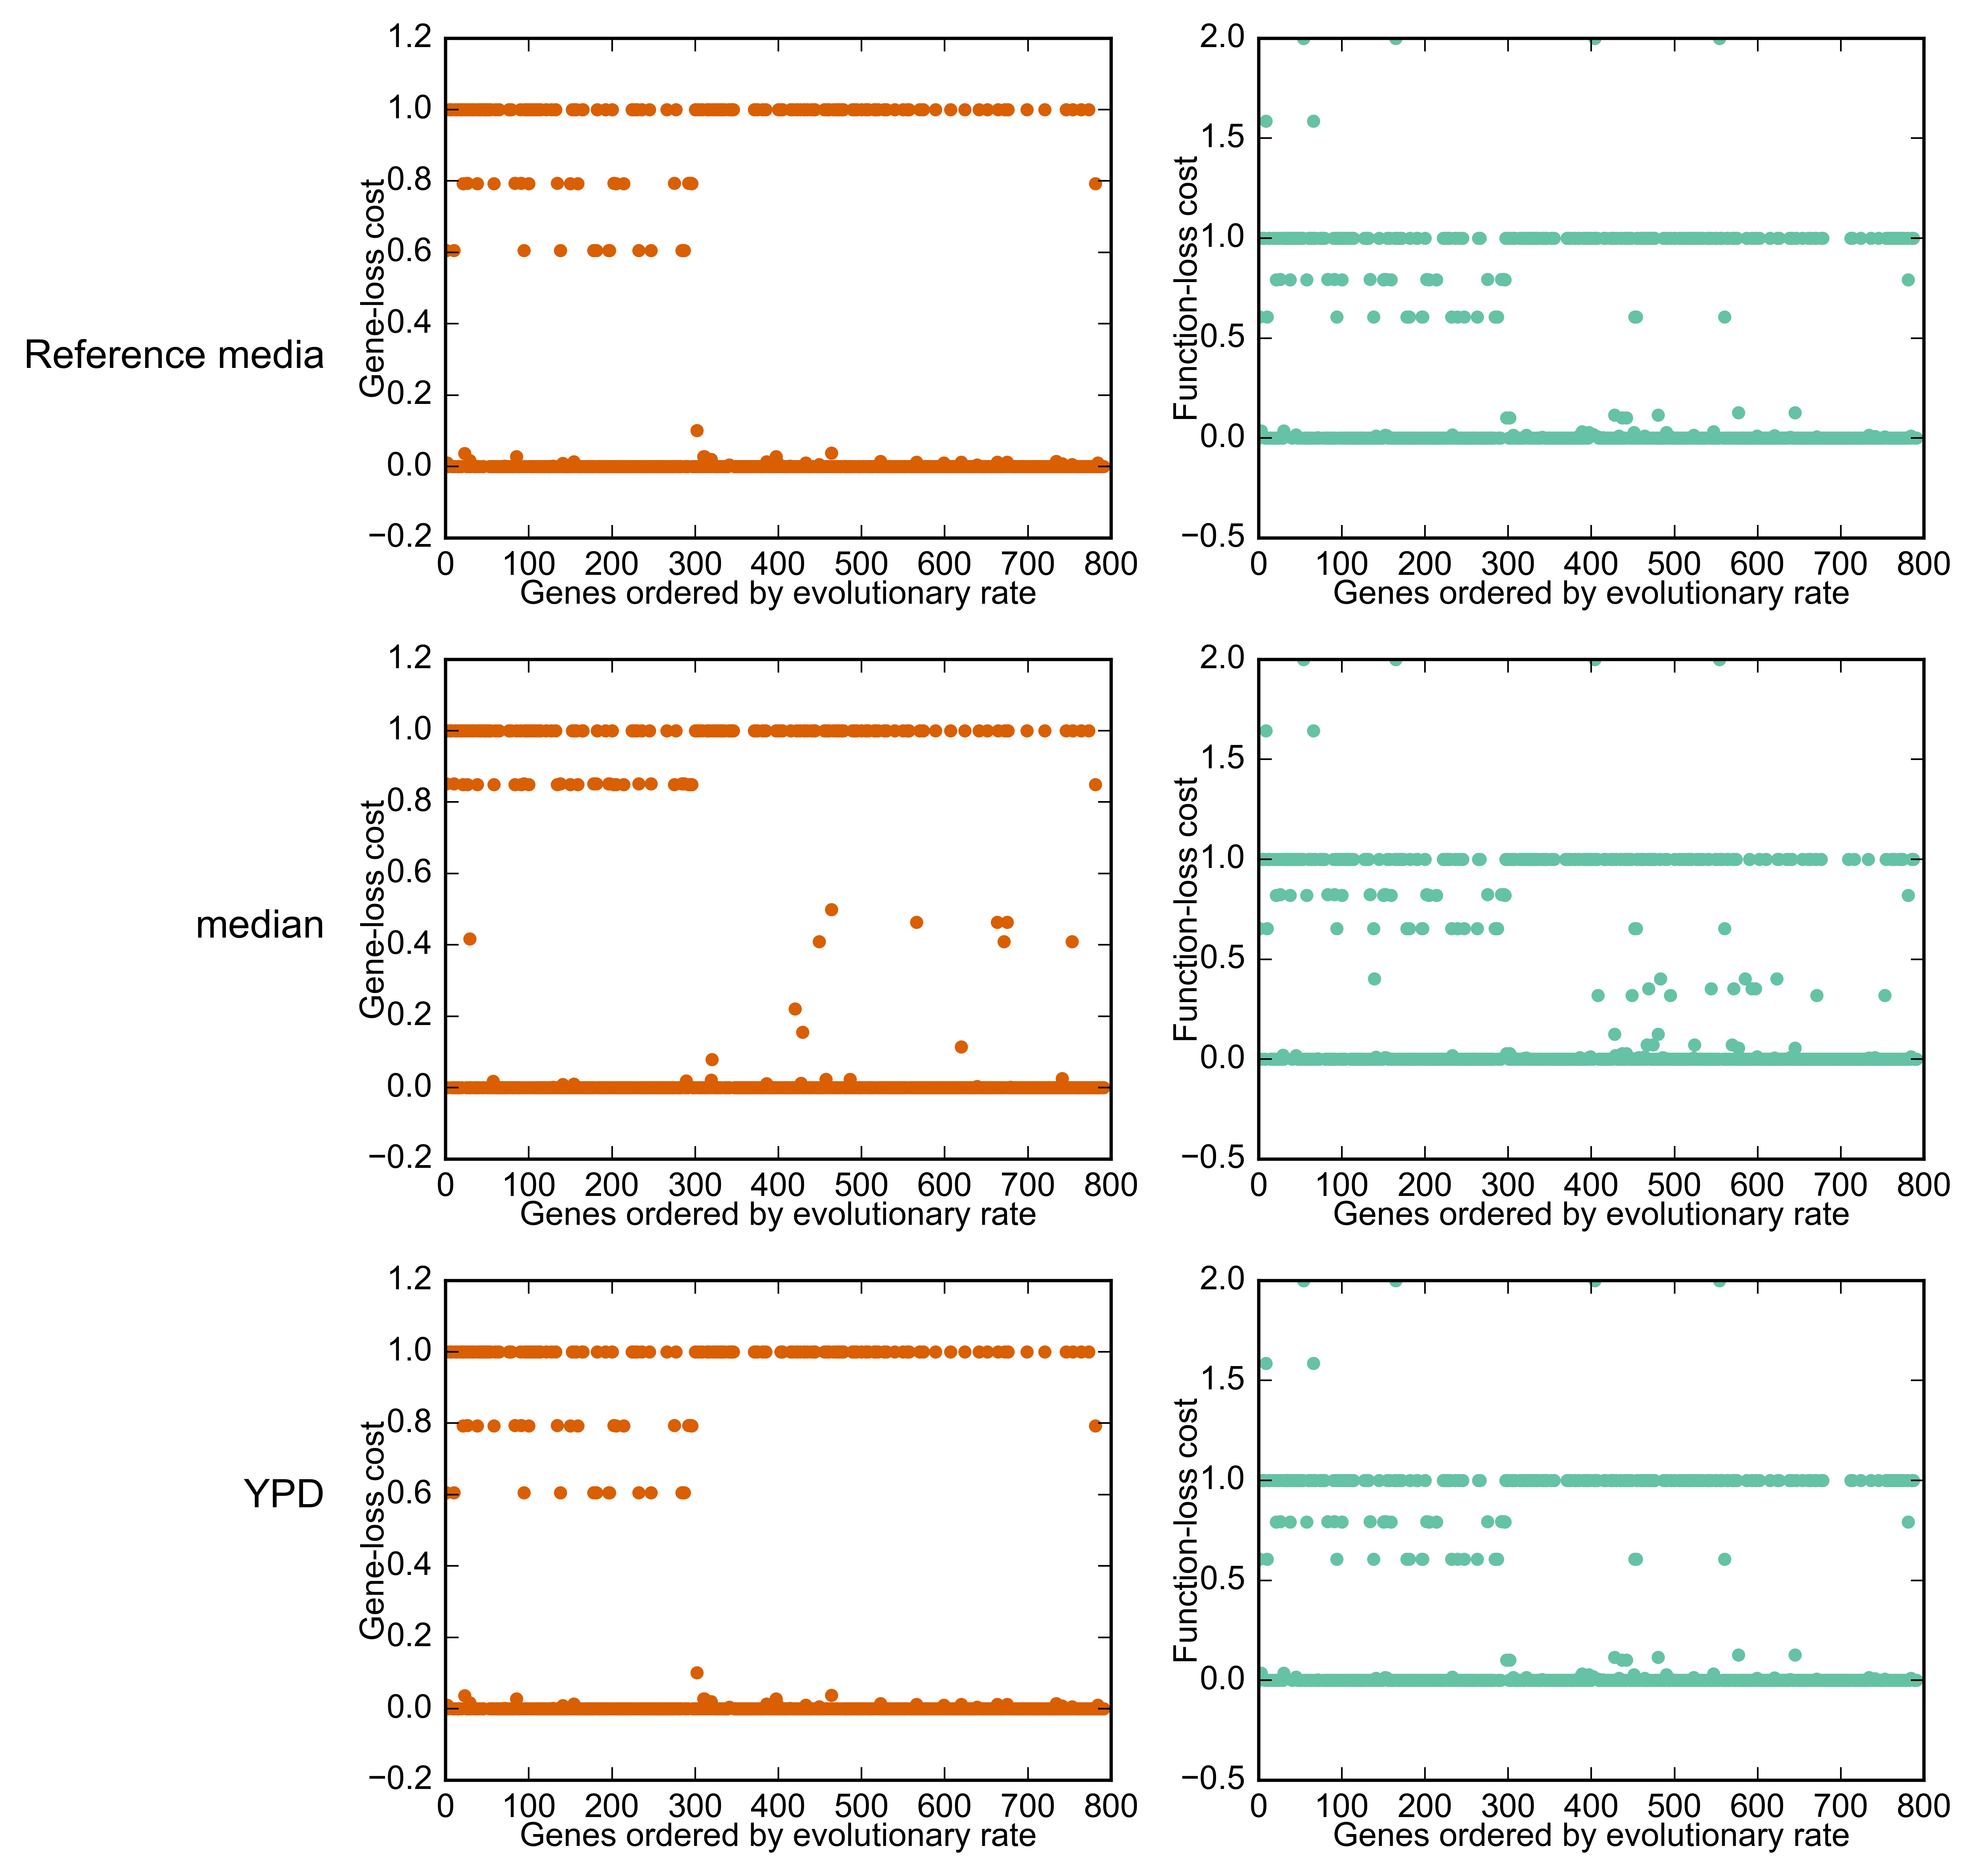

In [47]:
refIndex = minimalMedia.index(('D-glucose', 'ammonium'))
medianGLCindex = rhosOld.index(np.median(rhosOld))
medianFLCindex = rhosNew.index(np.median(rhosNew))
# now do the same for rich media
fig, ax = plt.subplots(3, 2)
fig.set_size_inches(7, 8)
plot_ranked_gene_loss_costs(ax[0, 0], refIndex)
plot_ranked_function_loss_costs(ax[0, 1], refIndex)
plot_ranked_gene_loss_costs(ax[1, 0], medianGLCindex)
plot_ranked_function_loss_costs(ax[1, 1], medianFLCindex)
_didWtGrow, ypdGLC, ypdFLC = single_knockout_loss_costs(ypd)

ax[2, 0].plot([ypdGLC[g.name] for g in sorted(genes, key=lambda x: x.dndsRank)],
             'o', color='#d95f02', markersize=4, markeredgewidth=0.)
ax[2, 0].set_ylabel('Gene-loss cost', labelpad=-7.)
ax[2, 0].set_xlabel('Genes ordered by evolutionary rate', 
                  labelpad=-0.5)
ax[2, 1].plot([ypdFLC[g.name] for g in sorted(genes, key=lambda x: x.dndsRank)],
             'o', color='#66c2a5', markersize=4, markeredgewidth=0.)
ax[2, 1].set_ylabel('Function-loss cost', labelpad=-7.)
ax[2, 1].set_xlabel('Genes ordered by evolutionary rate', 
                  labelpad=-0.5)
#plot_ranked_gene_loss_costs(ax[2, 0], c)
#plot_ranked_function_loss_costs(ax[2, 1], c)
fig.text(0.0, 0.8, 'Reference media', fontsize=12, ha='right')
fig.text(0.0, 0.5, 'median', fontsize=12, ha='right')
fig.text(0.0, 0.2, 'YPD', fontsize=12, ha='right')
plt.tight_layout()
plt.savefig(os.path.join(figDir, 'latest_revision_figureS1B.pdf'), bbox_inches='tight')
plt.savefig(os.path.join(figDir, 'latest_revision_figureS1B.svg'), bbox_inches='tight')
plt.savefig(os.path.join(figDir, 'latest_revision_figureS1B.eps'), bbox_inches='tight')
plt.show()

p-value: 1.86e-240
p-value: 1.12e-08


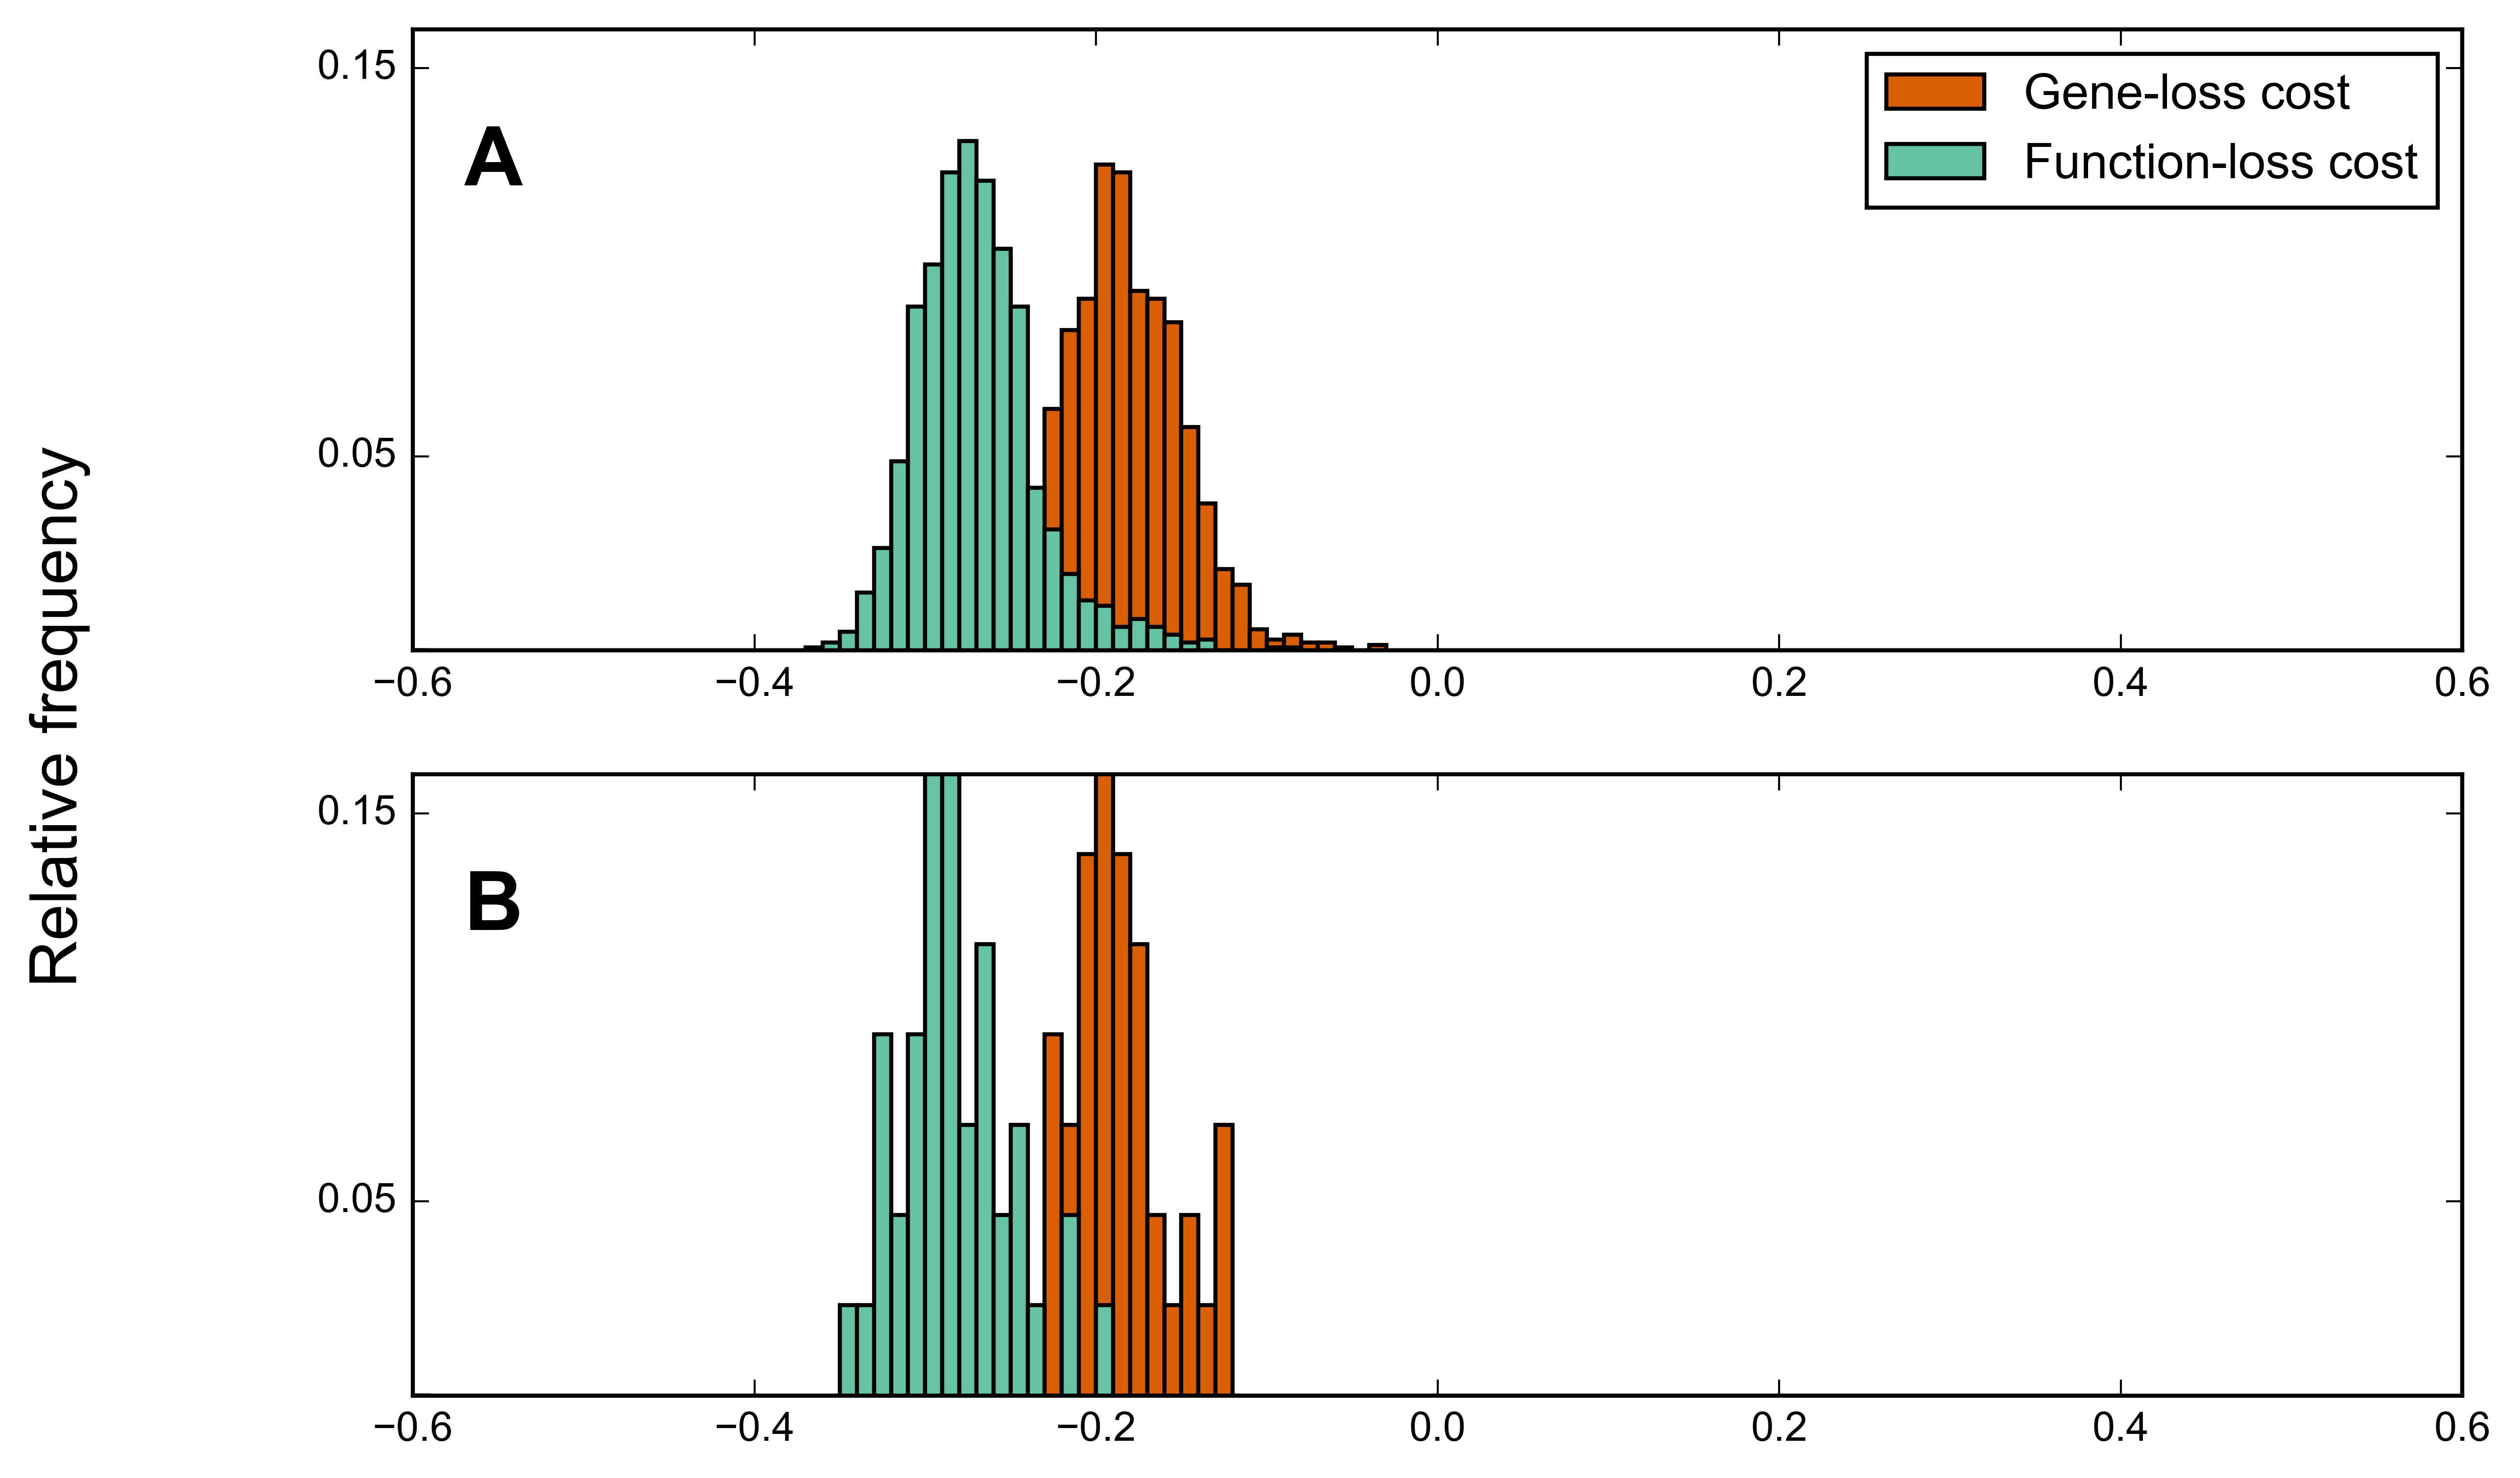

lowest correlation of ammonium with a carbon source is: -0.267386489744 for ('(S)-lactate', 'ammonium')
highest correlation of ammonium with a carbon source is: -0.121401173779 for ('maltose', 'ammonium')


In [48]:
# take all the carbon sources with ammonium
ammoniumIndices = [i for i, m in enumerate(minimalMedia) if m[1] == 'ammonium']
rhosGLCammonium = [rhosOld[i] for i in ammoniumIndices]
rhosFLCammonium = [rhosNew[i] for i in ammoniumIndices]
fig, ax = plt.subplots(2, 1)
fig.set_size_inches(9, 6)
correlation_histograms(ax[0], rhosOld, rhosNew, drawLegend=True, 
                        drawXlabel=False, drawYlabel=False)
correlation_histograms(ax[1], rhosGLCammonium, rhosFLCammonium, drawXlabel=False, 
                       drawYlabel=False)
ax[0].text(-0.57, 0.12, 'A', fontweight='bold', fontsize=20)
ax[1].text(-0.57, 0.12, 'B', fontweight='bold', fontsize=20)
fig.text(-0.02, 0.51, 'Relative frequency', va='center', rotation='vertical', fontsize=16)
plt.show()
print 'lowest correlation of ammonium with a carbon source is:',
print min(rhosGLCammonium), 'for', minimalMedia[ammoniumIndices[np.argmin(rhosGLCammonium)]]
print 'highest correlation of ammonium with a carbon source is:',
print max(rhosGLCammonium), 'for', minimalMedia[ammoniumIndices[np.argmax(rhosGLCammonium)]]

In [49]:
from scipy.stats import ranksums


carbonSources = list(set([c for c, n in minimalMedia]))
nitrogenSources = list(set([n for c, n in minimalMedia]))
avrgRhoPerCsource = []
stdPerCsource = []
avrgRhoPerNsource = []
stdPerNsource = []
pValsCarbon = []
pValsNitrogen = []
for carbonSource in carbonSources:
    indices = [i for i, (c, n) in enumerate(minimalMedia) if c == carbonSource]
    rhosSubset = [rhosOld[i] for i in indices]
    otherRhos = [rhosOld[i] for i in range(len(rhosOld)) if i not in indices]
    pValsCarbon.append(ranksums(rhosSubset, otherRhos)[1] * len(set(carbonSources).union(set(nitrogenSources))))
    avrgRhoPerCsource.append(np.mean(rhosSubset))
    stdPerCsource.append(np.std(rhosSubset))
for nitrogenSource in nitrogenSources:
    indices = [i for i, (c, n) in enumerate(minimalMedia) if n == nitrogenSource]
    rhosSubset = [rhosOld[i] for i in indices]
    avrgRhoPerNsource.append(np.mean(rhosSubset))
    stdPerNsource.append(np.std(rhosSubset))
    pValsNitrogen.append(ranksums(rhosSubset, otherRhos)[1] * len(set(carbonSources).union(set(nitrogenSources))))

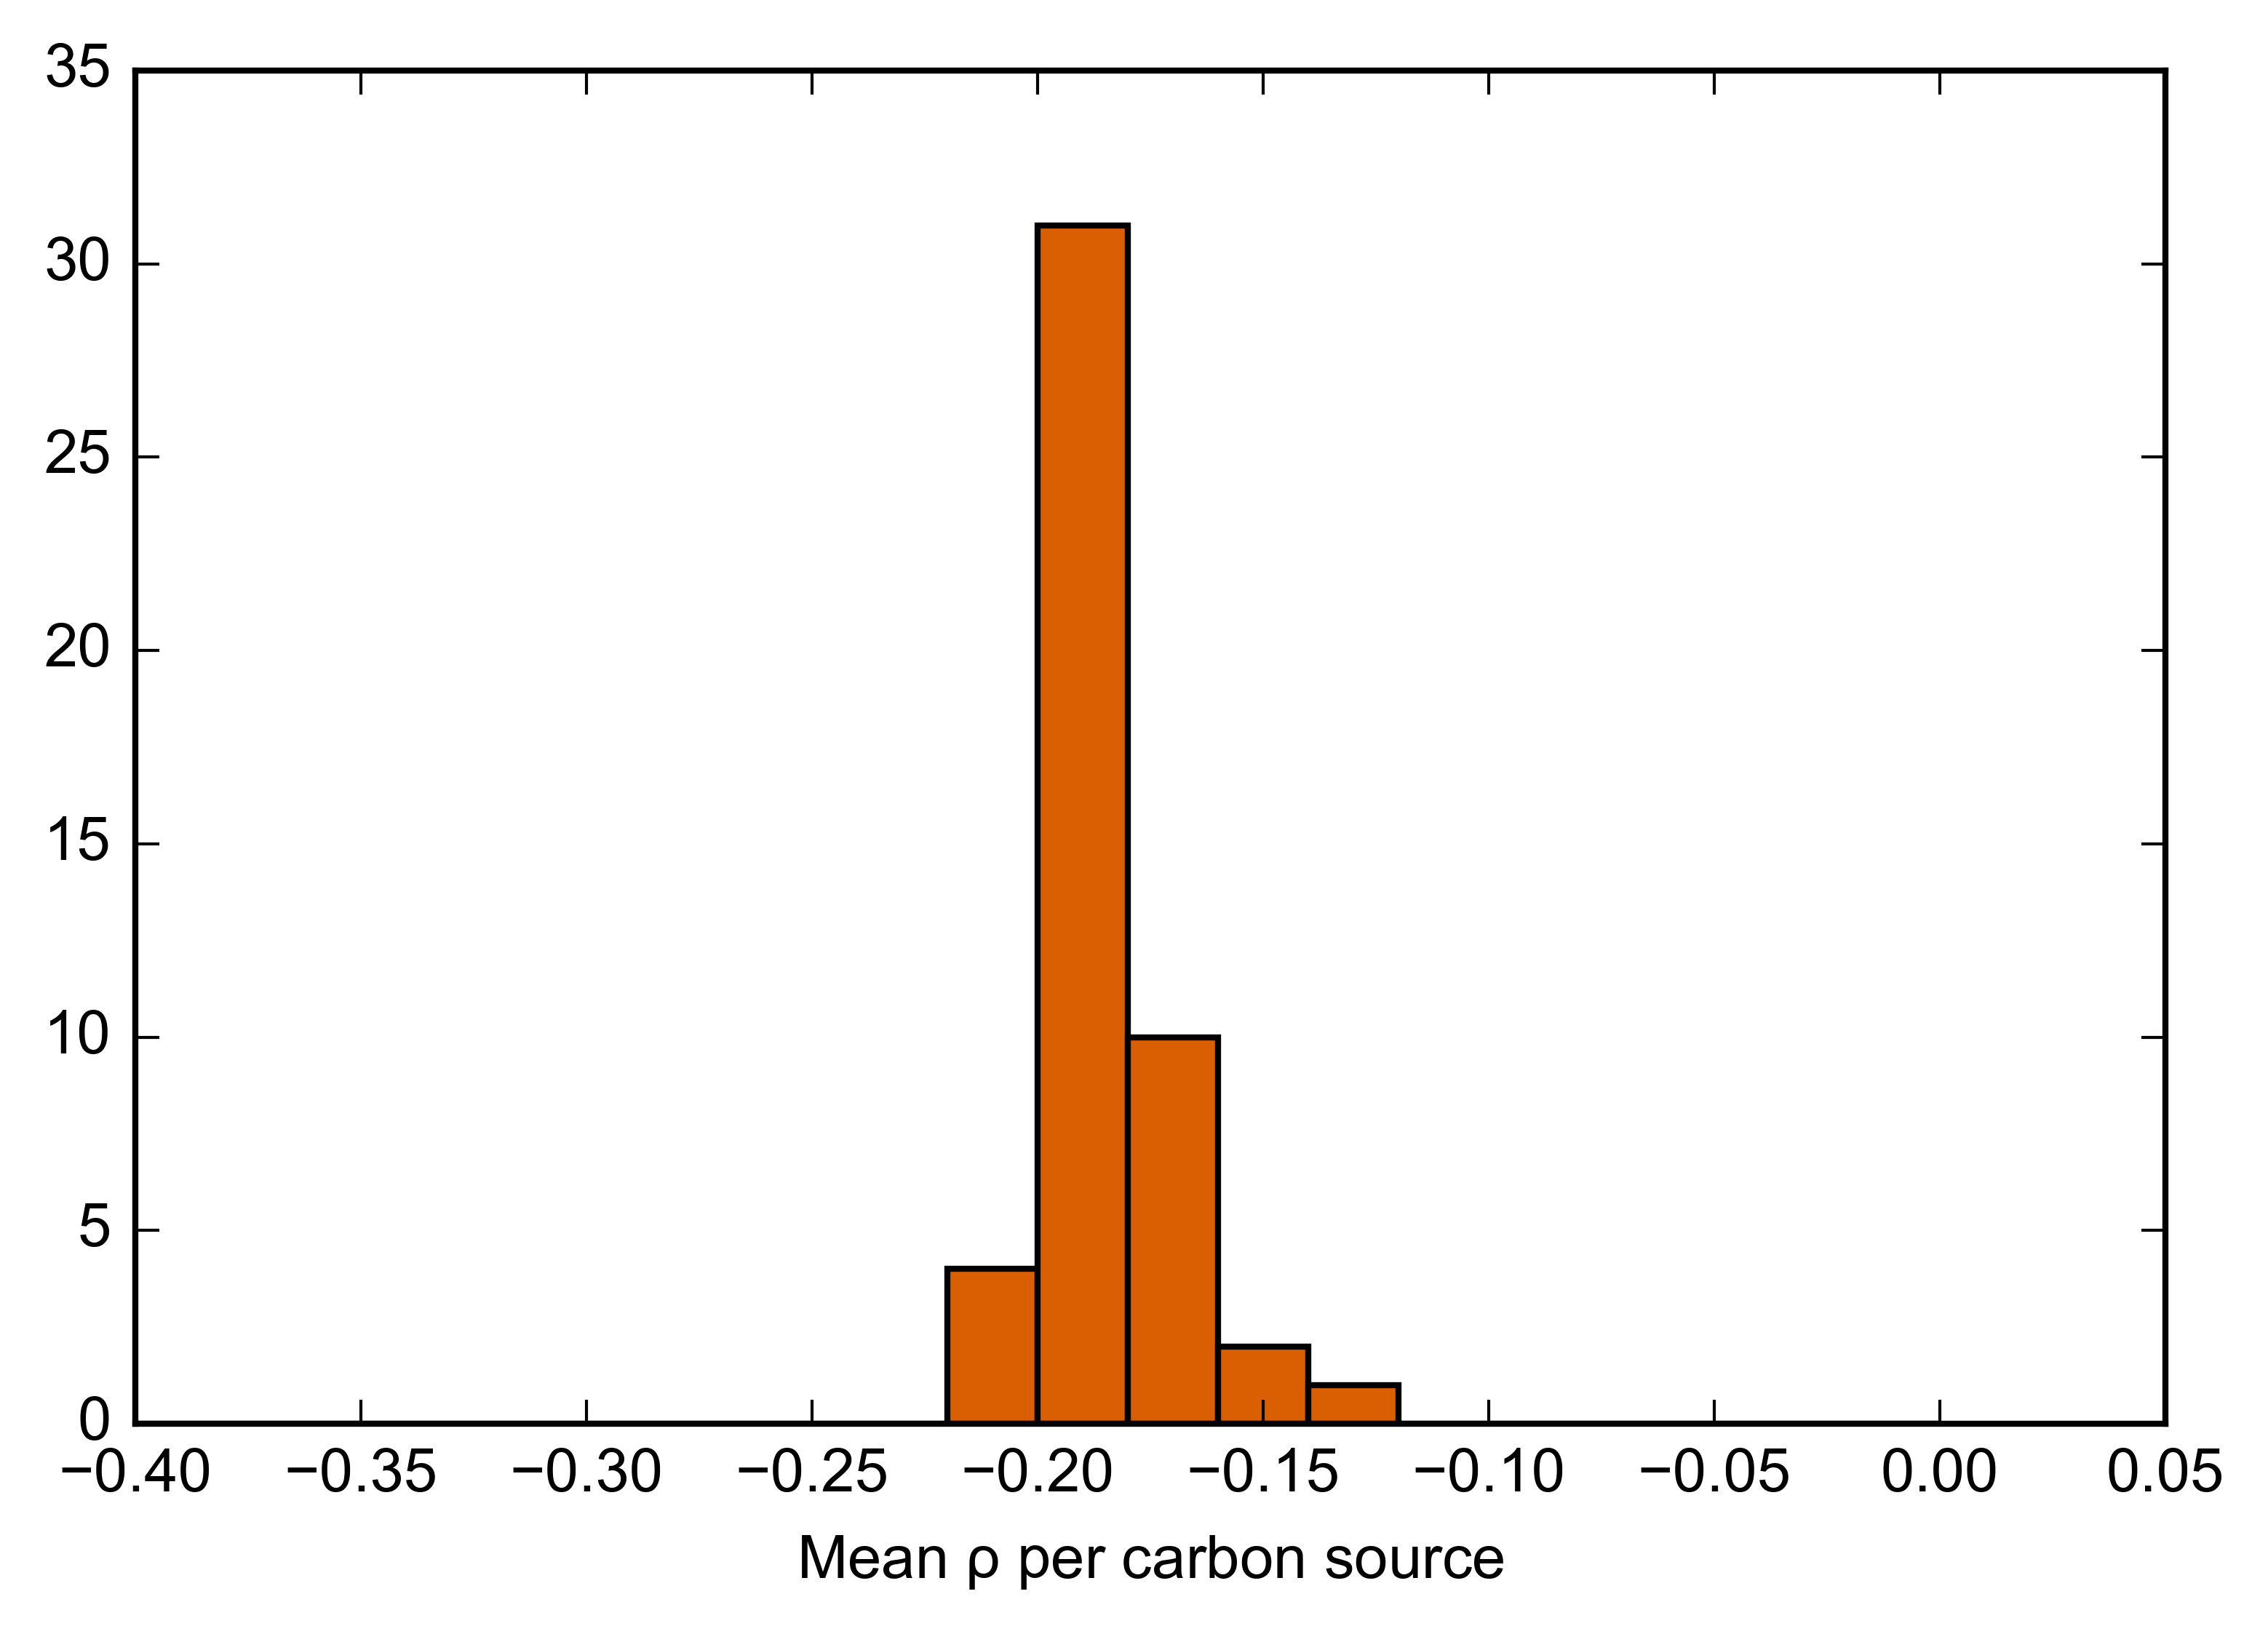

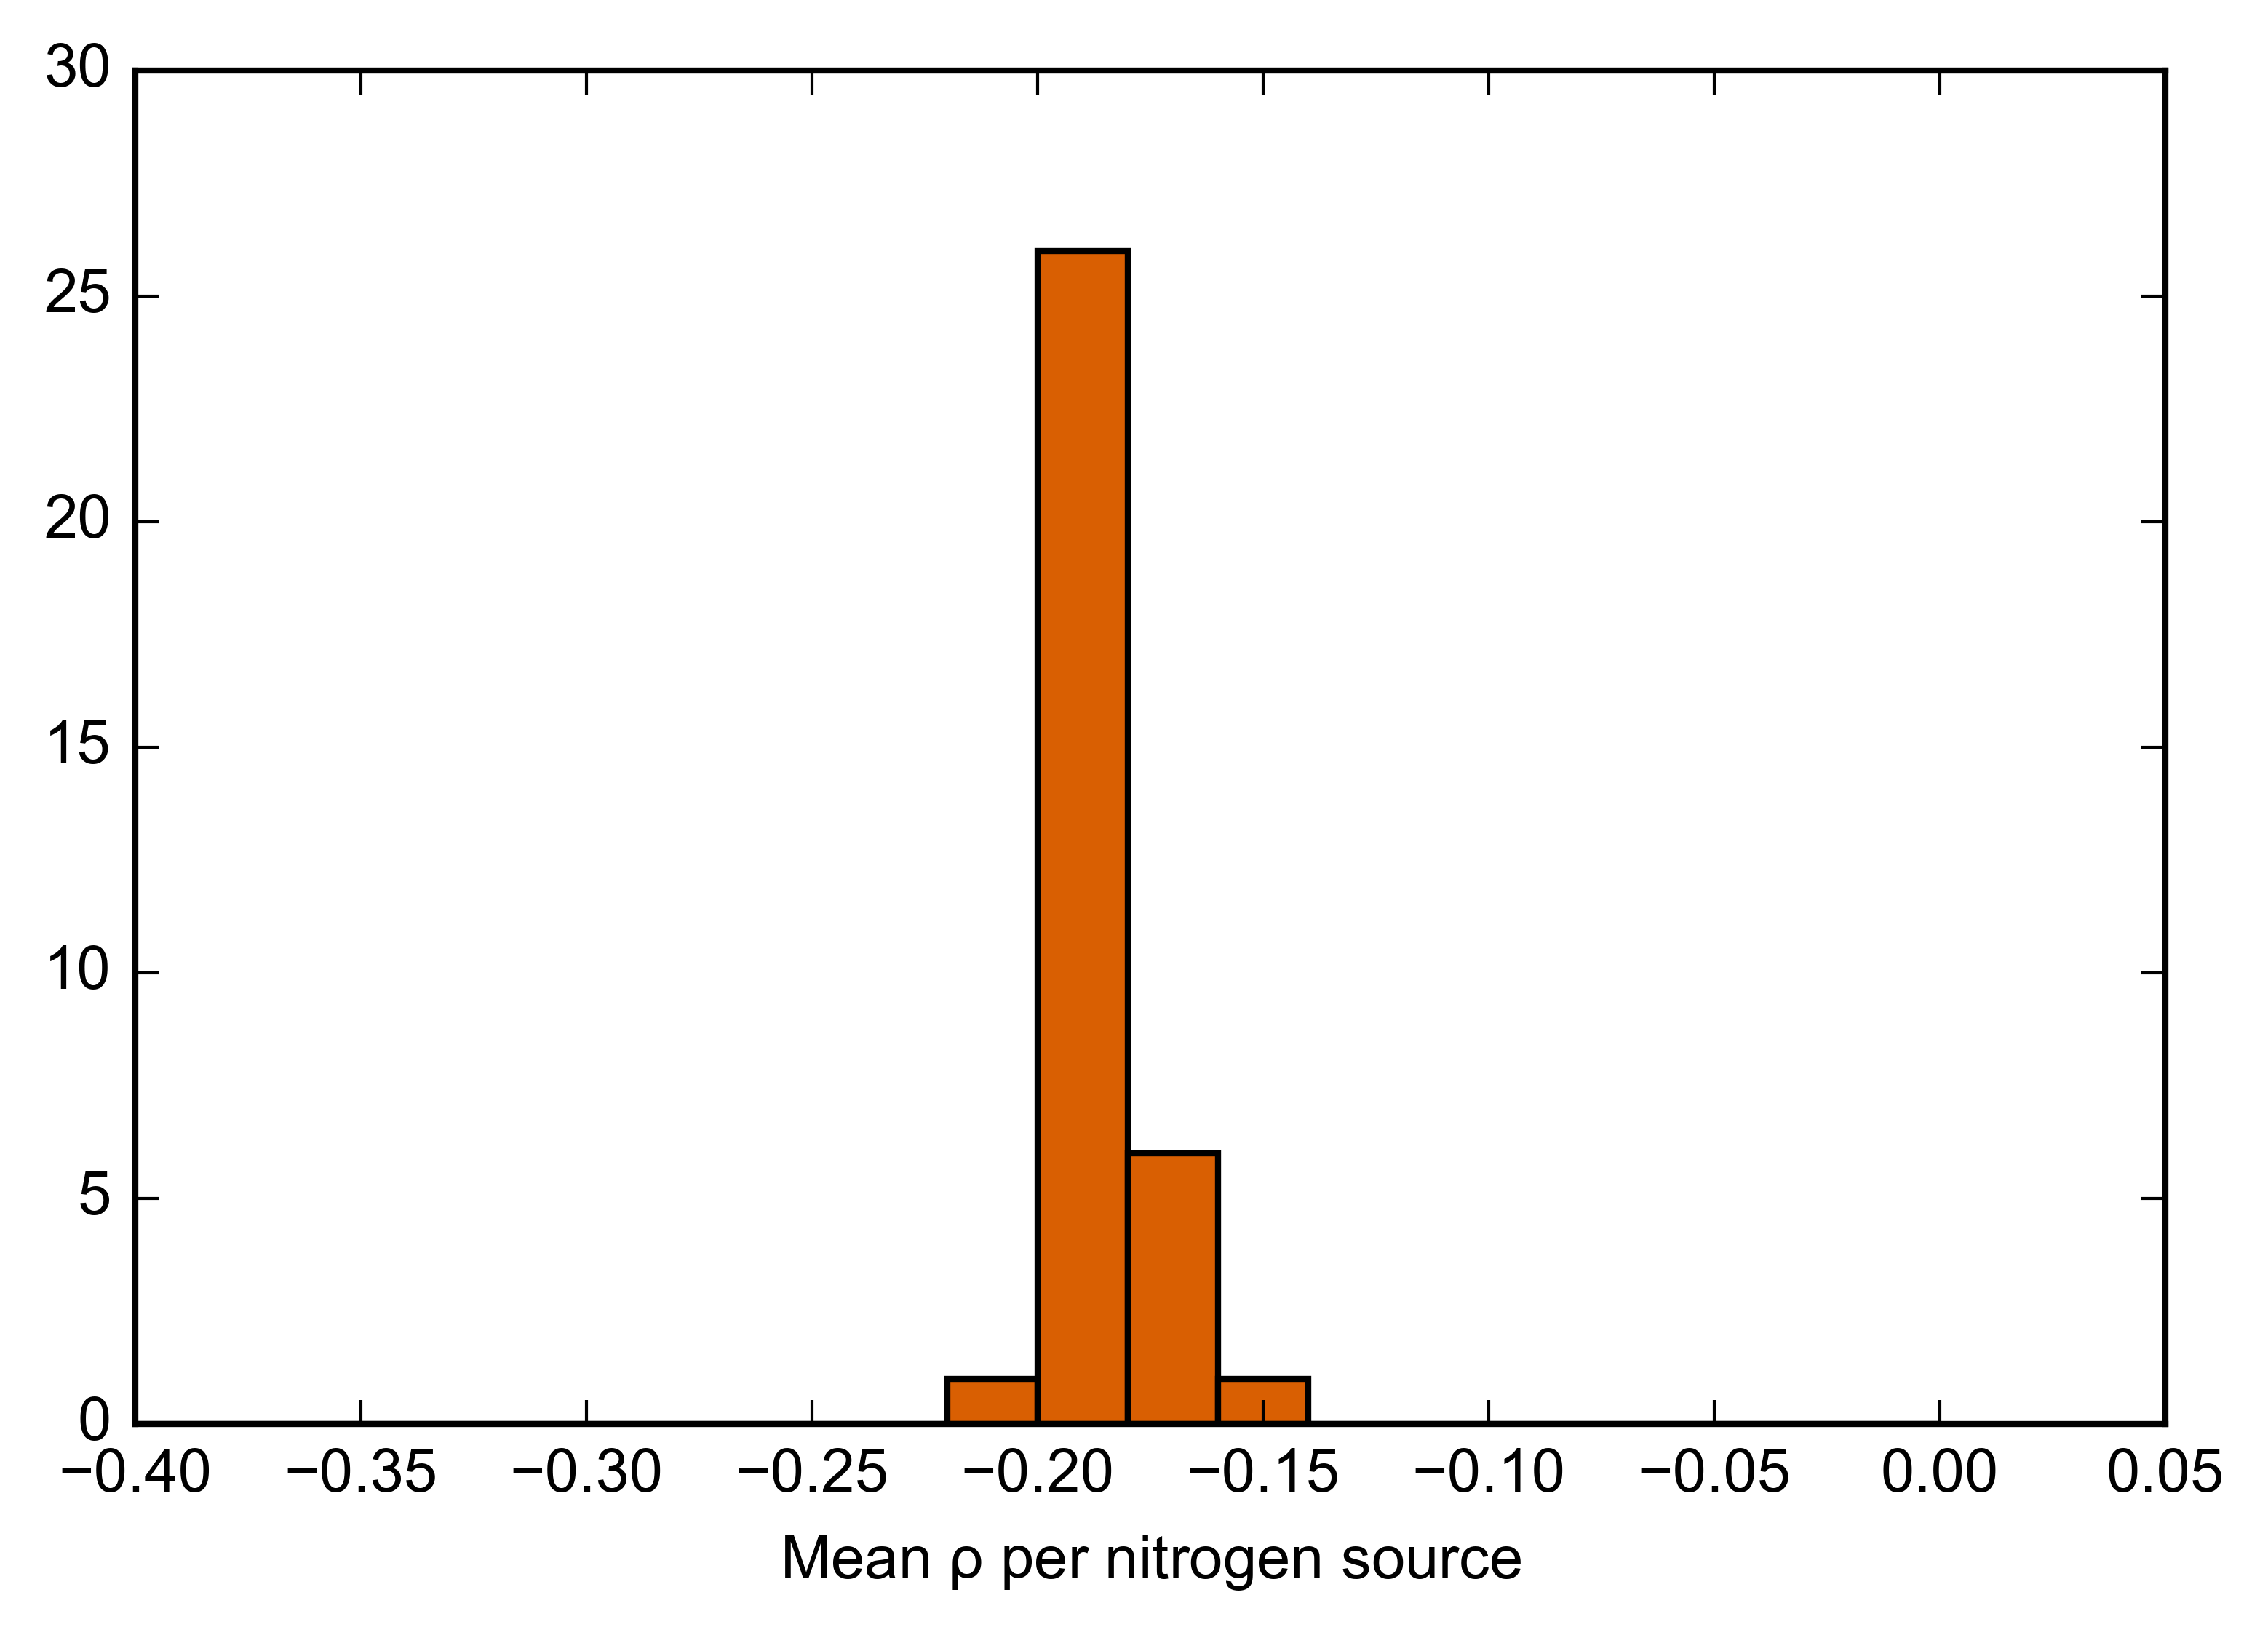

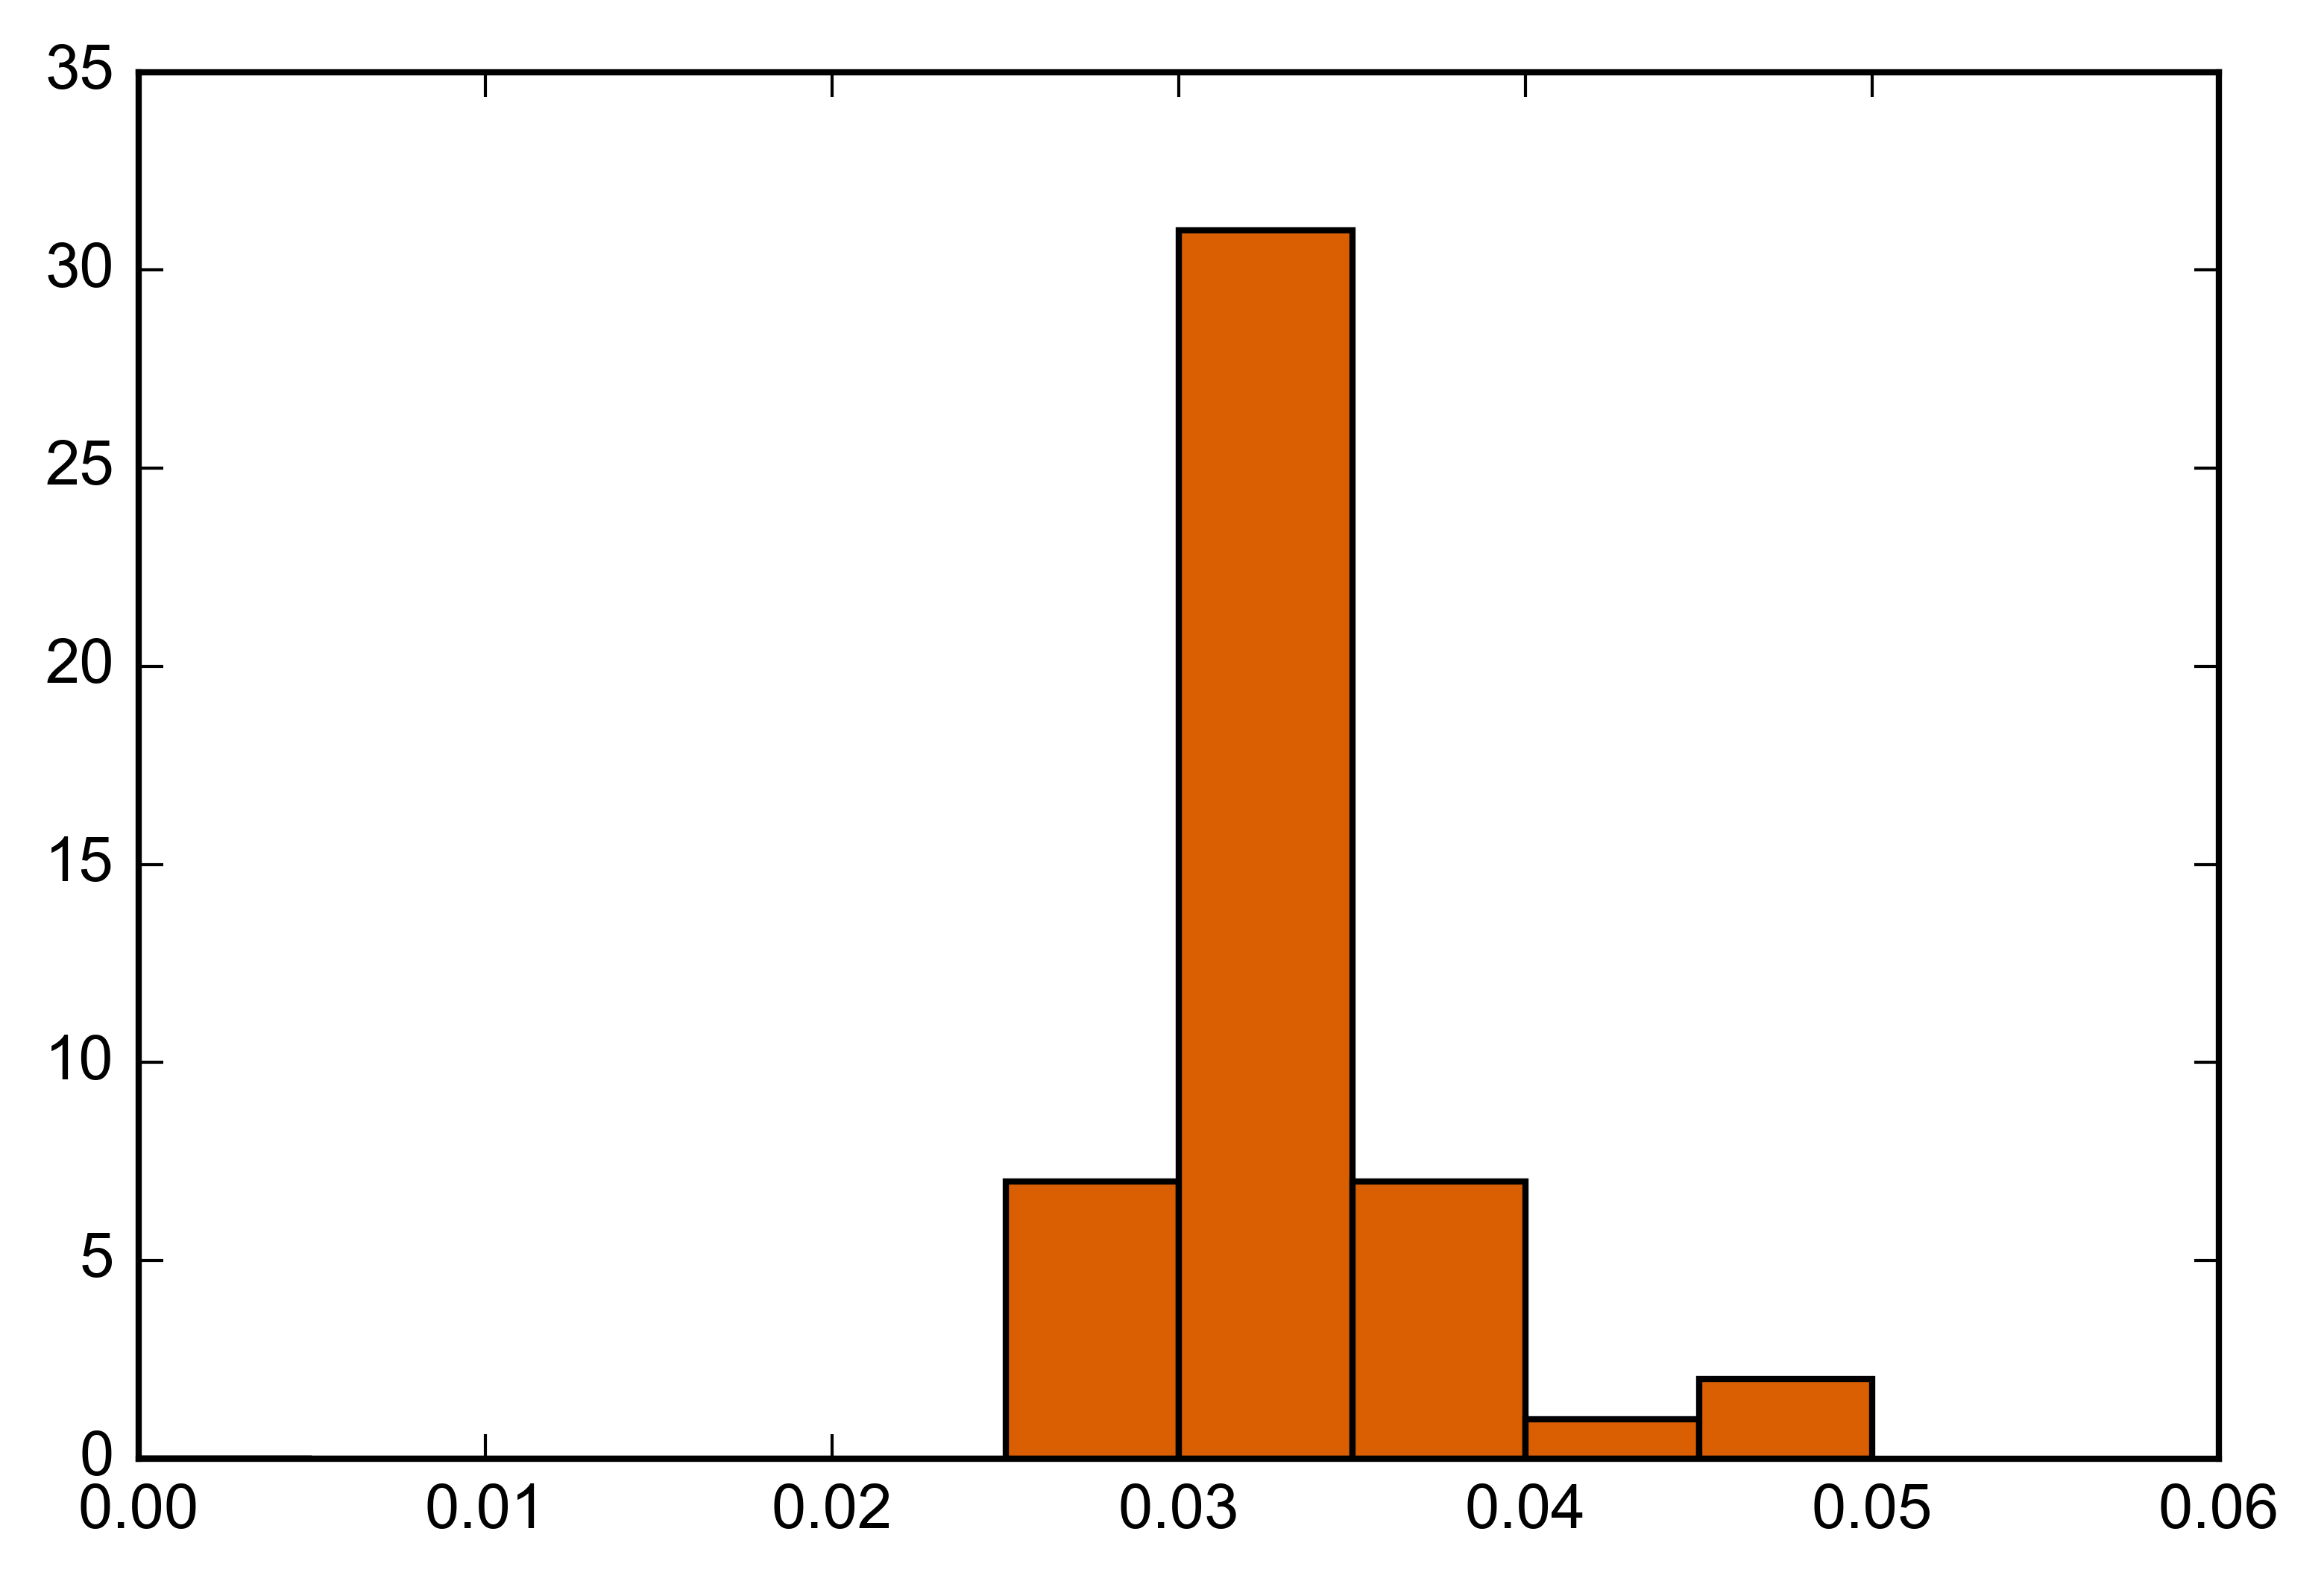

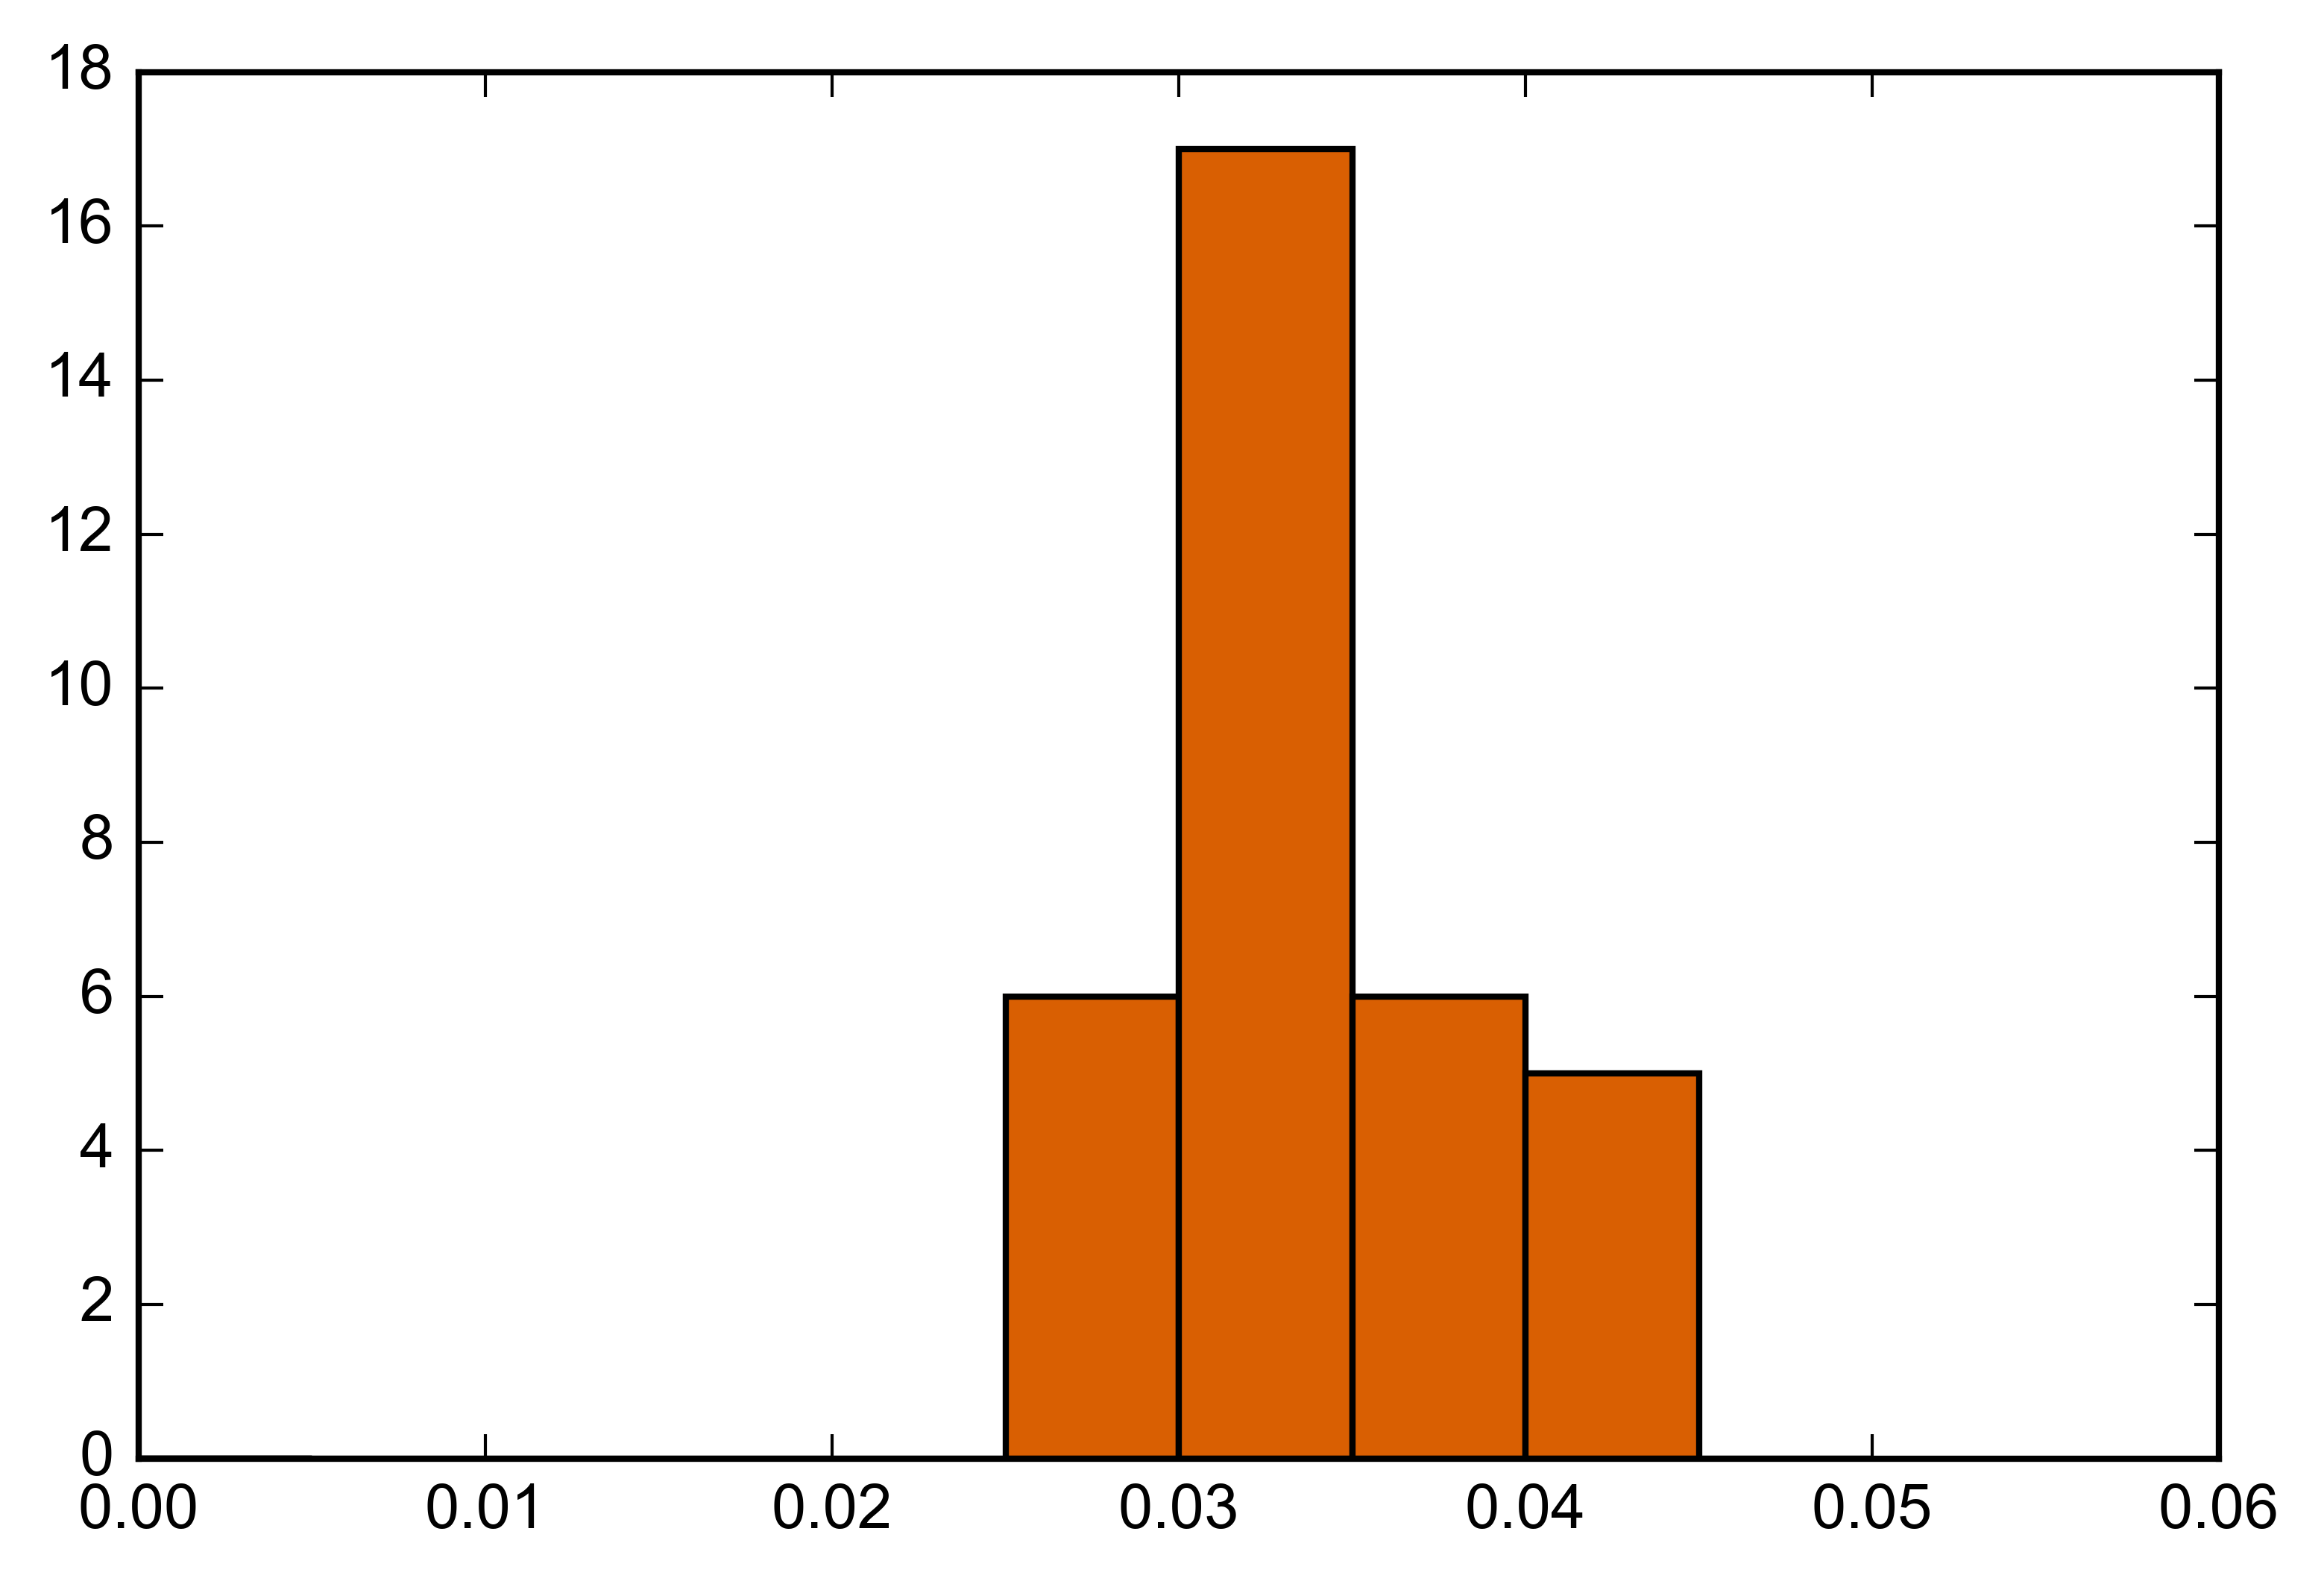

In [50]:
plt.hist(avrgRhoPerCsource, range=(-0.4, 0.0), bins=20, color='#d95f02')
plt.xlabel(r'Mean $\rho$ per carbon source')
plt.show()
plt.hist(avrgRhoPerNsource, range=(-0.4, 0.0), bins=20, color='#d95f02')
plt.xlabel(r'Mean $\rho$ per nitrogen source')
plt.show()
plt.hist(stdPerCsource, range=(0., 0.05), bins=10, color='#d95f02')
plt.show()
plt.hist(stdPerNsource, range=(0., 0.05), bins=10, color='#d95f02')
plt.show()

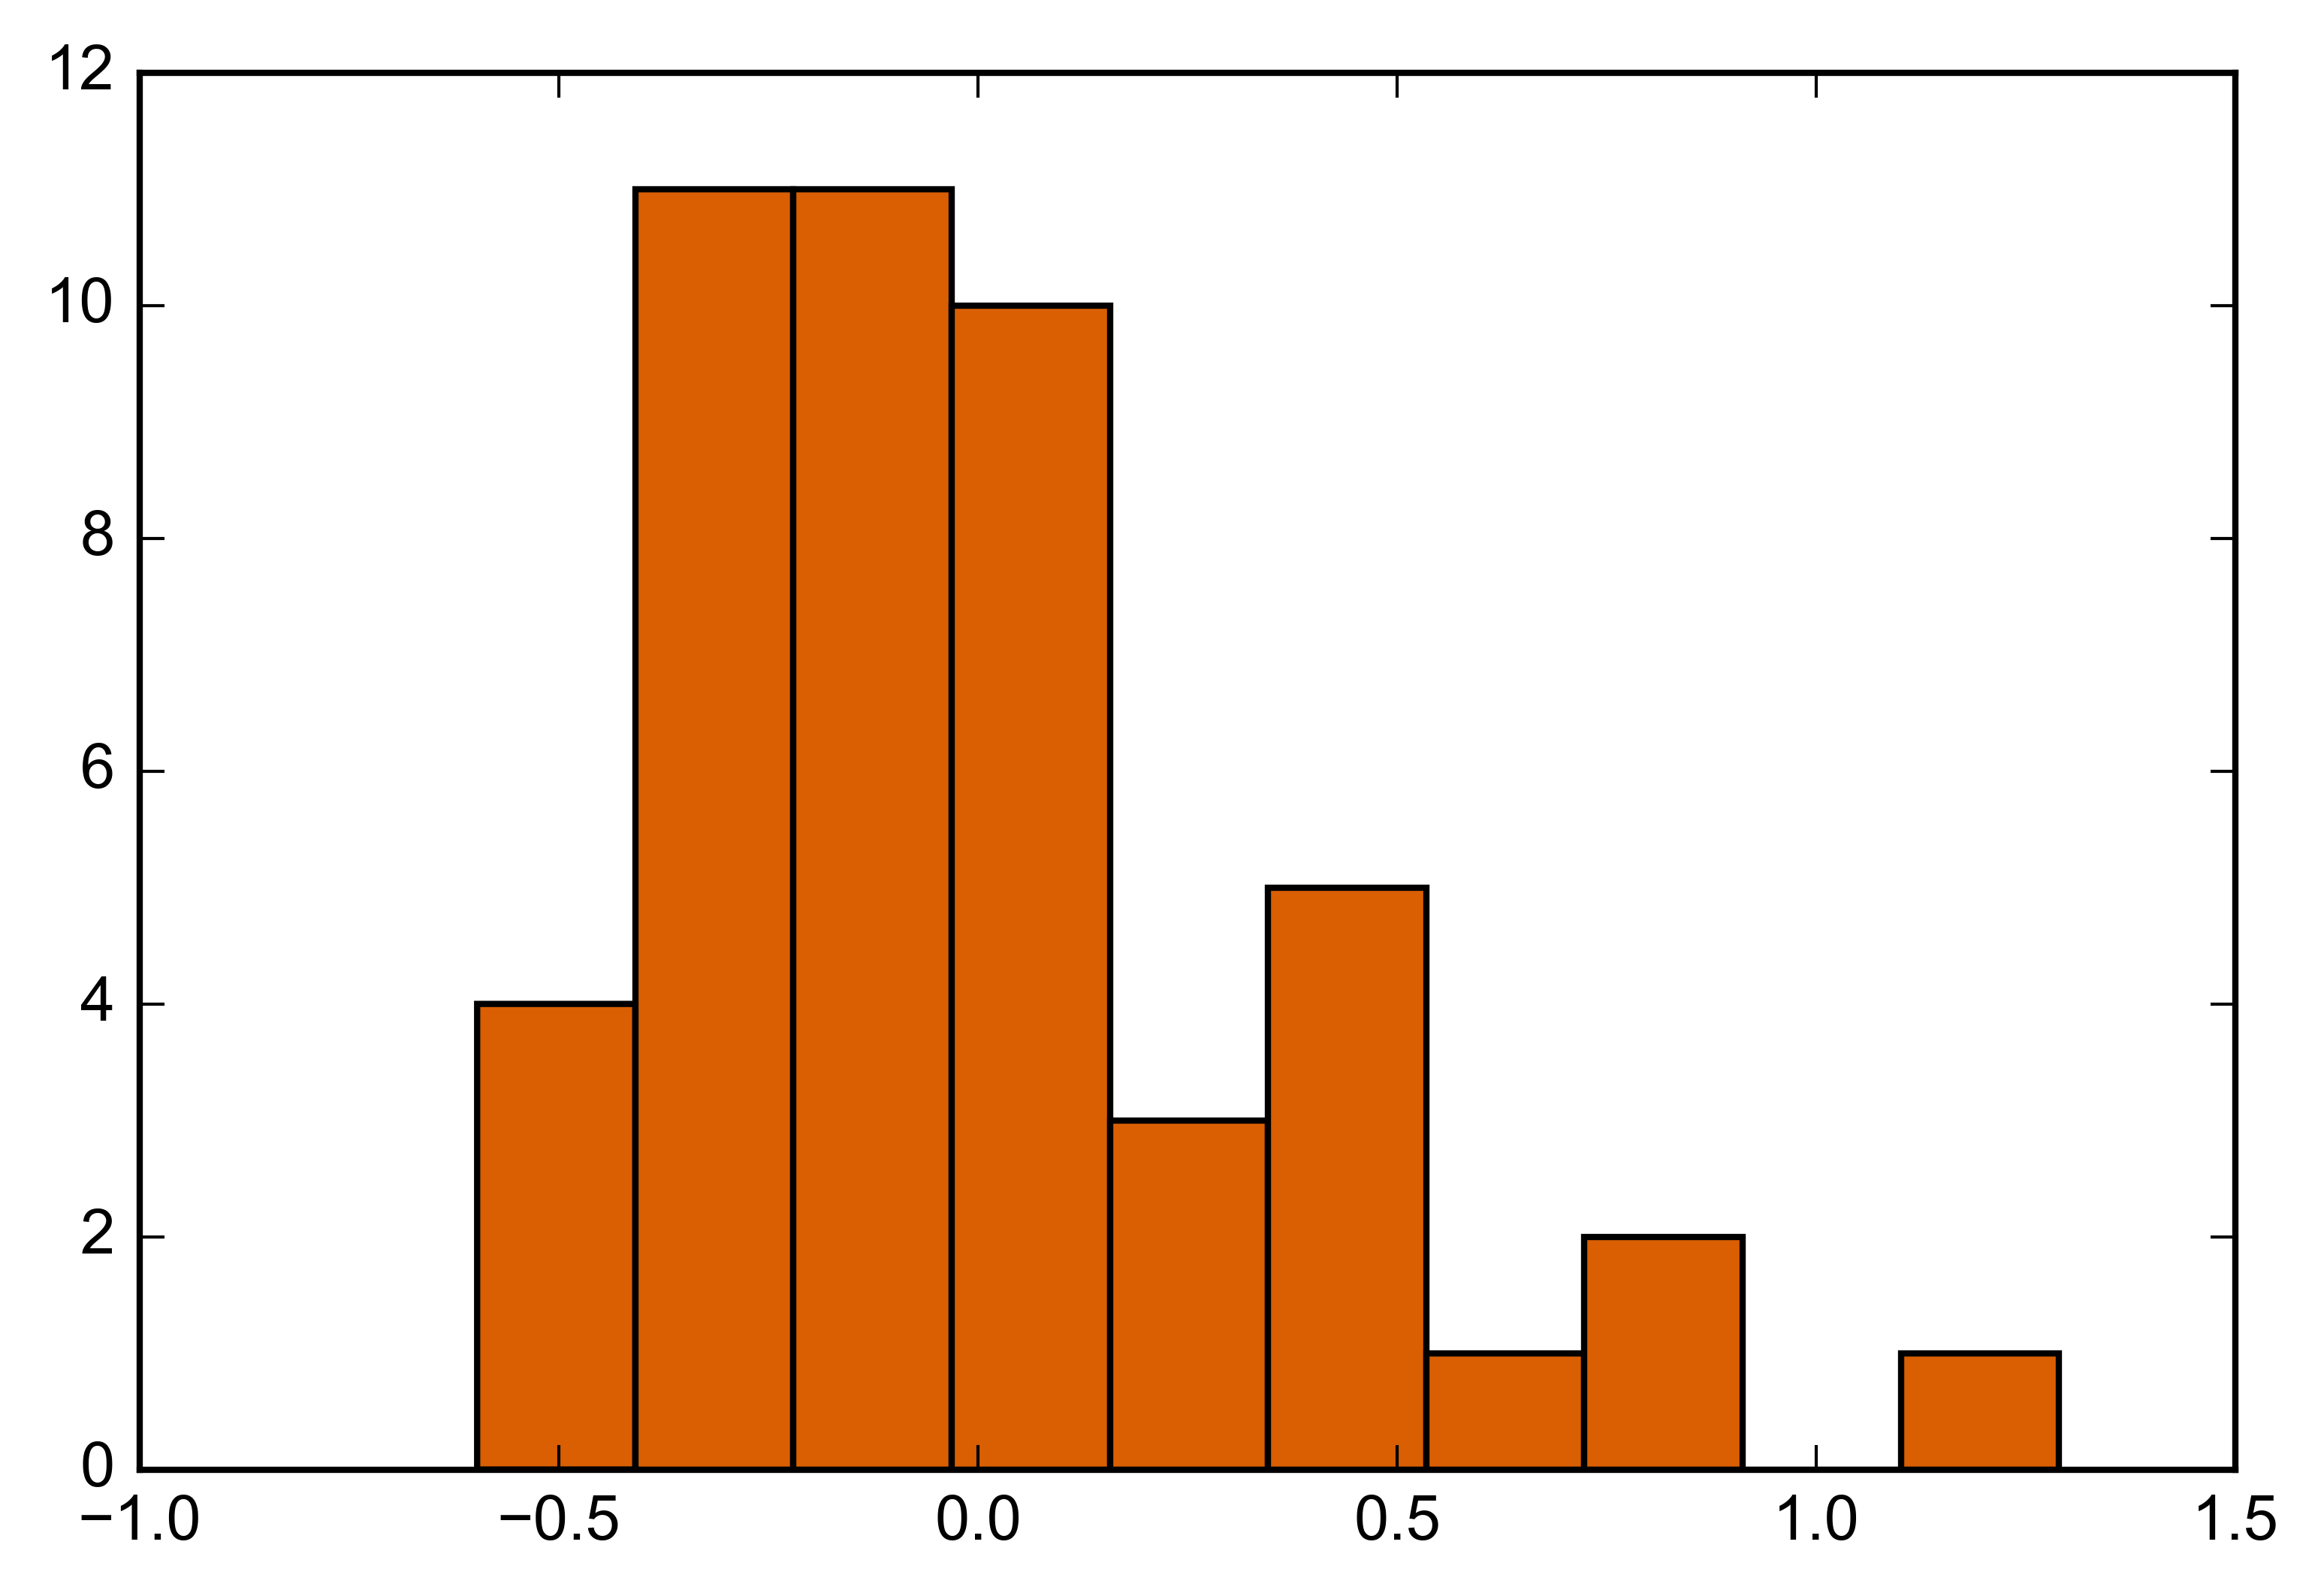

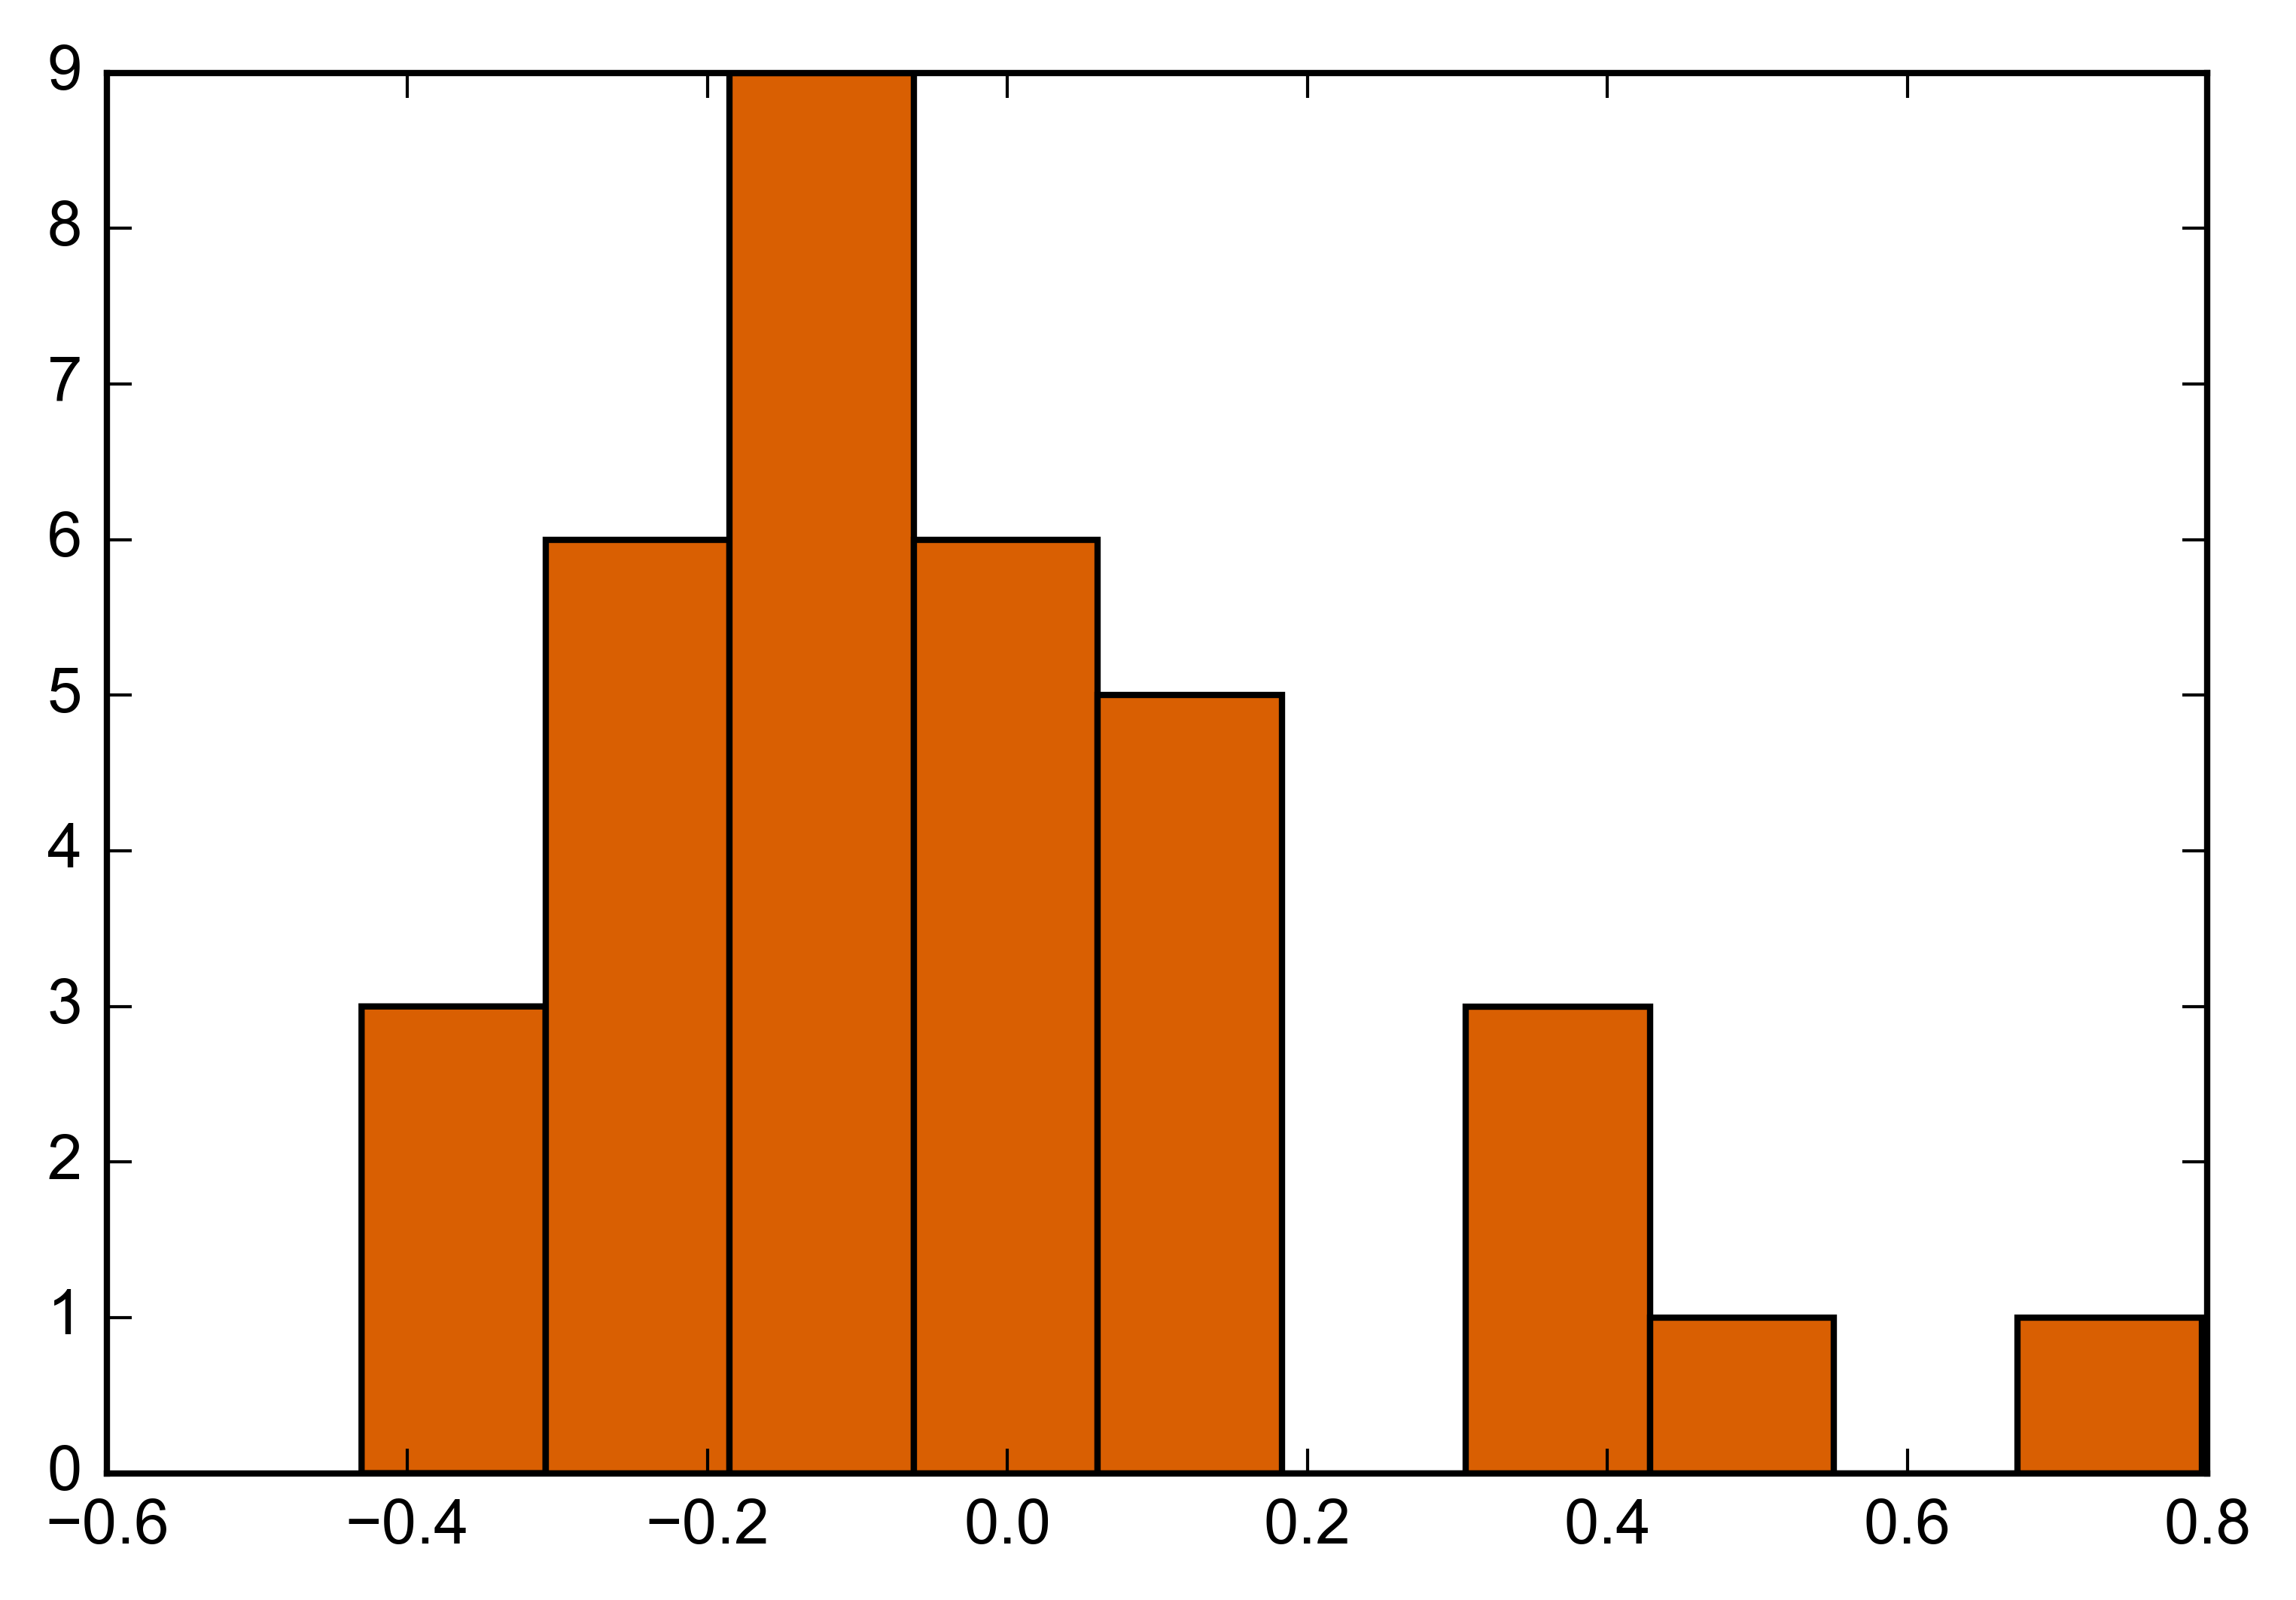

mean rho: -0.19
std rho: 0.04
lowest carbon source mean rho: -0.21
std: 0.03
for: pyruvate
pval: 6.73e-02


In [51]:
normalizedDiffsC = [(rho - np.mean(rhosOld)) / np.std(rhosOld) for rho in avrgRhoPerCsource]
plt.hist(normalizedDiffsC, color='#d95f02')
plt.show()
normalizedDiffsN = [(rho - np.mean(rhosOld)) / np.std(rhosOld) for rho in avrgRhoPerNsource]
plt.hist(normalizedDiffsN, color='#d95f02')
plt.show()
print 'mean rho: %.2f' % np.mean(rhosOld)
print 'std rho: %.2f' % np.std(rhosOld)
print 'lowest carbon source mean rho: %.2f' % min(avrgRhoPerCsource)
print 'std: %.2f' % stdPerCsource[np.argmin(normalizedDiffsC)]
print 'for:', carbonSources[np.argmin(avrgRhoPerCsource)]
print 'pval: %.2e' % pValsCarbon[np.argmin(avrgRhoPerCsource)]